$\Large{\text{Notebook to reproduce the results of:}}$

$\Large{\text{Bernard E, Nannya Y, Hasserjian P.H, et al. }}$

$\Large{\textit{Implications of TP53 Allelic State for Genome Stability, Clinical Presentation and Outcomes in Myelodysplastic Syndromes}}$

# Load Packages

Load below the used R packages.

In [46]:
library(ggplot2)
library(reshape2)
library(gridExtra)
library(survival)
library(survminer)
library(cmprsk)
library(stringr)

# Read Dataframes

In this section we read the clinical and molecular dataframes from the data folder.

In [3]:
# Clinical data with cytogenetics and NGS-derived copy-number results
# With detailed analysis of the status of chr17 at the TP53 locus
dd = read.table("./data/dd_clinical_cyto_chr17.tsv", header=T, sep="\t", stringsAsFactors=F)

In [4]:
paste("Total number of patients is", nrow(dd))

[1] "Total number of patients is 3324"

In [5]:
# Binary matrix of chromosomal alterations
# Patients in row and alterations in columns
ddcyto = read.table("./data/dd_matrix_binary_cyto.tsv", header=T, sep="\t", stringsAsFactors=F)
if(identical(dd$LEUKID,ddcyto$LEUKID)) print("all good with IDs")

[1] "all good with IDs"


In [6]:
ddcyto[c(1,9,151),1:5]

LEUKID               del5q plus8 del7 del20q
1   I-H-132697-T1-1-D1-1 0     0     0    1     
9   I-H-132704-T1-1-D1-1 1     0     1    1     
151 E-H-117425-T1-1-D1-1 1     0     1    0

In [7]:
# TP53 mutation file
# One line per mutation per patient
mm = read.table("./data/maf_TP53.tsv", header=T, sep="\t", stringsAsFactors=F)

In [8]:
head(mm,n=3)

TARGET_NAME          CHR START   END     REF ALT cDNA_CHANGE    GENE
1 E-H-100002-T1-1-D1-1 17  7579533 7579533 G   A   17_7579533_G_A TP53
2 E-H-100010-T1-1-D1-1 17  7577120 7577120 C   T   17_7577120_C_T TP53
3 E-H-100015-T1-1-D1-1 17  7578556 7578556 T   A   17_7578556_T_A TP53
  VAG_cDNA_CHANGE VT      aa_number VAG_VT EFFECT               VAF   DEPTH
1 c.154C>T        p.Q52*   52       Sub    stop_gained          0.597  487 
2 c.818G>A        p.R273H 273       Sub    non_synonymous_codon 0.869  510 
3 c.376-2A>T      p.?      NA       Sub    splice_site_variant  0.840 1028 
  CALLED_BY detail_status allelic_status
1 C,S,M     mut+cnloh     multi         
2 C,S,M     mut+del       multi         
3 C         mut+cnloh     multi

In [9]:
paste("Total number of TP53 mutations is", nrow(mm), "from", length(unique(mm$TARGET_NAME)),"TP53-mutated patients")

[1] "Total number of TP53 mutations is 486 from 378 TP53-mutated patients"

# Get Ready

In [10]:
# Some ggstyles
themePP = theme_classic() + theme(text=element_text(size=25,colour="black"),
                                 axis.text=element_text(size=25,colour="black"),
                                 axis.title=element_text(size=25,colour="black"),
                                 strip.text.x = element_text(size=25),
                                 legend.text=element_text(size=25)
                                )
noleg = theme(legend.position = "none")
topleg = theme(legend.position = "top")
angle45 = theme(axis.text.x = element_text(angle = 45, hjust = 1))
noxtitle = theme(axis.title.x = element_blank())
noytitle = theme(axis.title.y = element_blank())
noxlabel = theme(axis.text.x = element_blank())
noylabel = theme(axis.text.y = element_blank())
nolegtitle = theme(legend.title = element_blank())

In [11]:
# Some colors
col.subtypes = c("#EE9937","#67a9cf","#3690c0","#02818a")
col.status = c(col.subtypes[1],"#1d91c0")
col.ipssr = c("#238b45","#66c2a4","#807dba","#fdbb84","#ef6548")
col.who = c("#fcbba1","#d8b365","#99d8c9","#66c2a4","#41ae76","#43a2ca","#9e9ac8","#d4b9da","#c994c7","#df65b0","#fdd0a2","#fdae6b","#bdbdbd","#969696")
mypal.chr = c("#b24745ff","#dF8f44ff","#6A6599FF","#00a1d5ff","#374E55FF")
pal.wt.mut = c("darkgrey","#756bb1")

In [12]:
# Pval code function
pval_to_signif_code <- function (p_vals) 
{
    return(ifelse(p_vals < 0.0001, "****", ifelse(p_vals < 0.001, 
        "***", ifelse(p_vals < 0.01, "**", ifelse(p_vals < 0.05, "*", "ns")))))
}
pval_to_signif_code2 <- function (p_vals) 
{
    return(ifelse(p_vals < 0.0001, "<0.0001 ****", ifelse(p_vals < 0.001, 
        "<0.001 ***", ifelse(p_vals < 0.01, "<0.01 **", ifelse(p_vals < 0.05, "<0.05 *", "ns")))))
}

Below we compute outcome vectors and function for competing risk analysis

In [13]:
# Competing riks
dd$comp_sample_years = pmin(dd$os_sample_years, dd$aml_sample_years)
dd$comp_status = "censor"
dd$comp_status[dd$os_status==1] = "death"
dd$comp_status[dd$aml_status==1] = "aml"
dd$comp_status = factor(dd$comp_status, levels=c("censor","aml","death"))
table(dd$comp_status)

gg_competingrisks.cuminc <- function(fit, gnames = NULL, gsep=" ",
                                    coef = 1.96, conf.int = FALSE, line.size=1, group.levels=NULL) {
    
  # -- fit is from cuminc --  #
  if (!is.null(fit$Tests))
    fit <- fit[names(fit) != "Tests"]
  fit2 <- lapply(fit, `[`, 1:3)
  if (is.null(gnames)) gnames <- names(fit2)
  fit2_list <- lapply(seq_along(gnames), function(ind) {
    df <- as.data.frame(fit2[[ind]])
    df$name <- gnames[ind]
    df
  })
  time <- est <- event <- group <- NULL
  df <- do.call(rbind, fit2_list)
  df$event <- sapply(strsplit(df$name, split=gsep), `[`, 2)
  df$group <- sapply(strsplit(df$name, split=gsep), `[`, 1)
  df$std <- std <- sqrt(df$var)
  if (!is.na(group.levels)) {
      df$group = factor(df$group, levels=group.levels)
  }

  df <- df[df$event=="aml",]

  pl <-  ggplot(df, aes(time, est, color=group)) + geom_line(size=line.size) + ylab("Cumulative incidence of AMLt") + xlab("Years") + theme_survminer()

  if (conf.int) {
    pl <- pl + geom_ribbon(aes(ymin = est - coef*std, ymax=est + coef*std, fill = event), alpha = 0.2, linetype=0)
  }

  return(pl)
}


censor    aml  death 
  1661    562   1101 

# Compute TP53 subgroups and allelic states

We integrate mutations and allelic imbalances at the TP53 locus to define TP53 subgroups.

The subgroups are
* 1. mono-allelic TP53 per single gene mutation *(1mut)*
* 2. multiple TP53 mutations without allelic imbalances at the TP53 locus *(>1mut)*
* 3. mutation(s) and concomitant deletion at the TP53 locus *(mut+del)*
* 4. mutation(s) and concomitant cnLOH at the TP53 locus *(mut+cnloh)*

cnLOH: copy-neutral loss of heterozygosity 

We refer to subgroup 1. as mono-allelic TP53 and to subgroups 2-4 as bi-allelic or multi-hit.

In [14]:
# Status of chr17 at the TP53 locus
table(dd$chr17)


 cnloh    del   gain iso17q     WT 
    80     97      1     10   3136 

In [15]:
# Add TP53 mutations
# Number of mutations:
dd$TP53mut = sapply(dd$LEUKID, function(ll) sum(mm$TARGET_NAME==ll))

In [16]:
# Simply WT or MUT:
dd$tp53 = "WT"
dd$tp53[dd$TP53mut>0] = "MUT"
# TP53 WT or 1mut or >1mut
dd$TP53 = "WT"
dd$TP53[dd$TP53mut==1] = "1mut"
dd$TP53[dd$TP53mut>1] = ">1mut"
dd$TP53 = factor(dd$TP53, levels=c("WT","1mut",">1mut"))
# Label
dd$TP53label = "WT"
dd$TP53label[dd$TP53mut!=0] = paste0(dd$TP53mut[dd$TP53mut!=0],"mut")

In [26]:
paste("TP53 mutation status:")
table(dd$TP53mut)
paste("TP53 mutation status & chr17:")
table(dd$TP53mut, dd$chr17)

[1] "TP53 mutation status:"


   0    1    2    3 
2946  274  100    4 

[1] "TP53 mutation status & chr17:"

   
    cnloh  del gain iso17q   WT
  0     2   12    0     10 2922
  1    73   76    1      0  124
  2     4    7    0      0   89
  3     1    2    0      0    1

In [21]:
# Compute TP53 subgroups and allelic states
# subgroups:
dd$detail_status = as.vector(dd$TP53)
dd$detail_status[dd$TP53mut==0 & dd$chr17!="WT"] = NA
dd$detail_status[dd$TP53mut>0 & dd$chr17=="cnloh"] = "mut+cnloh"
dd$detail_status[dd$TP53mut>0 & dd$chr17=="del"] = "mut+del"
dd$detail_status = factor(dd$detail_status,levels=c("WT","1mut",">1mut","mut+del","mut+cnloh"))
# allelic states:
dd$allelic_status = "WT"
dd$allelic_status[dd$detail_status=="1mut"] = "1mut"
dd$allelic_status[dd$detail_status%in%c(">1mut","mut+del","mut+cnloh")] = "multi"
dd$allelic_status = factor(dd$allelic_status, levels=c("WT","1mut","multi"))

In [22]:
paste("Main TP53 subgroups:")
table(dd$detail_status,exclude=F)

[1] "Main TP53 subgroups:"


       WT      1mut     >1mut   mut+del mut+cnloh      <NA> 
     2922       125        90        85        78        24 

Note that the 24 NA corresponds to the 12, 2 and 10 cases with deletion, cnloh and iso17q respectively but without any gene mutation.

In [28]:
paste("With allelic states:")
table(dd$detail_status,dd$allelic_status)

[1] "With allelic states:"

           
              WT 1mut multi
  WT        2922    0     0
  1mut         0  125     0
  >1mut        0    0    90
  mut+del      0    0    85
  mut+cnloh    0    0    78

In [29]:
aa = dd[which(dd$detail_status!="WT"),]
aa$detail_status = factor(aa$detail_status, levels=c("1mut",">1mut","mut+del","mut+cnloh"))
aa$allelic_status = factor(aa$allelic_status, levels=c("1mut","multi"))

In [30]:
im = match(mm$TARGET_NAME,dd$LEUKID)
mm$detail_status = as.vector(dd[im,"detail_status"])
mm$detail_status = factor(mm$detail_status, levels=c("1mut",">1mut","mut+del","mut+cnloh"))
mm$allelic_status = as.vector(dd[im,"allelic_status"])
mm$allelic_status = factor(mm$allelic_status, levels=c("1mut","multi"))

# Metrics Calculation

We calculate the total number of deletions, gains or rearrangements on different chromosomes than 17.

In [31]:
dd$num_deletion_no17 = apply(ddcyto[,colnames(ddcyto)[grepl("del",colnames(ddcyto)) & !grepl("17",colnames(ddcyto))]],1,sum)
dd$num_gain_no17 = apply(ddcyto[,colnames(ddcyto)[grepl("plus",colnames(ddcyto)) & !grepl("17",colnames(ddcyto))]],1,sum)
dd$num_rearr_no17 = apply(ddcyto[,colnames(ddcyto)[grepl("r_",colnames(ddcyto)) & !grepl("17",colnames(ddcyto))]],1,sum)

We also calculate the number of unique chromosomes other than 17 with aberrations.

In [32]:
ddcyto.reduce.no17 = ddcyto[,!grepl("17",colnames(ddcyto))]
# list of vectors of events:
lresno17 = apply(ddcyto.reduce.no17, 1,  function(x) {res=NA; ix=which(x==1); if(length(ix)>0){ res=colnames(ddcyto.reduce.no17)[x==1]}; return(res)})
# Number of unique chr different than 17 with aberrations:
chr_from_events <- function(vector.events) {
    # extract the chromosomes involved in vector.events
    # return NA if NK or events without chr specified (eg mar, WGA ...)
    vector.chr = NA
    if (any(!is.na(vector.events))) {
        vector.chr.list = lapply(vector.events, function(x) {
                                     y = strsplit(x,split="_")[[1]]
                                     z = str_extract(y,"[0-9]+")
                                     return(z) }
        )
        vector.chr = unique(unlist(vector.chr.list))
        if (any(!is.na(vector.chr))) {
            vector.chr = unique(sort(vector.chr))
        }
    }
    return(vector.chr)
}
ngs_vector_event <- function(ngs.string) {
    if (is.na(ngs.string)) {
        return(NA)
    } else {
        return(sort(unique(strsplit(ngs.string,split=",")[[1]])))
    }
}
dd$NUM_ALL_CHR_NO17 = sapply( lresno17, function(x) { y=unique(chr_from_events(x)); resl=0; if(!identical(NA,y)){resl=length(y)};return(resl) } )

In [33]:
for(mygroup in levels(dd$detail_status)) {
    print(paste0("Summary distribution of number of chr. with aberrations for ",mygroup,":"))
    print(summary(dd$NUM_ALL_CHR_NO17[dd$detail_status==mygroup]))
    cat("\n")
}

[1] "Summary distribution of number of chr. with aberrations for WT:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.0000  0.6057  1.0000  7.0000      24 

[1] "Summary distribution of number of chr. with aberrations for 1mut:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   1.000   1.256   2.000  10.000      24 

[1] "Summary distribution of number of chr. with aberrations for >1mut:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   3.250   5.000   5.533   7.000  16.000      24 

[1] "Summary distribution of number of chr. with aberrations for mut+del:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   4.000   6.000   6.035   8.000  14.000      24 

[1] "Summary distribution of number of chr. with aberrations for mut+cnloh:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   5.000   6.000   6.321   8.000  13.000      24 



# Main Figure 1

## Fig 1a: Integration of mutations and allelic imbalances at TP53 locus

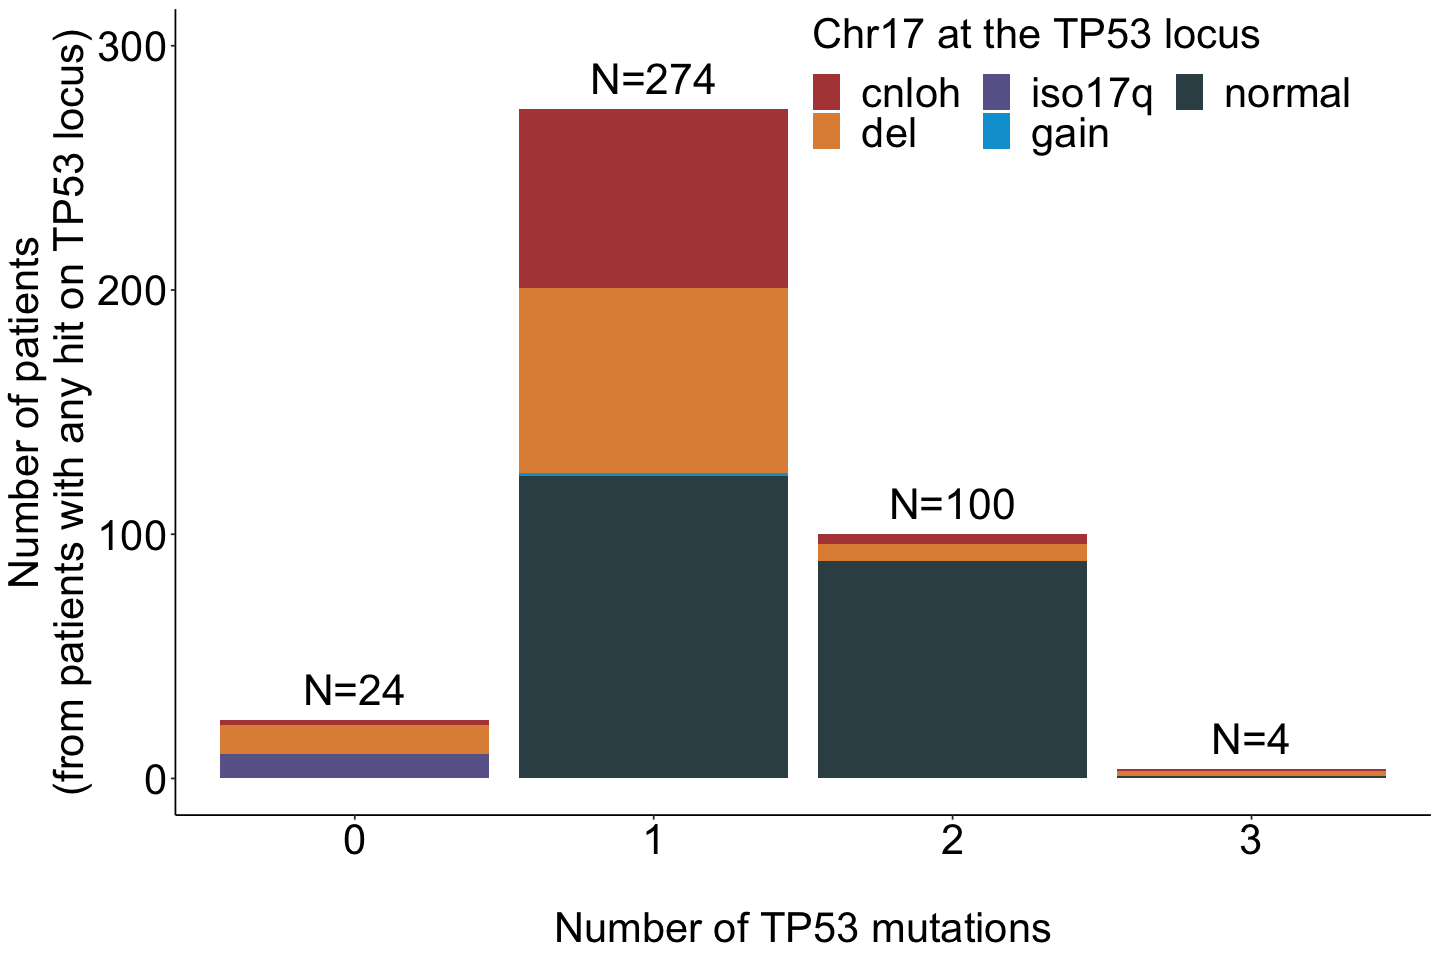

In [38]:
options(repr.plot.width=12, repr.plot.height=8)
hhh = dd[-which(dd$chr17=="WT" & dd$tp53=="WT"),]
hhh$chr17[hhh$chr17=="WT"] = "normal"
hhh$chr17[hhh$iso17q==1] = "iso17q"
hhh$chr17 = factor(hhh$chr17, levels=c("cnloh","del","iso17q","gain","normal"))
hhhlabel = as.data.frame(table(hhh$TP53mut))
hhhlabel$label = paste0("N=",hhhlabel$Freq)
gchrgene = ggplot(hhh) + geom_bar(aes(x=factor(TP53mut),fill=chr17)) + themePP +
ylab(paste0("Number of patients","\n","(from patients with any hit on TP53 locus)")) + xlab("\nNumber of TP53 mutations") +
scale_fill_manual(values=mypal.chr,name="Chr17 at the TP53 locus") +
guides(fill=guide_legend(ncol=3)) + 
theme(legend.position = c(0.50, 0.91),legend.justification = "left") +
scale_y_continuous(breaks=c(0,100,200,300),limits=c(0,300)) + 
geom_text(data=hhhlabel,aes(x=Var1,y=Freq,label=label),vjust=-0.5,angle=0,hjust=0.5,size=9,color="black")

gchrgene

## Fig 1b: Derivation of TP53 subgroups

In [39]:
bb = dd[dd$detail_status != "WT",]
bb$detail_status = factor(bb$detail_status,levels=names(table(bb$detail_status))[-1])
bfreq = as.data.frame(table(bb$detail_status))
colnames(bfreq) = c("type","count")
bfreq$freq = 100*bfreq$count/sum(bfreq$count)
bfreq$label1 = paste0("N=",bfreq$count)

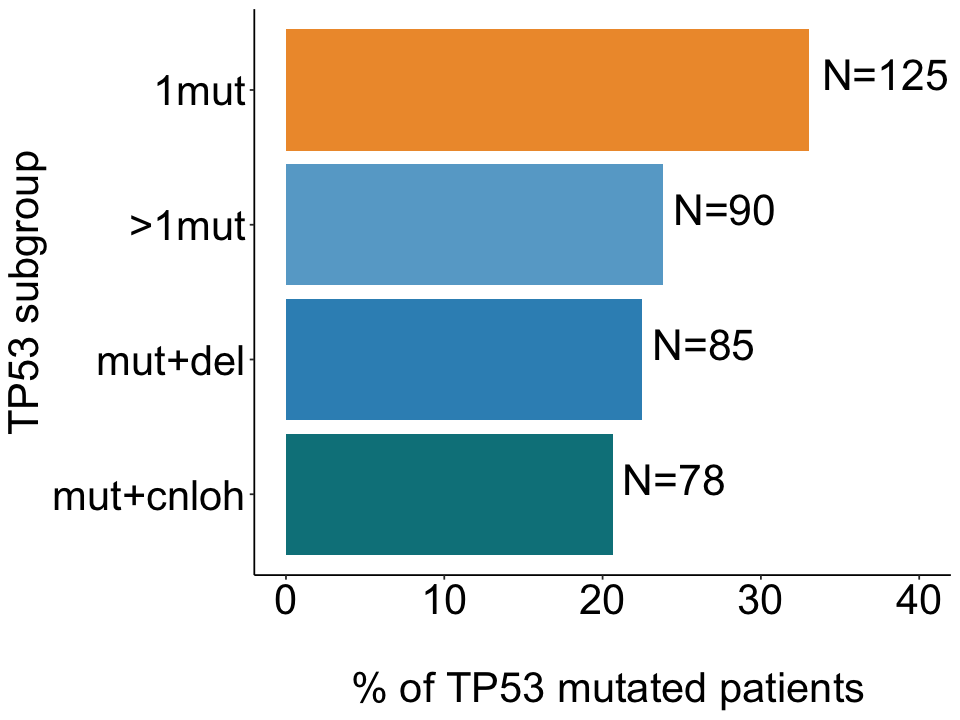

In [40]:
options(repr.plot.width=8, repr.plot.height=6)
bfreq$type = factor(bfreq$type, levels=rev(levels(bfreq$type)))

gg.preval.2 = ggplot(bfreq,aes(x=type,y=freq, fill=type)) + geom_bar(stat="identity") + 
geom_text(aes(label=label1),colour="black",vjust=0,angle=0,hjust=-0.1,size=9) + 
themePP + 
xlab("TP53 subgroup") + ylab("\n % of TP53 mutated patients") + ylim(0,40) + scale_fill_manual(values=rev(col.subtypes)) + 
scale_colour_manual(values=rev(col.subtypes)) + noleg + 
coord_flip()

gg.preval.2

## Fig 1c: VAF per TP53 subgroup

VAF: variant allele frequency

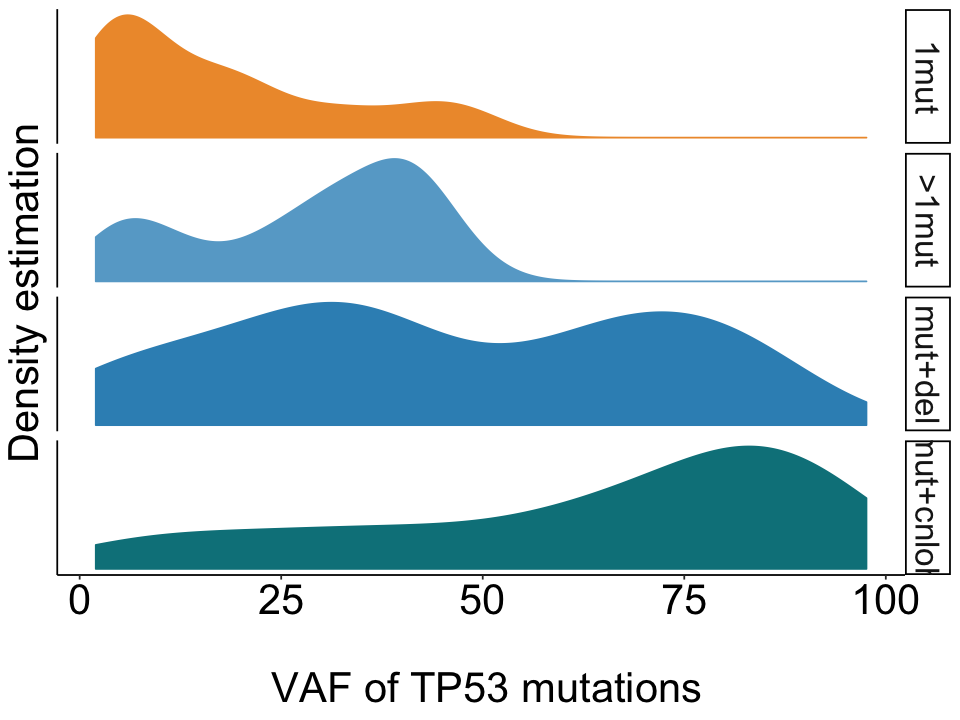

In [41]:
options(repr.plot.width=8, repr.plot.height=6)
gg.vaf = ggplot(mm,aes(x=100*VAF,fill=detail_status,color=detail_status))+geom_density() + 
themePP +
scale_fill_manual(values=col.subtypes) + scale_color_manual(values=col.subtypes) + 
facet_grid(detail_status~.,scales="free_y") + noleg + scale_y_continuous(position="left") + 
ylab("Density estimation") + xlab("\n VAF of TP53 mutations") + 
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())

gg.vaf

In [42]:
for(mygroup in levels(dd$detail_status)[-1]) {
    print(paste0("Summary distribution of TP53 mutations VAF for ",mygroup,":"))
    print(summary(mm$VAF[mm$detail_status==mygroup]))
    cat("\n")
}

[1] "Summary distribution of TP53 mutations VAF for 1mut:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0210  0.0510  0.1290  0.1776  0.2670  0.5290 

[1] "Summary distribution of TP53 mutations VAF for >1mut:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0200  0.1610  0.3220  0.2862  0.3980  0.5160 

[1] "Summary distribution of TP53 mutations VAF for mut+del:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0200  0.2407  0.4100  0.4567  0.6983  0.9180 

[1] "Summary distribution of TP53 mutations VAF for mut+cnloh:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0220  0.4284  0.7105  0.6303  0.8505  0.9760 



# Main Figure 2

## Fig 2a: Genome stability per TP53 subgroup

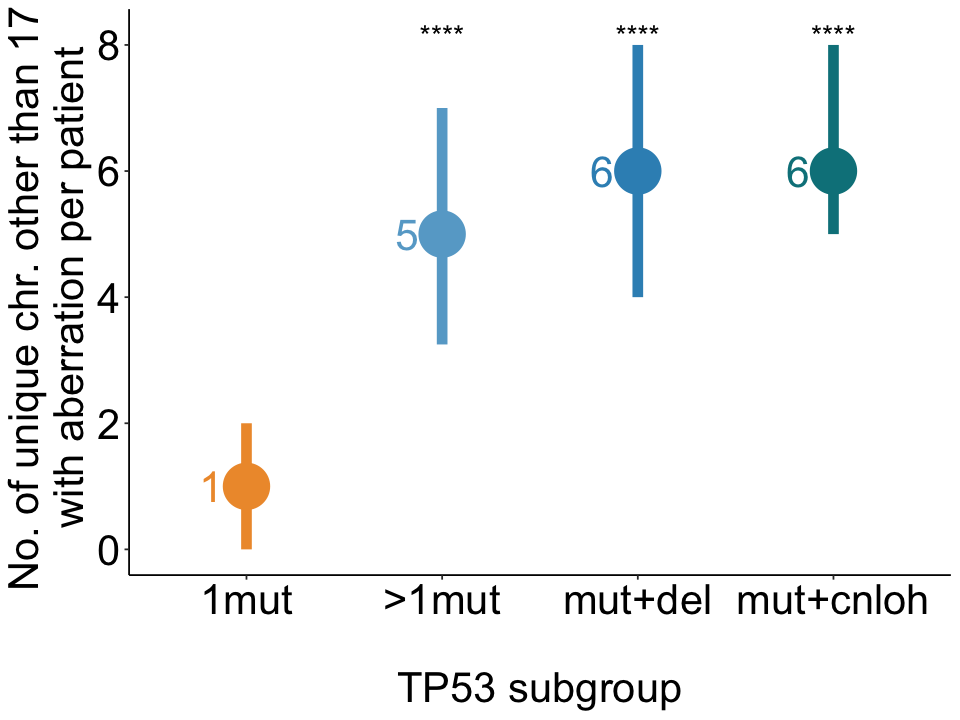

In [47]:
options(repr.plot.width=8, repr.plot.height=6)
gg.num.all  =  ggplot(dd[which(dd$detail_status!="WT"),], aes(x=detail_status,y=NUM_ALL_CHR_NO17)) +
geom_pointrange(data=dd[which(dd$detail_status!="WT"),],mapping=aes(x=detail_status,y=NUM_ALL_CHR_NO17,color=detail_status),
                stat = "summary", position_dodge(width=0.4),
                size = 3,
                fun.ymin = function(z) {quantile(z,0.25)},
                fun.ymax = function(z) {quantile(z,0.75)},
                fun.y = median) +
themePP + 
xlab("\nTP53 subgroup") + ylab("No. of unique chr. other than 17 \n with aberration per patient") +
scale_color_manual(values=col.subtypes,guide="none") + scale_y_continuous(breaks=c(0,2,4,6,8)) + 
stat_compare_means(label="p.signif",ref.group="1mut",label.y.npc=0.51,method="wilcox.test",size=6) + 
stat_summary(geom="text", fun.y=median,
               aes(label=sprintf("%1.0f", ..y..), color=detail_status),
               position=position_nudge(x=-0.18), size=9)

gg.num.all

## Fig 2b: Deletions, gains and rearrangement per TP53 subgroup

In [48]:
bb = melt(data=dd[dd$detail_status!="WT",], id.vars=c("LEUKID","detail_status","allelic_status"), measure.vars = c("num_deletion_no17", "num_gain_no17","num_rearr_no17"))
bb$variable = gsub("num_deletion_no17","del",bb$variable)
bb$variable = gsub("num_gain_no17","gain",bb$variable)
bb$variable = gsub("num_rearr_no17","rearr",bb$variable)
colnames(bb) = c("LEUKID","detail_status","allelic_status","anomaly","number")
bb$anomaly = factor(bb$anomaly, levels=c("rearr","gain","del"))

Warning message:
“`cols` is now required.
Please use `cols = c(p)`”Warning message:
“Removed 73 rows containing non-finite values (stat_boxplot).”

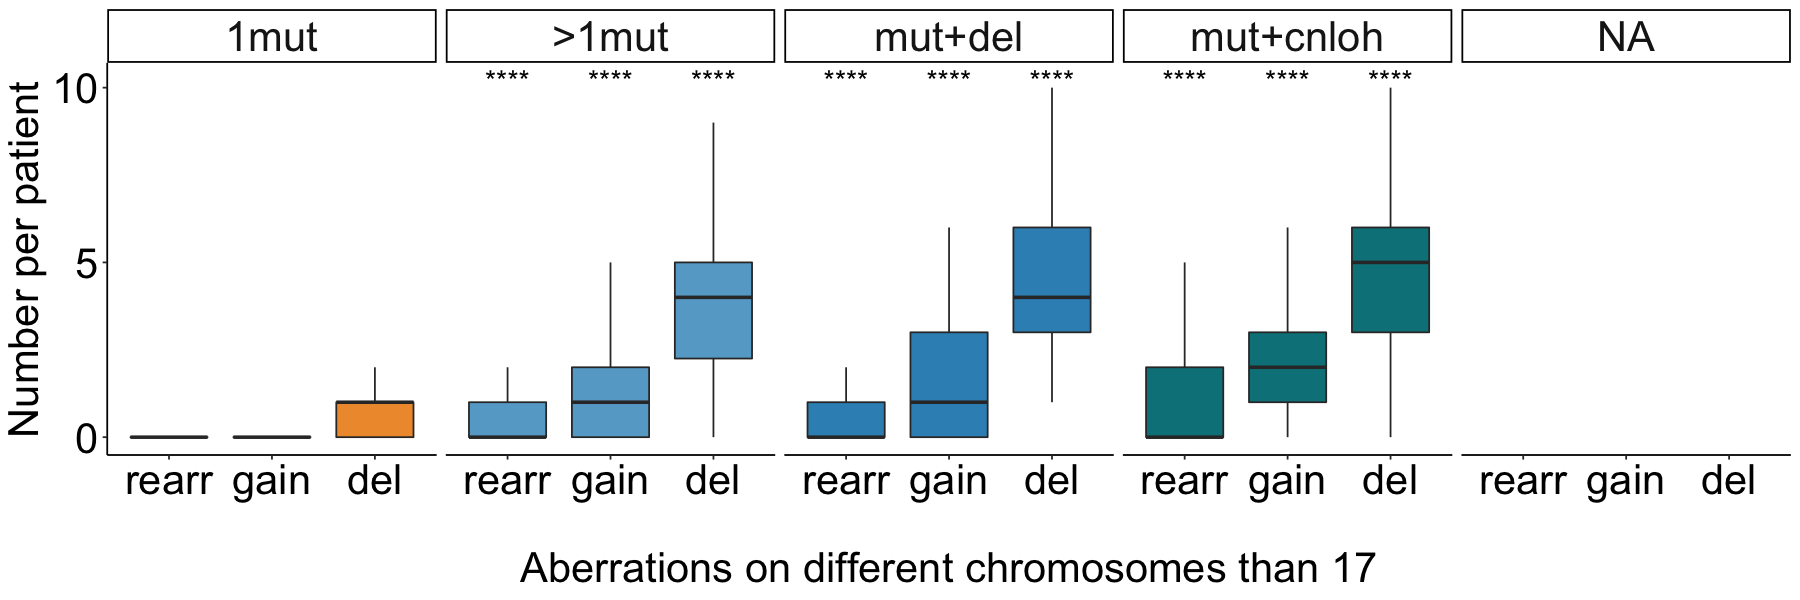

In [49]:
options(repr.plot.width=15, repr.plot.height=5)

cm = compare_means(number ~ detail_status, data=bb, method = "wilcox.test", paired = FALSE,
                  group.by = "anomaly",ref.group="1mut")
cm$detail_status = cm$group2
cm$detail_status = factor(cm$detail_status, levels=levels(bb$detail_status))

gg.num.aberr = ggplot(bb,aes(x=anomaly,y=number)) + geom_boxplot(outlier.shape=NA,aes(fill=detail_status)) + 
facet_grid(.~detail_status) +
themePP + 
noleg + scale_fill_manual(values=col.subtypes) + scale_color_manual(values=col.subtypes) + ylab("Number per patient") + 
scale_y_continuous(breaks=c(0,5,10),limits=c(0,10.2)) +
xlab("\nAberrations on different chromosomes than 17") +
geom_text(data=cm,aes(x=anomaly,y=10.2,label=p.signif),size=6)

gg.num.aberr

## Fig 2c: Heatmap of chromosomal alterations per TP53 subrgoup

We display below a heatmap of chromosomal alterations across TP53 subgroups.

Patients are in columns, ordered by their TP53 subgroup: 1. mono-allelic 2. multi-hit per multiple mutations 3. multi-hit per mutation(s) + deletion 4. multi-hit per mutation(s) + cnloh.

Alterations are in rows. We display any alterations found in >=2 % of patients from the mono-allelic state or the multi-hit state (i.e >1mut, mut+del, mut+cnloh).

Alterations are ordered as:
- presence of complex karyottype
- marker chromosome mar
- deletions
- gains
- rearrangements
- cnloh
- whole genome amplification WGA
- presence of a ring chromosomes ring

In [50]:
tbi = sort(apply(ddcyto[dd$allelic_status=="multi",colnames(ddcyto)[-1]],2,sum))
tmono = sort(apply(ddcyto[dd$allelic_status=="1mut",colnames(ddcyto)[-1]],2,sum))

In [51]:
# We consider for the heatmap,
# the chromosomal alterations observed in >=2 % of patients from the TP53 mono-allelic or mutli-hit cases
namesbi = rev(names(tbi)[100*tbi/sum(dd$allelic_status=="multi")>2])
namesmono = rev(names(tmono)[100*tmono/sum(dd$allelic_status=="1mut")>2])

In [52]:
mydelh = c(namesbi[grep("del",namesbi)])
mygainh = c(namesbi[grep("plus",namesbi)], "plus12")
myrh = c(namesbi[grep("r_",namesbi)])
mylohh = c(namesbi[grep("cnloh",namesbi)],"cnloh9p")
myaberr = c("complex","mar",mydelh,mygainh,myrh,mylohh,"WGA","ring")

In [53]:
tmp = dd[dd$allelic_status!="WT",]
tmp$myck = tmp$complex
tmp$complex = 0
tmp$complex[tmp$myck=="complex"] = 1
tmp$detail_status = factor(tmp$detail_status, levels=c("1mut",">1mut","mut+del","mut+cnloh"))
tmp$mygroup = tmp$detail_status # not smart
tmp = cbind( tmp[,"complex",drop=F] , ddcyto[dd$allelic_status!="WT",myaberr[-1]] , tmp[,c("detail_status","mygroup","LEUKID")] )

In [54]:
# Merge del5q and del5
# Merge del17p and del17
# Merge cnloh17p and cnloh17
# For better visualization
tmp$del5q[tmp$del5==1] = 1
tmp$del5 = NULL
colnames(tmp)[colnames(tmp)=="del5q"] = "del5q/5"
myaberr = myaberr[-which(myaberr=="del5")]
myaberr[myaberr=="del5q"] = "del5q/5"

tmp$del17p[which(tmp$del17==1)] = 1
tmp$del17 = NULL
colnames(tmp)[colnames(tmp)=="del17p"] = "del17p/17"
myaberr = myaberr[-which(myaberr=="del17")]
myaberr[myaberr=="del17p"] = "del17p/17"

tmp$cnloh17p[which(tmp$cnloh17==1)] = 1
tmp$cnloh17 = NULL
colnames(tmp)[colnames(tmp)=="cnloh17p"] = "cnloh17p/17"
myaberr = myaberr[-which(myaberr=="cnloh17")]
myaberr[myaberr=="cnloh17p"] = "cnloh17p/17"

In [55]:
# Cluster patients per TP53 subgroups based on molecular vectors
listpatientlevel2  = lapply(levels(tmp$mygroup), function(x) {
    ww = tmp$LEUKID[which(tmp$mygroup==x)]
    fmp = tmp[which(tmp$mygroup==x),]
    # cluster patients within group
    hdist = dist(fmp[,myaberr],method="binary")
    hindex = rev(hclust(hdist, method = "ward.D", members = NULL)$order)
    return( ww[hindex] ) 
})
long_dd_clustered = melt(tmp, id=c("LEUKID","mygroup"),measure.vars = myaberr)
colnames(long_dd_clustered)[1] = "Patient"
long_dd_clustered$Patient = factor(long_dd_clustered$Patient, levels=unlist(listpatientlevel2))
long_dd_clustered$variable = factor(long_dd_clustered$variable, levels=rev(myaberr))
row_sep = c(2,length(mydelh)-2,length(mygainh),length(myrh),length(mylohh)-1,2)
row_sep_cum = c(cumsum(row_sep))
row_sep_cum = row_sep_cum[-length(row_sep_cum)]
row_sep_cum = length(myaberr) - row_sep_cum
row_col = as.vector(sapply(levels(tmp$mygroup), function(x) sum(tmp$mygroup==x)))
row_col_cum = c(cumsum(row_col))
row_col_cum = row_col_cum[-length(row_col_cum)] 
uptext = data.frame(x=c(cumsum(row_col)-(row_col/2)), y=rep(length(myaberr)+3,), label=levels(tmp$mygroup))

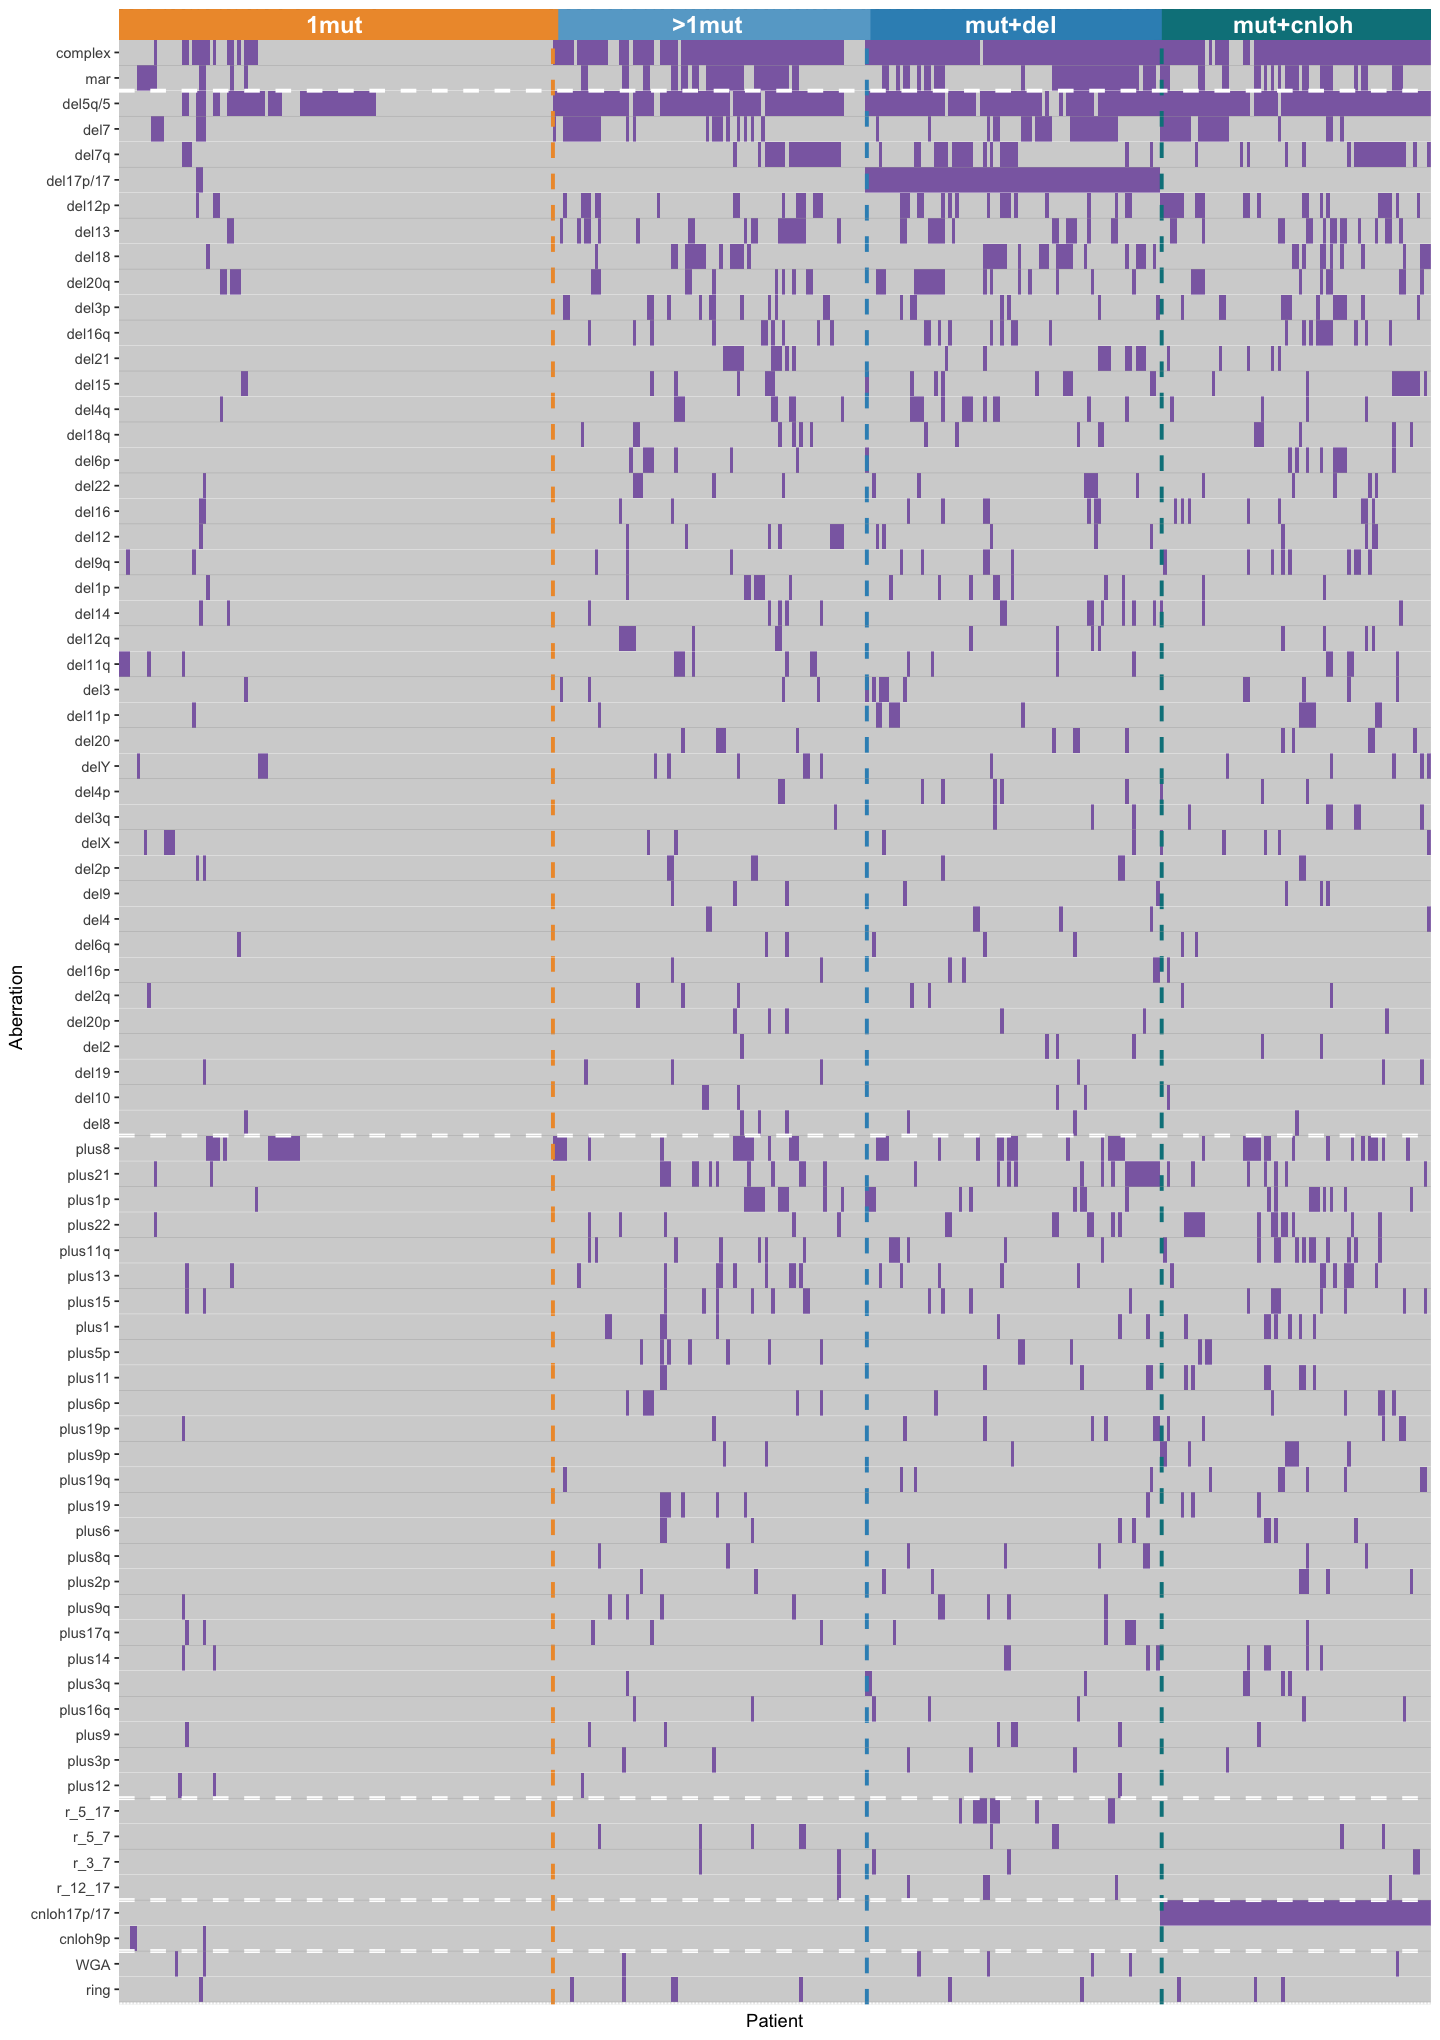

In [61]:
# Plot the heatmap
options(repr.plot.width=12, repr.plot.height=17)
ggheat2 = ggplot(long_dd_clustered, aes(Patient,variable,fill=)) +

    # geom raster heatmap
    geom_tile(aes(fill = factor(value)), show.legend = FALSE) +
    scale_fill_manual(values = c('0' = 'lightgrey', '1' = '#8c6bb1')) +

    # axis
    theme(axis.text.x = element_blank(), 
          axis.ticks.x = element_blank()) + 

    # column sand row separation  (+ 0.5 to be exactly at the good location)
    geom_vline(xintercept = row_col_cum[1] + 0.5, col = col.subtypes[1], linetype = 2, size = 1.1) + 
    geom_vline(xintercept = row_col_cum[2] + 1.0, col = col.subtypes[3], linetype = 2, size = 1.1) + 
    geom_vline(xintercept = row_col_cum[3] + 1.0, col = col.subtypes[4], linetype = 2, size = 1.1) + 
    geom_hline(yintercept = row_sep_cum + 0.5, col = 'white', linetype = 2, size = 1.1) +

    # 3d effect by adding white and grey horizontal line
    geom_hline(yintercept = seq(1, length(myaberr), 2) + 0.5, col = 'white', linetype = 1, size = 0.1) +
    geom_hline(yintercept = seq(0, length(myaberr), 2) + 0.5, col = 'darkgrey', linetype = 1, size = 0.1) +

    ylab("Aberration") + 

    geom_tile(aes(x=Patient,y=length(myaberr)+1.2,color=mygroup),alpha=.7,size=3) + 
    scale_color_manual(values=c(col.subtypes)) + 
    noleg + 
    geom_text(data=uptext, mapping=aes(x=x,y=78.1,label=label),size=5,color="white",fontface="bold")

#options(repr.plot.res = 300) # Better resolution for that plot
ggheat2

# Main Figure 3

## Fig 3a: OS per TP53 allelic state

OS: overall survival

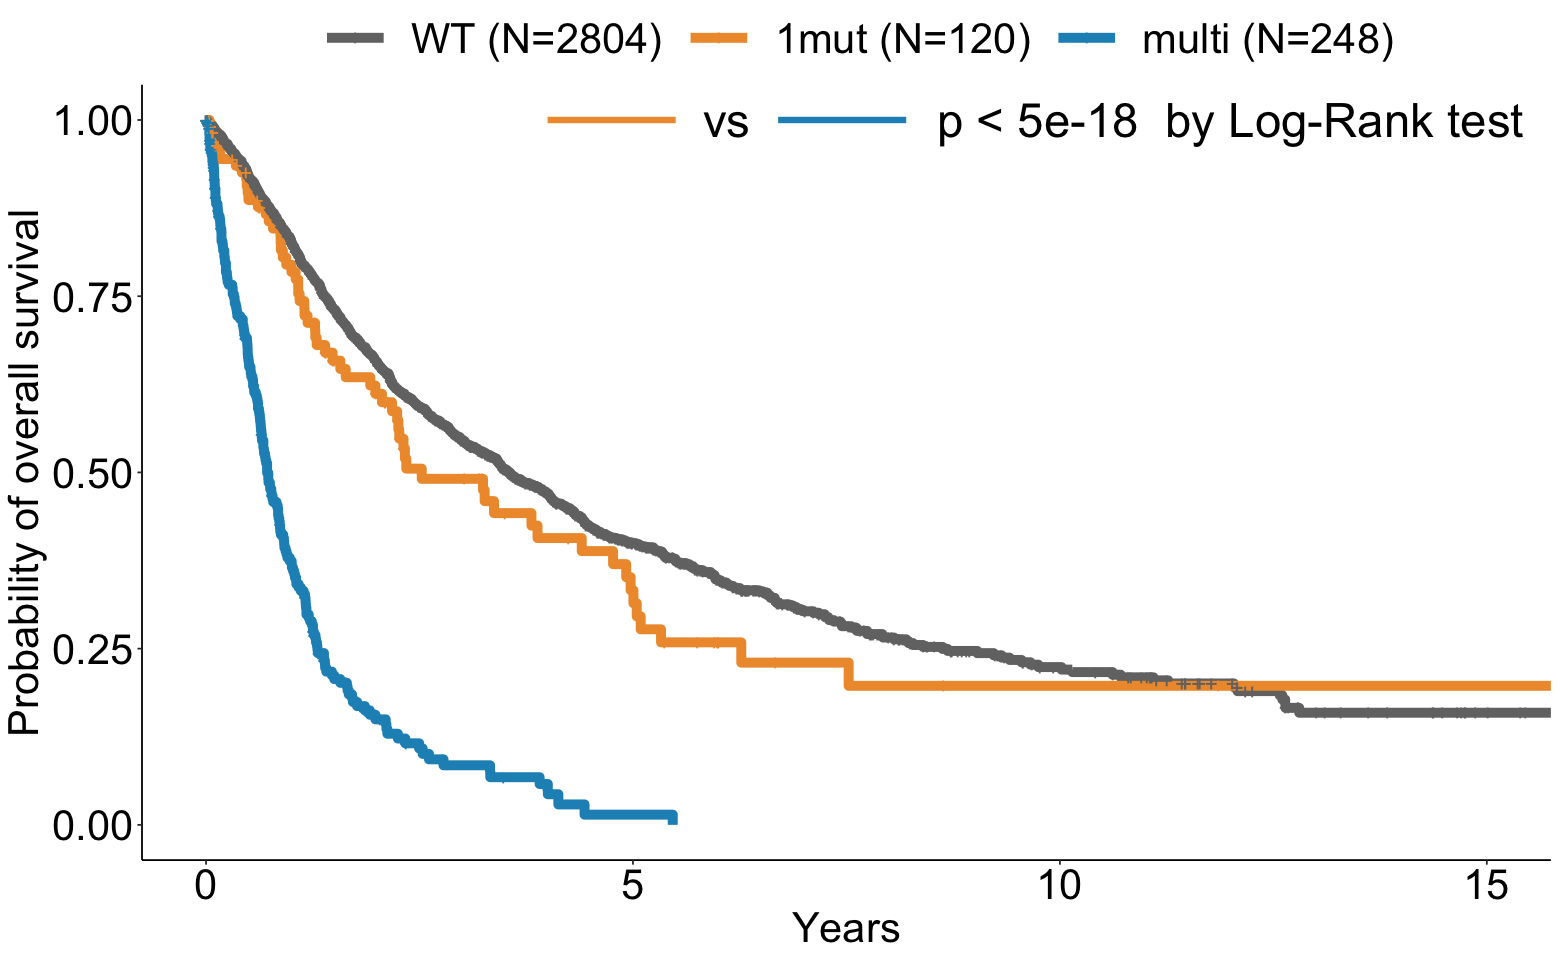

In [62]:
options(repr.plot.width=13, repr.plot.height=8)
ff = as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status"))
kmfit = survfit(ff,data=dd)
kmfit$call$formula <- ff
myleg = paste0(gsub("allelic_status=","",names(kmfit$strata))," (N=",kmfit$n,")")

ggs = ggsurvplot(kmfit, data=dd, legend.title="",legend.labs=myleg, conf.int=F, size=2.8, xlim=c(0,15),break.time.by=5)$plot +
scale_color_manual(values=c("#737373",col.status)) + xlab("Years")

ptOS = pairwise_survdiff(formula=ff, data=dd, p.adjust.method = "none")

ggOS = ggs + themePP + theme(legend.key.width = unit(1.5,"cm")) +
annotate("segment",color=col.status[1],x=4,xend=5.5,y=1,yend=1,size=1.8) + 
annotate("text",label="vs",y=1,x=6.1,size=10) +
annotate("segment",color=col.status[2],x=6.7,xend=8.2,y=1,yend=1,size=1.8) +
#annotate("text",label=expression(paste(p,"<",10^-16," by Log-Rank test")),x=12,y=1,size=10) +
annotate("text",label=paste("p","<",signif(ptOS$p.value[2,2],1)," by Log-Rank test"),x=12,y=1,size=10) +
ylab("Probability of overall survival") + topleg

ggOS

In [64]:
# Pairwise Log-rank tests:
ptOS$p.value

WT            1mut        
1mut   1.859697e-01           NA
multi 1.122813e-106 4.512274e-18

In [65]:
# Hazard Ratio multi vs. 1mut:
summary( coxph(ff,data=dd[dd$allelic_status%in%c("1mut","multi"),]) )

Call:
coxph(formula = ff, data = dd[dd$allelic_status %in% c("1mut", 
    "multi"), ])

  n= 368, number of events= 263 
   (10 observations deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)    
allelic_status1mut  -1.2972    0.2733   0.1578 -8.222   <2e-16 ***
allelic_statusmulti      NA        NA   0.0000     NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut     0.2733      3.659    0.2006    0.3723
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.627  (se = 0.015 )
Likelihood ratio test= 80.7  on 1 df,   p=<2e-16
Wald test            = 67.59  on 1 df,   p=<2e-16
Score (logrank) test = 75.04  on 1 df,   p=<2e-16


## Fig 3b: AMLt per TP53 allelic state

AMLt: AML transformation

291 cases omitted due to missing values
26 cases omitted due to missing values


Warning message in if (!is.na(group.levels)) {:
“the condition has length > 1 and only the first element will be used”Warning message:
“Removed 2 rows containing missing values (geom_path).”

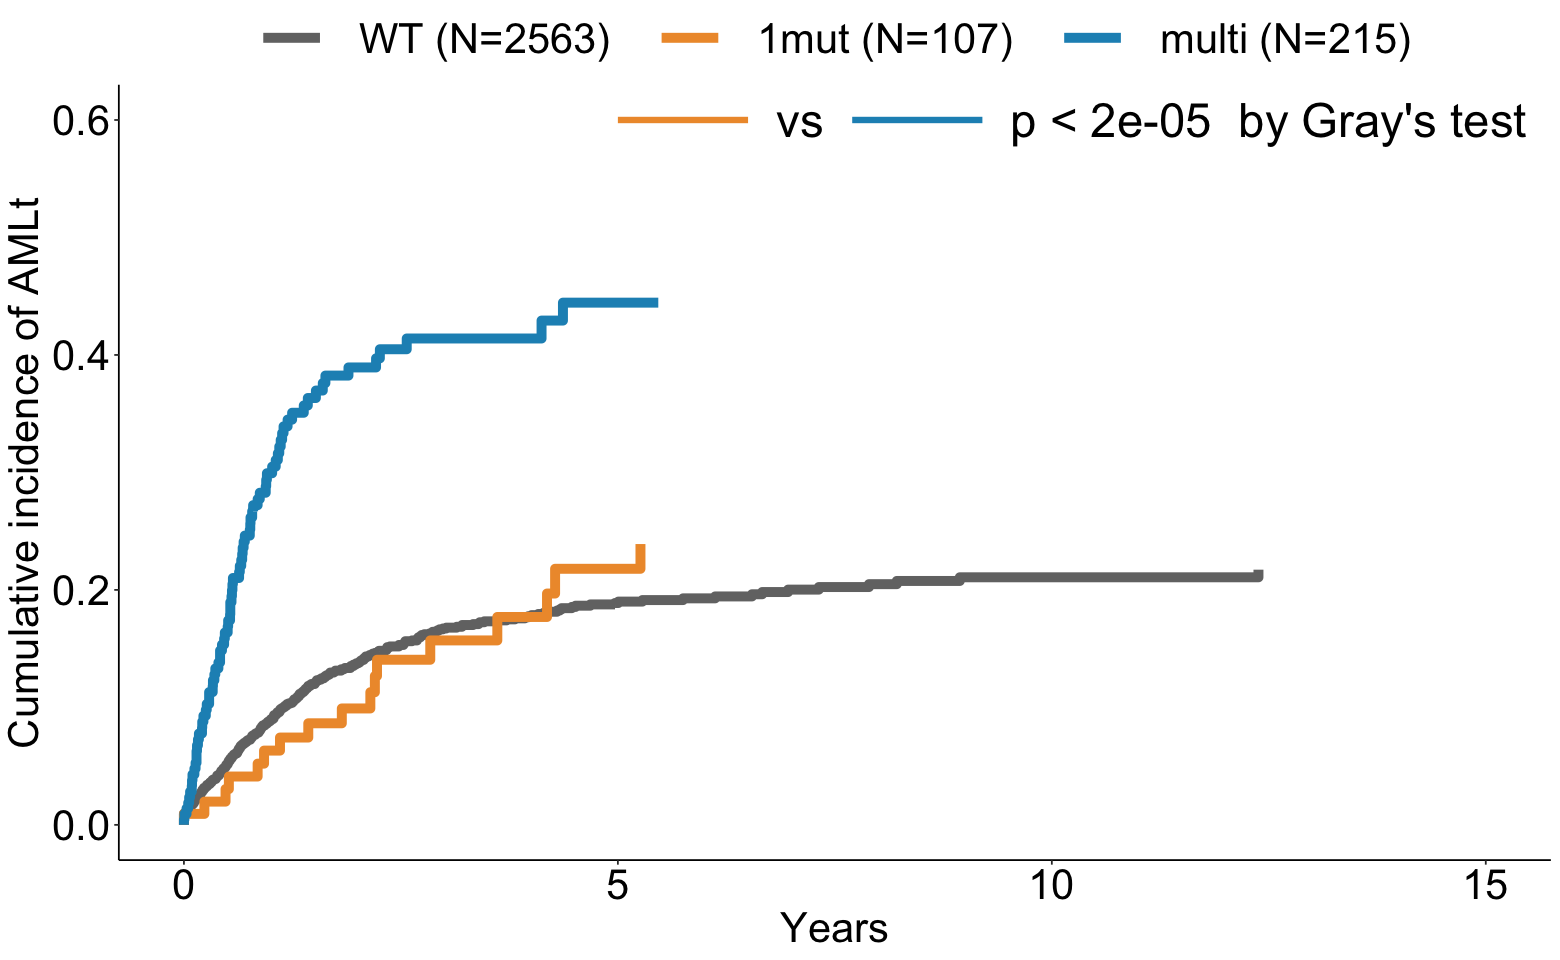

In [66]:
options(repr.plot.width=13, repr.plot.height=8)
tmp = dd
tmp = tmp[ !grepl("AML",tmp$WHO_2016) , ] # EXCLUDE AML PATIENTS for AMLt analysis
cmfit = with(tmp,cuminc(comp_sample_years,comp_status,allelic_status,cencode="censor"))
tlg = table(tmp$allelic_status[!is.na(tmp$comp_sample_years)])
myleg = paste0(" ", names(tlg)," (N=",tlg,")  ")

cmfit.test = with(tmp[tmp$allelic_status!="WT",],cuminc(comp_sample_years,comp_status,allelic_status,cencode="censor"))
ptAMLt = cmfit.test$Tests["aml","pv"]

ggComp = gg_competingrisks.cuminc(cmfit,line.size=2.8,group.levels=c("WT","1mut","multi")) +
themePP + topleg + xlim(c(0,15)) + theme(legend.key.width = unit(1.5,"cm")) +
scale_color_manual(values=c("#737373",col.status), labels=myleg) + nolegtitle +
annotate("segment",color=col.status[1],x=5,xend=6.5,y=0.6,yend=0.6,size=1.8) +
annotate("text",label="vs",y=0.6,x=7.1,size=10) +
annotate("segment",color=col.status[2],x=7.7,xend=9.2,y=0.6,yend=0.6,size=1.8) +
#annotate("text",label=expression(paste(p,"<",10^-4," by Gray's test")),x=12.5,y=0.6,size=10)
annotate("text",label=paste("p","<",signif(ptAMLt,2)," by Gray's test"),x=12.5,y=0.6,size=10)

ggComp

## Fig 3c: Cox model for OS

Multivariate Cox model of OS with state-of-the-art IPSS-R variables and TP53 allelic state.

In [67]:
# Complete cases
i.complete.clinical = !is.na(dd$AGE)&!is.na(dd$HB)&!is.na(dd$PLT)&!is.na(dd$ANC)&!is.na(dd$BM_BLAST)&!is.na(dd$CYTO_IPSSR)
i.complete.os = i.complete.clinical & !is.na(dd$os_sample_years) & !is.na(dd$os_status)
i.complete.aml = i.complete.clinical & !is.na(dd$aml_sample_years) & !is.na(dd$aml_status)

In [68]:
dd$CYTOGENETIC_IPSSR = dd$CYTO_IPSSR
dd$CYTOGENETIC_IPSSR = factor(dd$CYTOGENETIC_IPSSR, levels=c("INT","VERY-GOOD","GOOD","POOR","VERY-POOR"))
tmp.os = dd[i.complete.os,]

In [69]:
div_mean_calcul <- function(x) {
    return(x/mean(x))
}
tmp.os$AGEs = tmp.os$AGE/10
tmp.os$BMz = div_mean_calcul(tmp.os$BM_BLAST)
tmp.os$ANCz = div_mean_calcul(tmp.os$ANC)
tmp.os$PLTz = div_mean_calcul(tmp.os$PLT)
tmp.os$HBz = div_mean_calcul(tmp.os$HB)

In [70]:
model.os <- coxph( Surv(os_sample_years, os_status) ~ AGEs + HBz + PLTz + ANCz + BMz + CYTOGENETIC_IPSSR + allelic_status,
                data = tmp.os)

In [71]:
summary(model.os)

Call:
coxph(formula = Surv(os_sample_years, os_status) ~ AGEs + HBz + 
    PLTz + ANCz + BMz + CYTOGENETIC_IPSSR + allelic_status, data = tmp.os)

  n= 2739, number of events= 1306 

                                coef exp(coef)  se(coef)       z Pr(>|z|)    
AGEs                        0.328097  1.388324  0.026105  12.568  < 2e-16 ***
HBz                        -1.773847  0.169679  0.146021 -12.148  < 2e-16 ***
PLTz                       -0.320966  0.725448  0.041233  -7.784 7.01e-15 ***
ANCz                        0.067022  1.069319  0.008515   7.871 3.52e-15 ***
BMz                         0.219725  1.245734  0.018831  11.668  < 2e-16 ***
CYTOGENETIC_IPSSRVERY-GOOD -0.479567  0.619052  0.178275  -2.690 0.007144 ** 
CYTOGENETIC_IPSSRGOOD      -0.336389  0.714345  0.078040  -4.310 1.63e-05 ***
CYTOGENETIC_IPSSRPOOR       0.517947  1.678578  0.128671   4.025 5.69e-05 ***
CYTOGENETIC_IPSSRVERY-POOR  0.479151  1.614702  0.141714   3.381 0.000722 ***
allelic_status1mut         -0.020013 

In [72]:
x <- summary(model.os)
res.df.os = as.data.frame(cbind(x$coef[,c(2,5)],x$conf.int[,c(3,4)]))
myvariable = c("Age","Hemoglobin","Platelets","ANC","Bone marrow blasts",
                        "Cytogenetic very-good","Cytogenetic good","Cytogenetic poor","Cytogenetic very-poor",
                        "TP53 mono-allelic","TP53 multi-hit"
                       )
res.df.os$variable = factor(myvariable, levels=rev(myvariable))
colnames(res.df.os) = c("HR","pval","HRlow","HRhigh","variable")
res.df.os$annot = sapply(res.df.os$pval, pval_to_signif_code)
res.df.os$type = c("age",rep("clin",4),rep("cyto",4),"mono","multi")

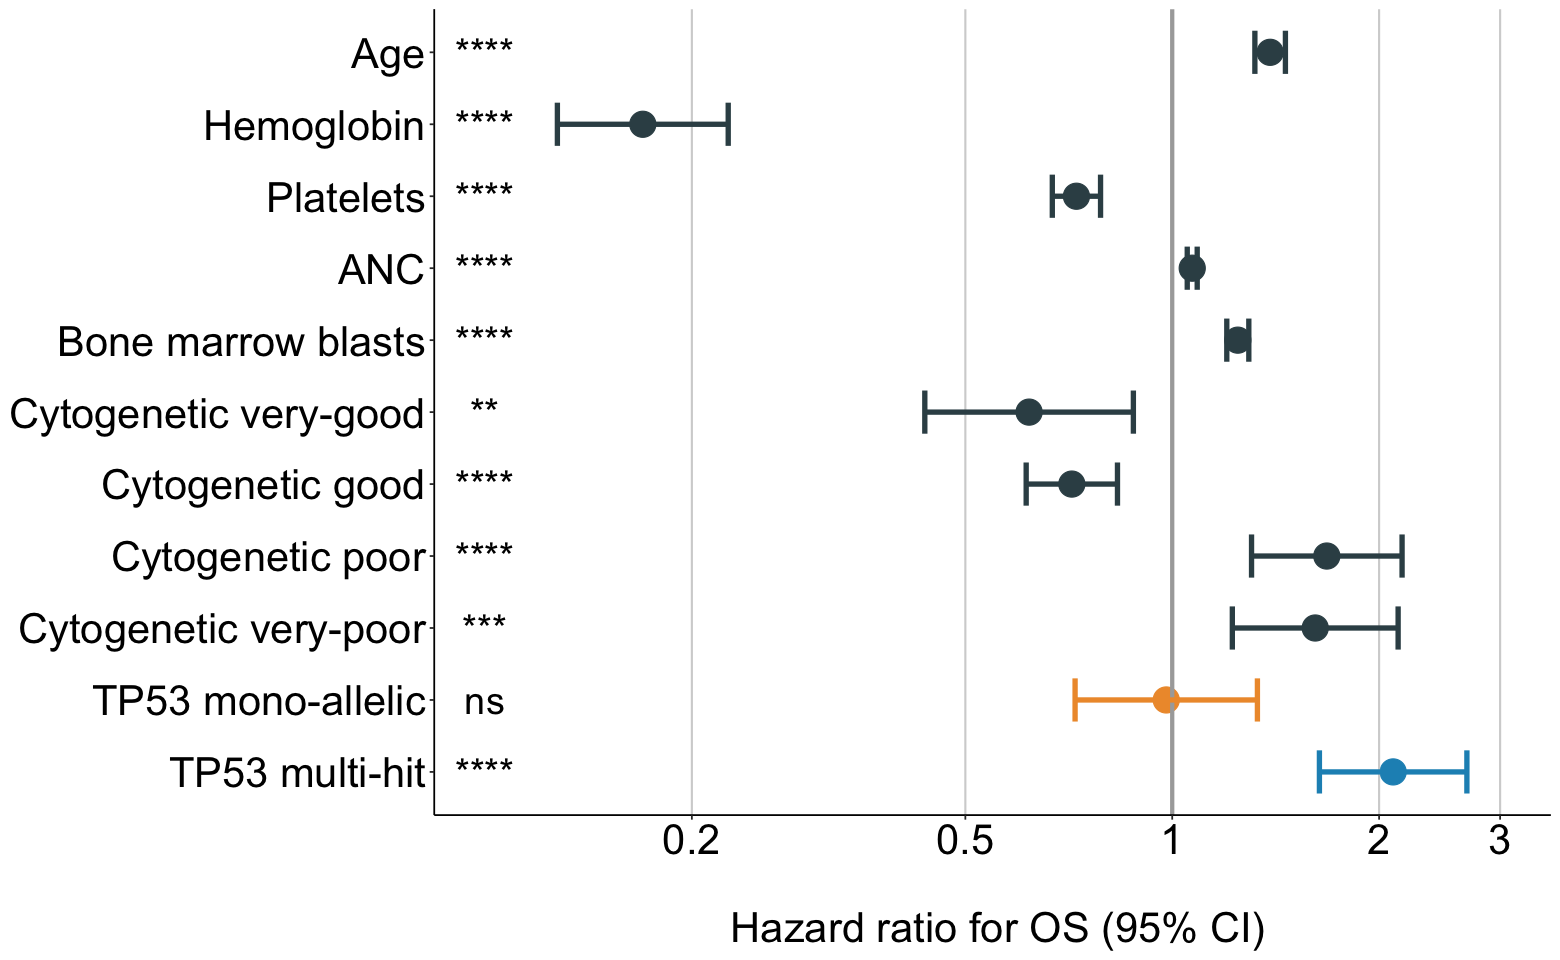

In [74]:
gos1 = ggplot(res.df.os, aes(x=variable,y=HR,colour=type)) + 
geom_point(size=7) + 
geom_hline(yintercept=1,color="darkgrey",size=1.2) + 
geom_hline(yintercept=0.5,color="lightgrey",size=0.6) + 
geom_hline(yintercept=0.2,color="lightgrey",size=0.6) + 
geom_hline(yintercept=2,color="lightgrey",size=0.6) + 
geom_hline(yintercept=3,color="lightgrey",size=0.6) +
geom_errorbar(aes(ymin=HRlow,ymax=HRhigh,colour=type),size=1.5,width=0.6) + 
geom_text(aes(x=variable,y=0.1,label=annot),col="black",size=8) + 
scale_y_log10(breaks=c(0.2,0.5,1,2,3),labels=c(0.2,0.5,1,2,3)) + ##737373
scale_colour_manual(values=c(rep("#374E55FF",3),col.status)) +
themePP + noytitle + ylab("\n Hazard ratio for OS (95% CI)") + coord_flip() +  noleg

gos1

## Fig 3d: Cause-specific Cox model for AMLt

Multivariate cause-specific Cox model of OS with state-of-the-art IPSS-R variables and TP53 allelic state.

In [75]:
# YOU DO NOT INCLUDE AML SAMPLES WHEN EVALUATED PREGRESSION MDS - AML
tmp.aml = dd[i.complete.aml,]
tmp.aml = tmp.aml[ !grepl("AML",tmp.aml$WHO_2016) , ]
tmp.aml$AGEs = tmp.aml$AGE/10
tmp.aml$BMz = div_mean_calcul(tmp.aml$BM_BLAST)
tmp.aml$ANCz = div_mean_calcul(tmp.aml$ANC)
tmp.aml$PLTz = div_mean_calcul(tmp.aml$PLT)
tmp.aml$HBz = div_mean_calcul(tmp.aml$HB)
model.aml <- coxph( Surv(aml_sample_years, aml_status) ~ AGEs + HBz + PLTz + ANCz + BMz + CYTOGENETIC_IPSSR + allelic_status,
                data = tmp.aml)

In [76]:
summary(model.aml)

Call:
coxph(formula = Surv(aml_sample_years, aml_status) ~ AGEs + HBz + 
    PLTz + ANCz + BMz + CYTOGENETIC_IPSSR + allelic_status, data = tmp.aml)

  n= 2492, number of events= 421 

                                coef exp(coef)  se(coef)      z Pr(>|z|)    
AGEs                        0.006671  1.006694  0.040315  0.165  0.86856    
HBz                        -0.808326  0.445603  0.251394 -3.215  0.00130 ** 
PLTz                       -0.206783  0.813196  0.071592 -2.888  0.00387 ** 
ANCz                        0.061938  1.063896  0.012937  4.788 1.69e-06 ***
BMz                         0.645372  1.906696  0.038389 16.811  < 2e-16 ***
CYTOGENETIC_IPSSRVERY-GOOD -0.731728  0.481077  0.376253 -1.945  0.05180 .  
CYTOGENETIC_IPSSRGOOD      -0.254837  0.775042  0.136181 -1.871  0.06130 .  
CYTOGENETIC_IPSSRPOOR       0.185644  1.203993  0.228372  0.813  0.41628    
CYTOGENETIC_IPSSRVERY-POOR -0.303313  0.738368  0.260275 -1.165  0.24388    
allelic_status1mut         -0.082765  0.92056

In [77]:
x <- summary(model.aml)
res.df.aml = as.data.frame(cbind(x$coef[,c(2,5)],x$conf.int[,c(3,4)]))
res.df.aml$variable = factor(myvariable, levels=rev(myvariable))
colnames(res.df.aml) = c("HR","pval","HRlow","HRhigh","variable")
res.df.aml$annot = sapply(res.df.aml$pval, pval_to_signif_code)
res.df.aml$type = c("age",rep("clin",4),rep("cyto",4),"mono","multi")

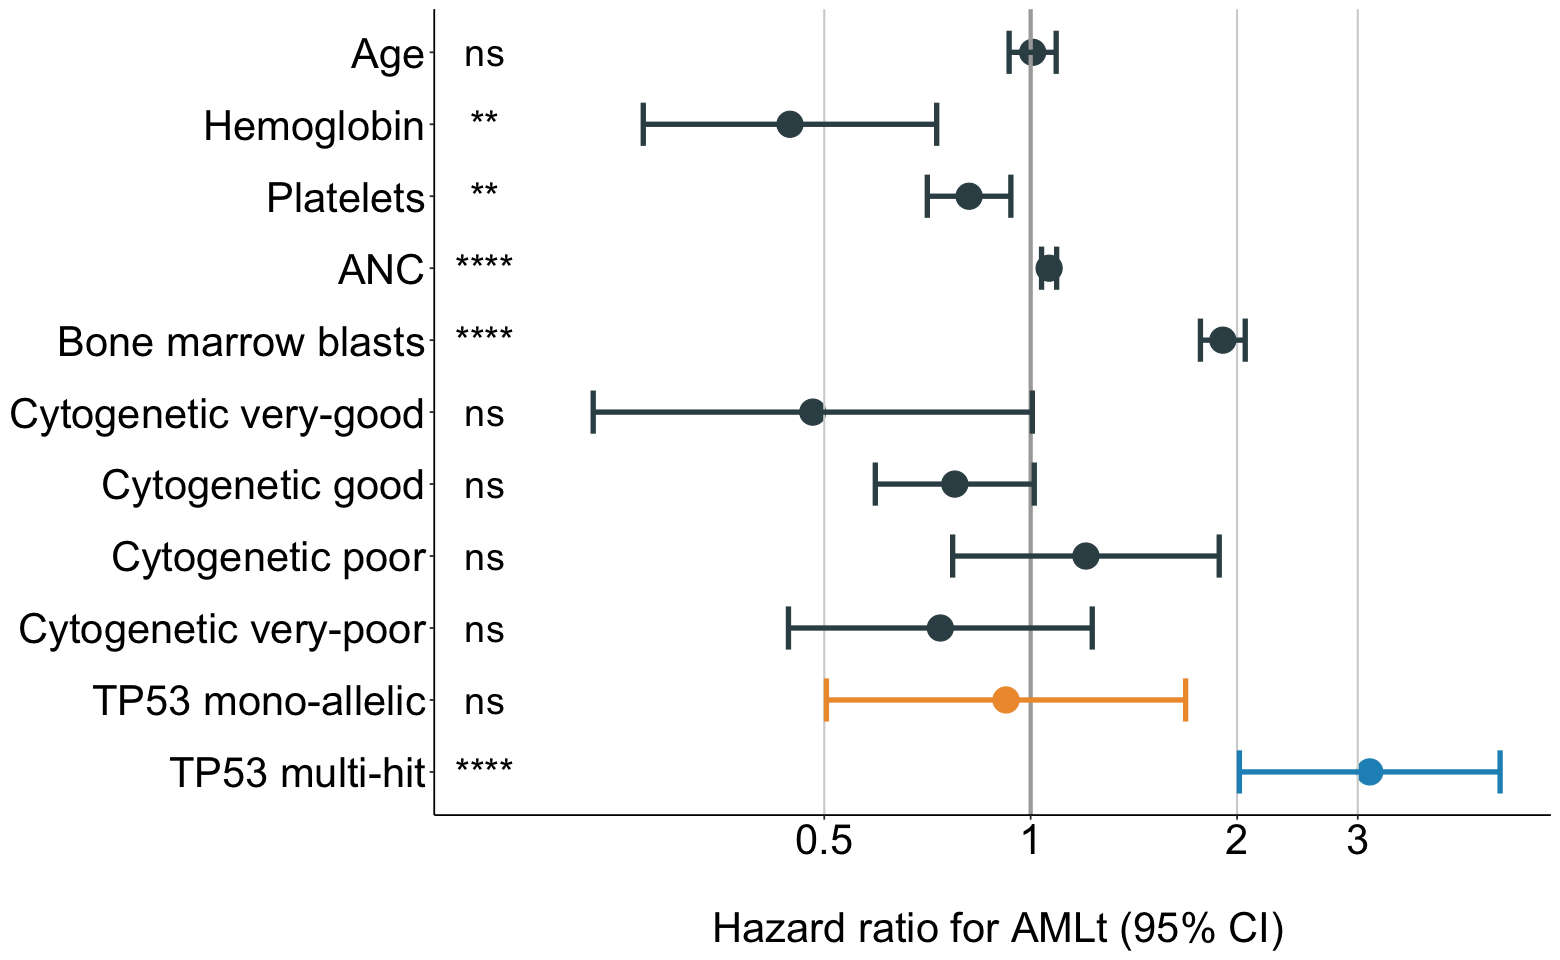

In [78]:
gaml1 = ggplot(res.df.aml, aes(x=variable,y=HR,colour=type)) + 
geom_point(size=7) + 
geom_hline(yintercept=1,color="darkgrey",size=1.2) + 
geom_hline(yintercept=0.5,color="lightgrey",size=0.6) + geom_hline(yintercept=2,color="lightgrey",size=0.6) + 
geom_hline(yintercept=3,color="lightgrey",size=0.6) +
geom_errorbar(aes(ymin=HRlow,ymax=HRhigh,colour=type),size=1.5,width=0.6) + 
geom_text(aes(x=variable,y=0.16,label=annot),col="black",size=8) + 
scale_y_log10(breaks=c(0.5,1,2,3),labels=c(0.5,1,2,3)) + ##737373
scale_colour_manual(values=c(rep("#374E55FF",3),col.status)) +
themePP + noytitle + ylab("\n Hazard ratio for AMLt (95% CI)") + coord_flip() +  noleg

gaml1

## Fig 3d alternative: competing risk Fine and Gray model for AMLt

An alternative modeling approach to cause-specific Cox model for AML transformation in the competing risk model proposed by Fine and Gray,
where death without transformation is modeled as a competing risk.

We show here the results of the Fine and Gray approach for AMLt with state-of-the-art IPSS-R variables and TP53 allelic state.

In [79]:
tmp.aml.crr = tmp.aml[!is.na(tmp.aml$comp_status),]
tmp.aml.crr = tmp.aml.crr[!is.na(tmp.aml.crr$comp_sample_years),]
tmp.aml.crr.cov = cbind(tmp.aml.crr[,c("AGEs","HBz","PLTz","ANCz","BMz")] , model.matrix(~0 + CYTOGENETIC_IPSSR, data=tmp.aml.crr)[,-1] , model.matrix(~0 + allelic_status, data=tmp.aml.crr)[,-1])
colnames(tmp.aml.crr.cov)[10:11] = c("TP53mono","TP53multi")
res.aml.crr = crr(ftime=tmp.aml.crr$comp_sample_years, fstatus=as.vector(tmp.aml.crr$comp_status),
    cov1=tmp.aml.crr.cov,
    failcode="aml",
    cencode="censor"
   )

In [80]:
summary(res.aml.crr)

Competing Risks Regression

Call:
crr(ftime = tmp.aml.crr$comp_sample_years, fstatus = as.vector(tmp.aml.crr$comp_status), 
    cov1 = tmp.aml.crr.cov, failcode = "aml", cencode = "censor")

                              coef exp(coef) se(coef)       z p-value
AGEs                       -0.1034     0.902   0.0364 -2.8380 4.5e-03
HBz                        -0.1731     0.841   0.2529 -0.6846 4.9e-01
PLTz                       -0.0851     0.918   0.0714 -1.1923 2.3e-01
ANCz                        0.0540     1.055   0.0118  4.5956 4.3e-06
BMz                         0.5885     1.801   0.0395 14.8897 0.0e+00
CYTOGENETIC_IPSSRVERY-GOOD -0.5876     0.556   0.3676 -1.5987 1.1e-01
CYTOGENETIC_IPSSRGOOD      -0.2125     0.809   0.1373 -1.5478 1.2e-01
CYTOGENETIC_IPSSRPOOR      -0.0137     0.986   0.2323 -0.0589 9.5e-01
CYTOGENETIC_IPSSRVERY-POOR -0.3537     0.702   0.2830 -1.2498 2.1e-01
TP53mono                   -0.0661     0.936   0.2976 -0.2222 8.2e-01
TP53multi                   0.7725     

In [81]:
xx = summary(res.aml.crr)
res.df.aml.crr = as.data.frame(cbind(xx$coef[,c(2,5)],xx$conf.int[,c(3,4)]))
res.df.aml.crr$variable = factor(myvariable, levels=rev(myvariable))
colnames(res.df.aml.crr) = c("HR","pval","HRlow","HRhigh","variable")
res.df.aml.crr$annot = sapply(res.df.aml.crr$pval, pval_to_signif_code)
res.df.aml.crr$type = c("age",rep("clin",4),rep("cyto",4),"mono","multi")

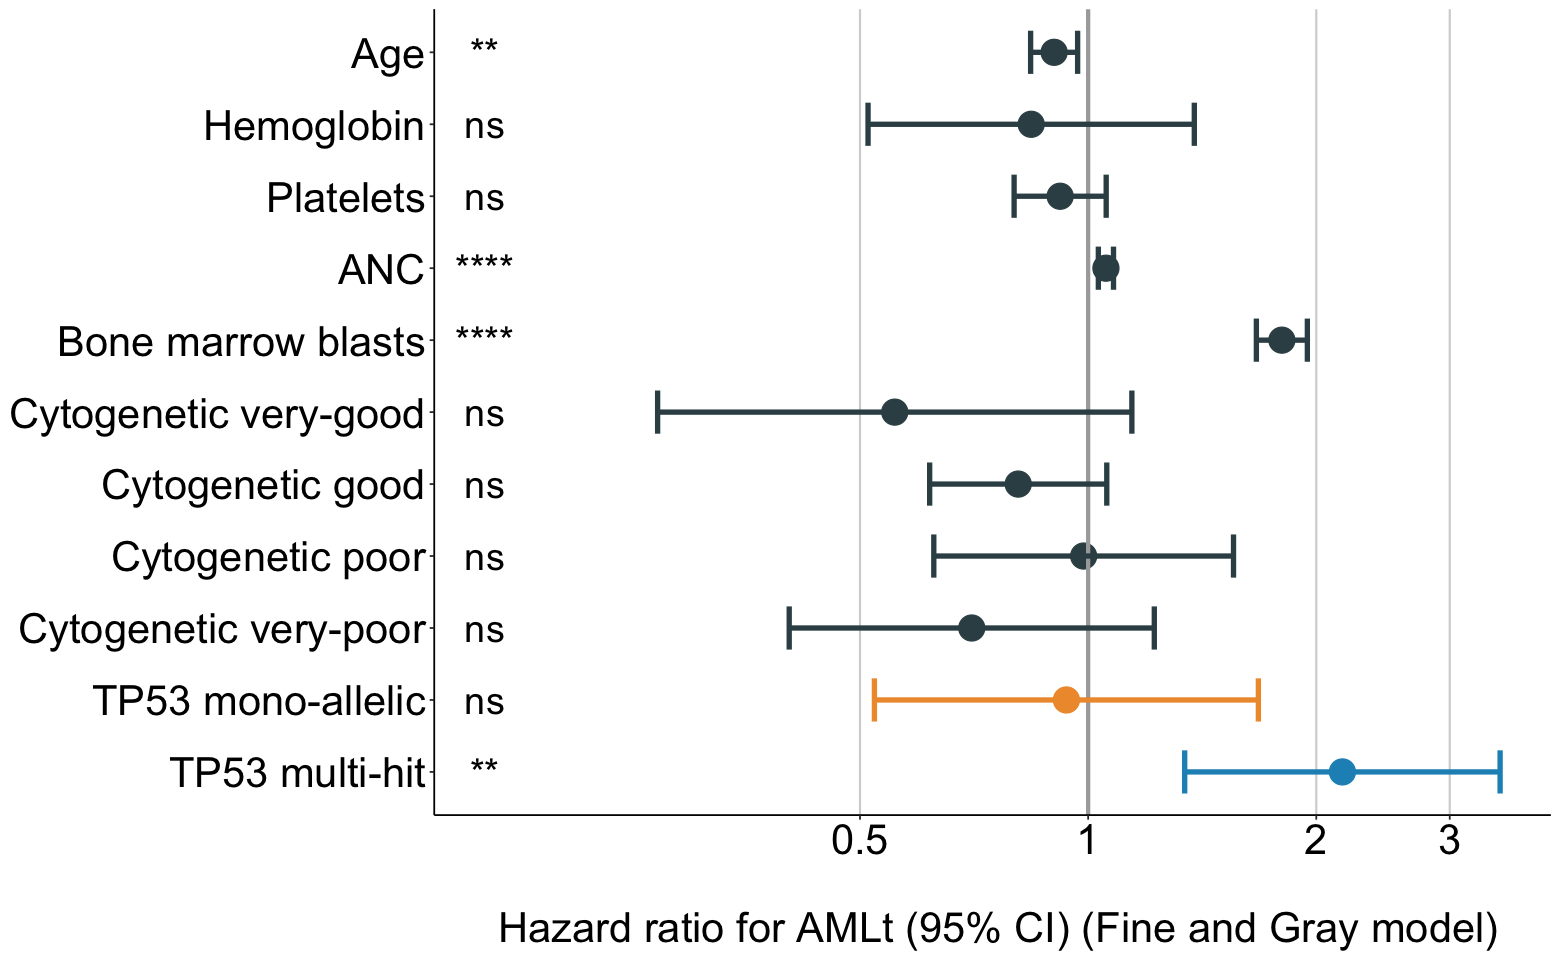

In [82]:
gaml1.crr = ggplot(res.df.aml.crr, aes(x=variable,y=HR,colour=type)) + 
geom_point(size=7) + 
geom_hline(yintercept=1,color="darkgrey",size=1.2) + 
geom_hline(yintercept=0.5,color="lightgrey",size=0.6) + geom_hline(yintercept=2,color="lightgrey",size=0.6) + 
geom_hline(yintercept=3,color="lightgrey",size=0.6) +
geom_errorbar(aes(ymin=HRlow,ymax=HRhigh,colour=type),size=1.5,width=0.6) + 
geom_text(aes(x=variable,y=0.16,label=annot),col="black",size=8) + 
scale_y_log10(breaks=c(0.5,1,2,3),labels=c(0.5,1,2,3)) + ##737373
scale_colour_manual(values=c(rep("#374E55FF",3),col.status)) +
themePP + noytitle + ylab("\n Hazard ratio for AMLt (95% CI) (Fine and Gray model)") + coord_flip() +  noleg
gaml1.crr

# Main Figure 4

## Fig 4a: therapy-related MDS

In [83]:
tmp = dd[which(dd$MDS_TYPE!="secondary"),] # too few number for secondary mds for reliable analysis
tmp$mds_type = "de-novo"
tmp$mds_type[tmp$MDS_TYPE%in%c("therapy_related")] = "therapy-related"
table(tmp$mds_type,tmp$allelic_status)

                 
                    WT 1mut multi
  de-novo         2570  101   184
  therapy-related  167   10    52

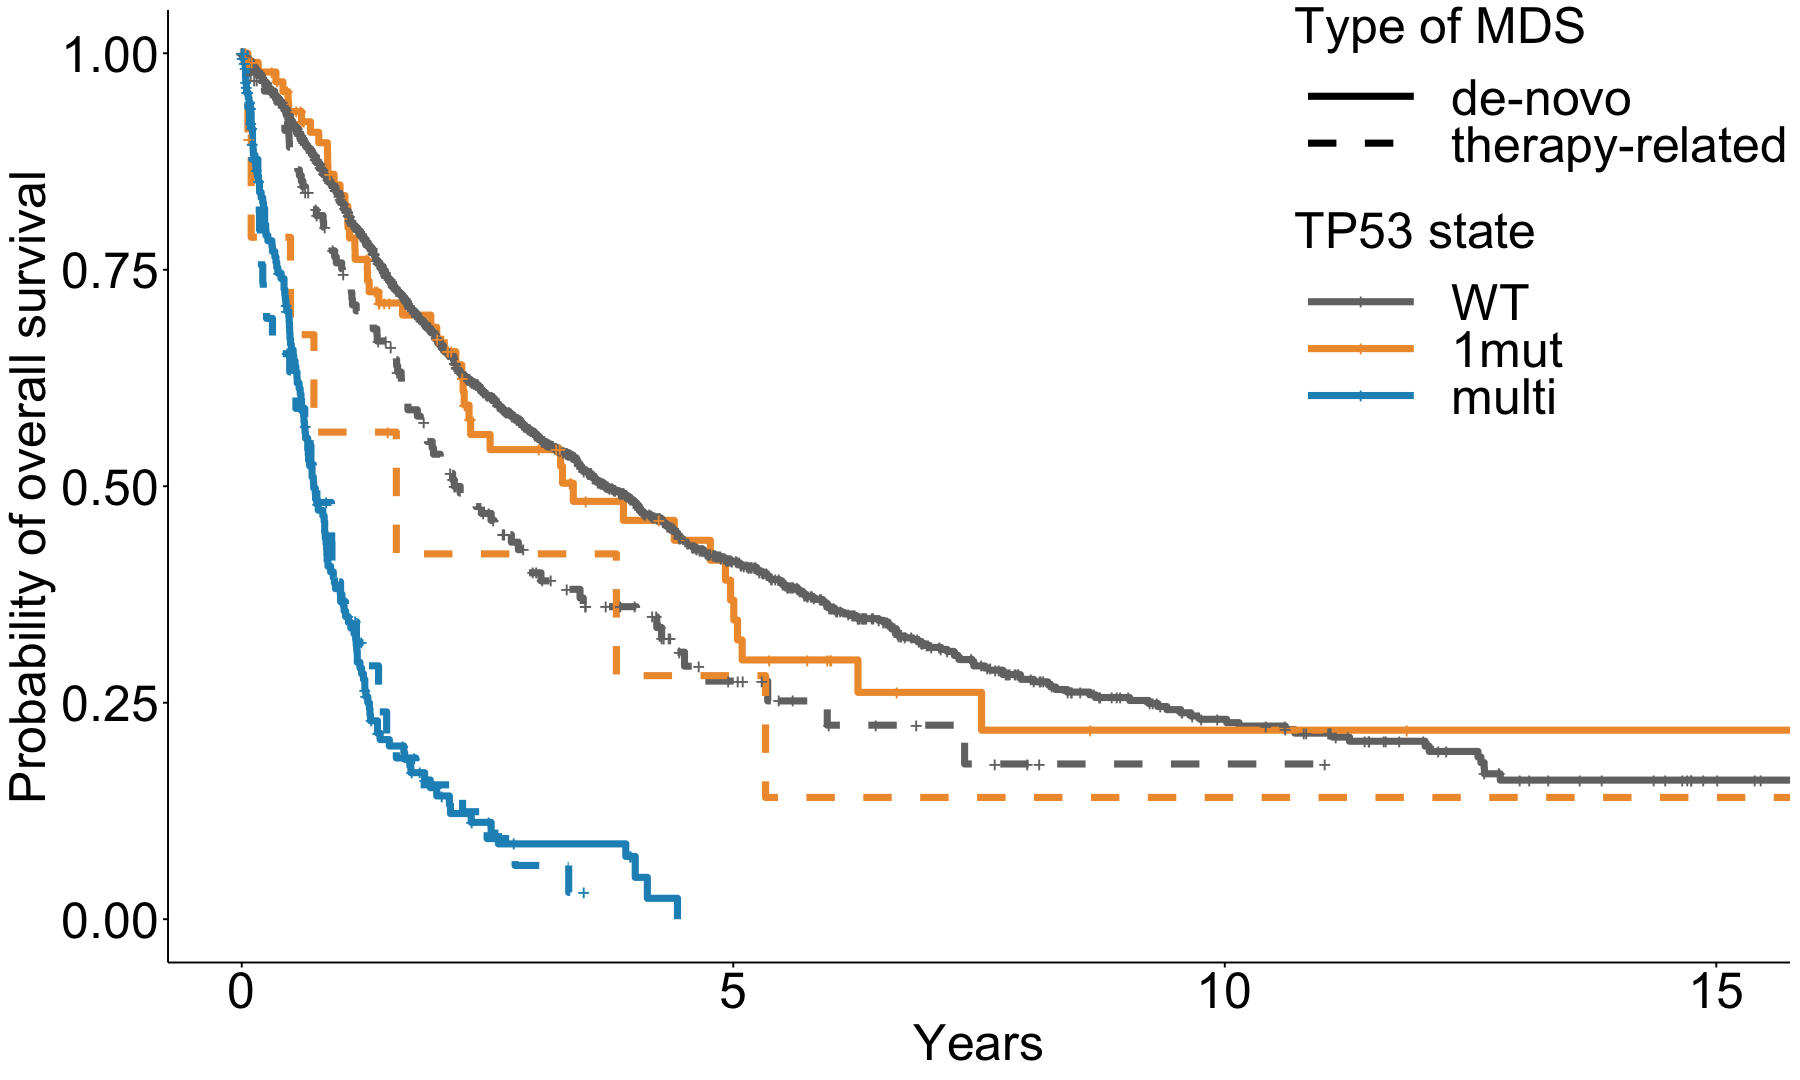

In [84]:
options(repr.plot.width=15, repr.plot.height=9)

ff = as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status + mds_type"))
kmfit = survfit(ff,data=tmp)
kmfit$call$formula <- ff

gg.therapy.OS = ggsurvplot(kmfit, data=tmp,legend.title=c("TP53 state"),
                                conf.int=F, size=2.0, xlim=c(0,15),
                                linetype="mds_type",color="allelic_status",breaks=5,
                                font.x=30, font.y=30, font.tickslab=30, font.legend=30
                               )$plot +
theme(legend.key.width = unit(2.8,"cm")) + theme(legend.box = "vertical",legend.position = c(0.85,0.79)) + 
scale_color_manual(values=c("#737373",col.status)) + ylab("Probability of overall survival") + xlab("Years") + 
scale_linetype_manual(values=c("solid","dashed","dotted"),name="Type of MDS")

gg.therapy.OS

In [85]:
# Pairwise Log-rank test p-values:
pt.therapy.os = pairwise_survdiff(formula=ff, data=tmp, p.adjust.method = "none")
pt.therapy.os$p.value

allelic_status=WT, mds_type=de-novo        
allelic_status=WT, mds_type=therapy-related    3.088902e-04                               
allelic_status=1mut, mds_type=de-novo          6.476612e-01                               
allelic_status=1mut, mds_type=therapy-related  2.199521e-01                               
allelic_status=multi, mds_type=de-novo         3.366178e-83                               
allelic_status=multi, mds_type=therapy-related 3.961508e-30                               
                                               allelic_status=WT, mds_type=therapy-related
allelic_status=WT, mds_type=therapy-related              NA                               
allelic_status=1mut, mds_type=de-novo          1.056654e-01                               
allelic_status=1mut, mds_type=therapy-related  4.621446e-01                               
allelic_status=multi, mds_type=de-novo         3.131250e-18                               
allelic_status=multi, mds_type=therapy-related 6.289584e-11                               
                                               allelic_status=1mut, mds_type=de-novo        
allelic_status=WT, mds_type=therapy-related              NA                                 
allelic_status=1mut, mds_type=de-novo                    NA                                 
allelic_status=1mut, mds_type=therapy-related  2.895056e-01                                 
allelic_status=multi, mds_type=de-novo         6.408046e-18                                 
allelic_status=multi, mds_type=therapy-related 1.055195e-12                                 
                                               allelic_status=1mut, mds_type=therapy-related
allelic_status=WT, mds_type=therapy-related            NA                                   
allelic_status=1mut, mds_type=de-novo                  NA                                   
allelic_status=1mut, mds_type=therapy-related          NA                                   
allelic_status=multi, mds_type=de-novo         0.03421598                                   
allelic_status=multi, mds_type=therapy-related 0.04340365                                   
                                               allelic_status=multi, mds_type=de-novo        
allelic_status=WT, mds_type=therapy-related           NA                                     
allelic_status=1mut, mds_type=de-novo                 NA                                     
allelic_status=1mut, mds_type=therapy-related         NA                                     
allelic_status=multi, mds_type=de-novo                NA                                     
allelic_status=multi, mds_type=therapy-related 0.8802042

In [86]:
# Hazard Ratio multi vs. 1mut in t-MDS setting:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=tmp[tmp$allelic_status%in%c("1mut","multi") & tmp$mds_type=="therapy-related",]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = tmp[tmp$allelic_status %in% c("1mut", 
    "multi") & tmp$mds_type == "therapy-related", ])

  n= 62, number of events= 49 

                       coef exp(coef) se(coef)      z Pr(>|z|)  
allelic_status1mut  -0.9394    0.3909   0.4828 -1.946   0.0517 .
allelic_statusmulti      NA        NA   0.0000     NA       NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut     0.3909      2.558    0.1517     1.007
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.534  (se = 0.035 )
Likelihood ratio test= 4.74  on 1 df,   p=0.03
Wald test            = 3.79  on 1 df,   p=0.05
Score (logrank) test = 4.04  on 1 df,   p=0.04


In [87]:
# Hazard Ratio multi vs. WT in t-MDS setting:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=tmp[tmp$allelic_status%in%c("WT","multi") & tmp$mds_type=="therapy-related",]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = tmp[tmp$allelic_status %in% c("WT", 
    "multi") & tmp$mds_type == "therapy-related", ])

  n= 219, number of events= 140 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
allelic_status1mut      NA        NA   0.0000    NA       NA    
allelic_statusmulti 1.1987    3.3160   0.1936 6.193 5.91e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut         NA         NA        NA        NA
allelic_statusmulti     3.316     0.3016     2.269     4.846

Concordance= 0.611  (se = 0.019 )
Likelihood ratio test= 32.79  on 1 df,   p=1e-08
Wald test            = 38.35  on 1 df,   p=6e-10
Score (logrank) test = 42.77  on 1 df,   p=6e-11


In [88]:
# Hazard Ratio 1mut vs. WT in t-MDS setting:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=tmp[tmp$allelic_status%in%c("WT","1mut") & tmp$mds_type=="therapy-related",]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = tmp[tmp$allelic_status %in% c("WT", 
    "1mut") & tmp$mds_type == "therapy-related", ])

  n= 177, number of events= 105 

                      coef exp(coef) se(coef)     z Pr(>|z|)
allelic_status1mut  0.2901    1.3366   0.3932 0.738    0.461
allelic_statusmulti     NA        NA   0.0000    NA       NA

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut      1.337     0.7482    0.6184     2.889
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.513  (se = 0.015 )
Likelihood ratio test= 0.5  on 1 df,   p=0.5
Wald test            = 0.54  on 1 df,   p=0.5
Score (logrank) test = 0.55  on 1 df,   p=0.5


## Fig 4b: OS after HMA

We consider OS after start of HMA therapy per TP53 allelic state.

HMA: hypomethylating agent

In [89]:
table(dd$hma, dd$allelic_status)

   
      WT 1mut multi
  0 2421  101   131
  1  525   24   122

In [90]:
tmp = dd[dd$hma==1,]
ff = as.formula(paste("Surv(os_hma_years,os_status)~","allelic_status"))
kmfit = survfit(ff,data=tmp)
kmfit$call$formula <- ff

myleg = paste0(gsub("allelic_status=","",names(kmfit$strata))," (N=",kmfit$n,")")
gg.hma.OS = ggsurvplot(kmfit, data=tmp,legend.title=c("TP53 state"),legend.labs=myleg,
                                conf.int=F, size=2.5, xlim=c(0,7),break.time.by=1,
                                color="allelic_status", palette=c("#737373",col.status),
                                breaks=2,
                                font.x=30, font.y=30, font.tickslab=30, font.legend=30,
                                tables.col="allelic_status",   
                                risk.table=TRUE,risk.table.height=0.25,risk.table.fontsize=10,tables.y.text=FALSE#,tables.theme=theme_cleantable()
                               )
gg.hma.OS.plot = gg.hma.OS$plot + theme(legend.key.width = unit(2,"cm")) + ylab("Probability of overall survival") + xlab("Years since HMA")
gg.hma.OS.table = gg.hma.OS$table + ylab("\n") + noleg + theme(axis.title.x=element_blank(),axis.text.x=element_blank()) + noleg + theme(axis.title.y = element_text(size = 30))
pt.hma.os = pairwise_survdiff(formula=ff, data=tmp, p.adjust.method = "none")

pvvb = pt.hma.os$p.value[2,2]
gg.hma.OS.plot = gg.hma.OS.plot  + 
annotate("segment",color=col.status[1],x=4,xend=4.5,y=1,yend=1,size=1.3) + 
annotate("text",label="vs",y=1,x=5,size=7) +
annotate("segment",color=col.status[2],x=5.5,xend=6,y=1,yend=1,size=1.3) +
annotate("text",label=paste("p=",signif(pvvb,2)),x=6.5,y=1,size=7)

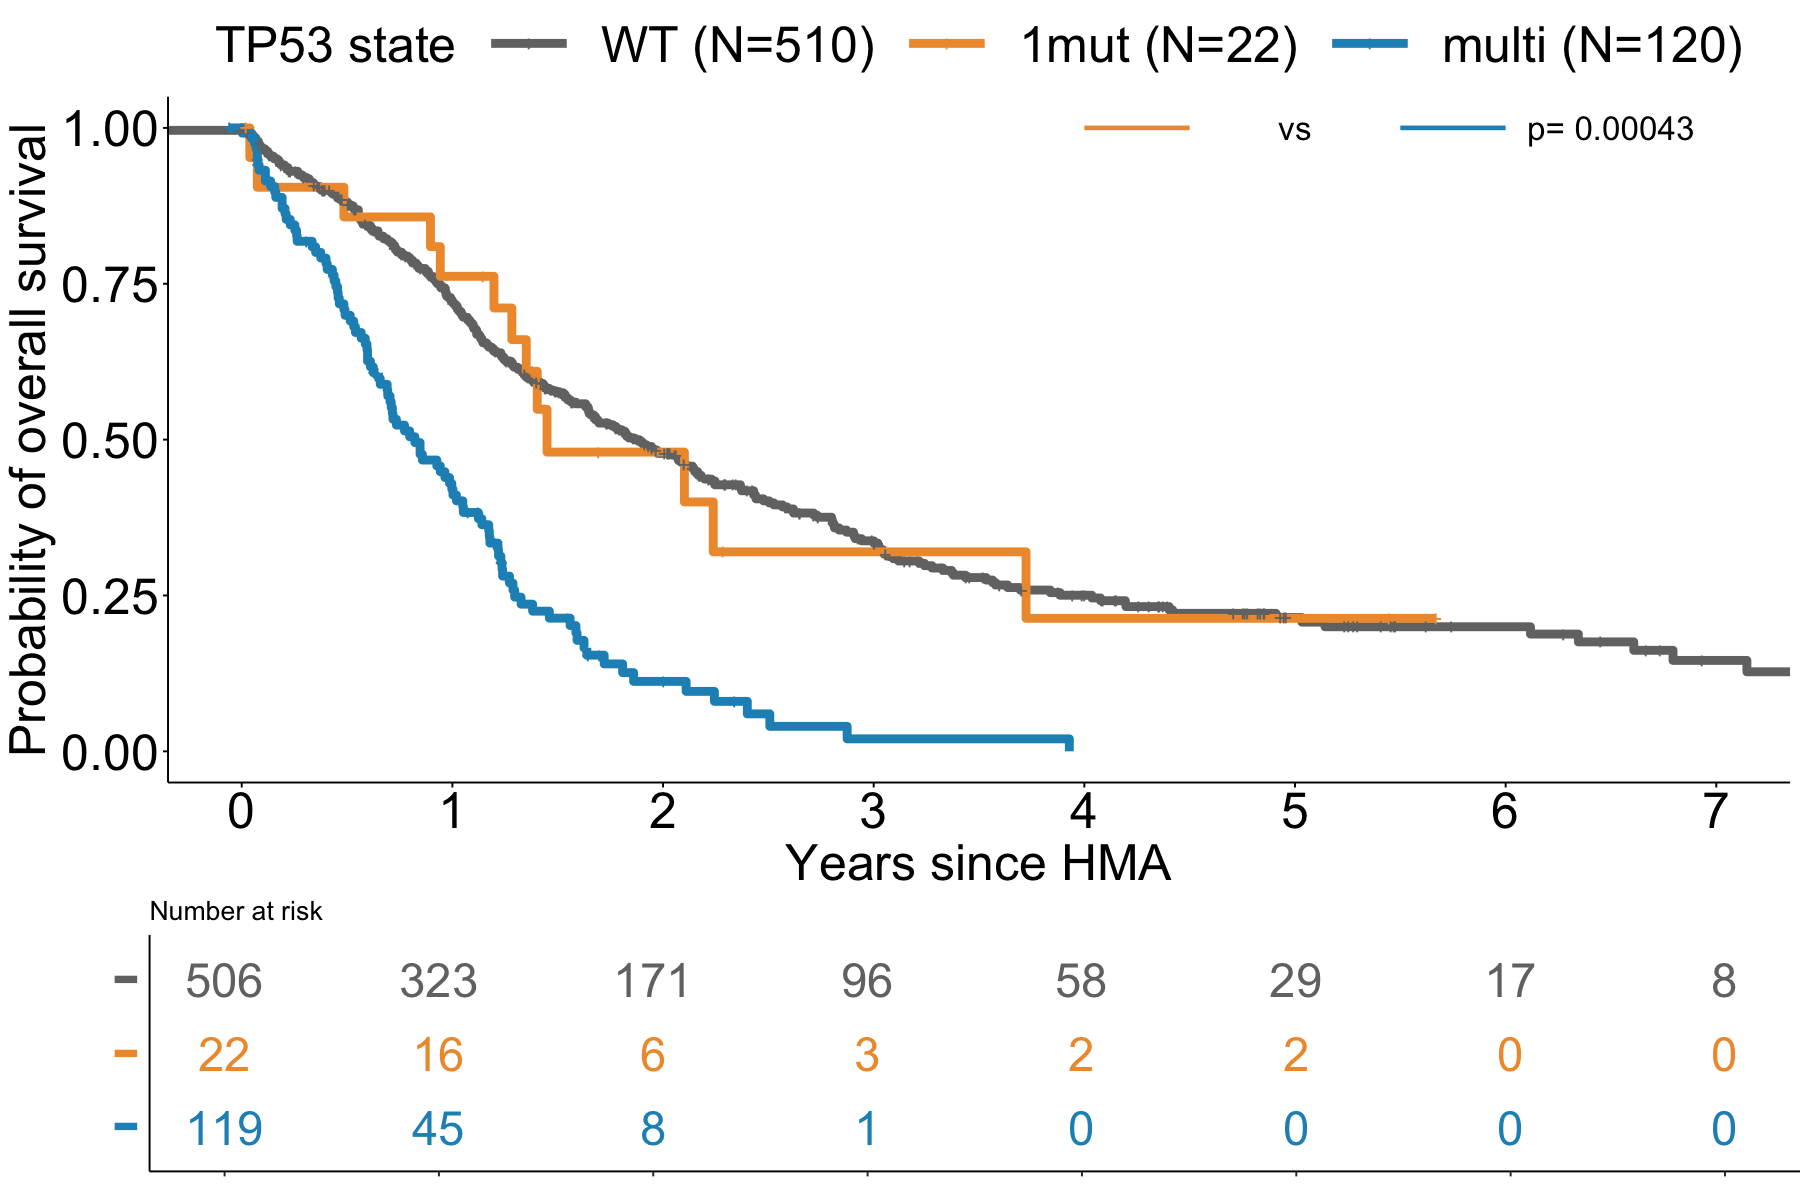

In [91]:
options(repr.plot.width=15, repr.plot.height=10)
ggHMA = ggarrange(gg.hma.OS.plot , gg.hma.OS.table+theme(plot.margin = unit(c(0, 0, 0.5, 0.15), "cm")), 
          nrow=2, ncol=1,
          heights=c(3,1)
         )
ggHMA

In [92]:
# Pairwise Log-rank test p-values:
pt.hma.os$p.value

WT           1mut        
1mut  9.706093e-01           NA
multi 1.535328e-19 0.0004337702

In [93]:
# Hazard Ratio multi vs. 1mut after HMA:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=tmp[tmp$allelic_status%in%c("1mut","multi"),]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = tmp[tmp$allelic_status %in% c("1mut", 
    "multi"), ])

  n= 145, number of events= 114 
   (1 observation deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)    
allelic_status1mut  -1.1225    0.3255   0.2966 -3.785 0.000154 ***
allelic_statusmulti      NA        NA   0.0000     NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut     0.3255      3.072     0.182    0.5821
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.564  (se = 0.023 )
Likelihood ratio test= 18.19  on 1 df,   p=2e-05
Wald test            = 14.32  on 1 df,   p=2e-04
Score (logrank) test = 15.55  on 1 df,   p=8e-05


## Fig 4c: OS after Lenalidomid

We consider OS after start of Lenalidomid therapy per TP53 allelic state, restricted to del5q patients.

In [94]:
tmp = cbind(dd, ddcyto[,"del5q",drop=F])
hmp = tmp[tmp$lenalidomid==1 & tmp$del5q==1,]
table(hmp$lenalidomid,hmp$allelic_status,exclude=F)

   
    WT 1mut multi
  1 75   12    17

In [95]:
ff = as.formula(paste("Surv(os_len_years,os_status)~","allelic_status"))
kmfit = survfit(ff,data=hmp)
kmfit$call$formula <- ff
myleg = paste0(gsub("allelic_status=","",names(kmfit$strata))," (N=",kmfit$n,")")
gg.len.OS.del5q = ggsurvplot(kmfit, data=hmp,legend.title=c("TP53 state"),legend.labs=myleg,
                                conf.int=F, size=2.5, xlim=c(0,7),break.time.by=1,
                                color="allelic_status", palette=c("#737373",col.status),
                                breaks=2,
                                font.x=30, font.y=30, font.tickslab=30, font.legend=30,
                                tables.col="allelic_status",   
                                risk.table=TRUE,risk.table.height=0.25,risk.table.fontsize=10,tables.y.text=FALSE #,tables.theme=theme_cleantable()
                               )
gg.len.OS.plot.del5q = gg.len.OS.del5q$plot + theme(legend.key.width = unit(2,"cm")) + ylab("Probability of overall survival") + xlab("Years since Lenalidomide")
gg.len.OS.table.del5q = gg.len.OS.del5q$table + ylab("\n") + noleg + theme(axis.title.x=element_blank(),axis.text.x=element_blank()) + noleg + theme(axis.title.y = element_text(size = 30))

pt.len.os = pairwise_survdiff(formula=ff, data=hmp, p.adjust.method = "none")

pvvb = pt.len.os$p.value[2,2]
gg.len.OS.plot.del5q = gg.len.OS.plot.del5q  + 
annotate("segment",color=col.status[1],x=4,xend=4.5,y=1,yend=1,size=1.3) + 
annotate("text",label="vs",y=1,x=5,size=7) +
annotate("segment",color=col.status[2],x=5.5,xend=6,y=1,yend=1,size=1.3) +
#annotate("text",label=expression(paste(p,"<",10^-4)),x=6.5,y=1,size=7)
annotate("text",label=paste("p","<",signif(pt.len.os$p.value[2,2],2)),x=6.5,y=1,size=7)

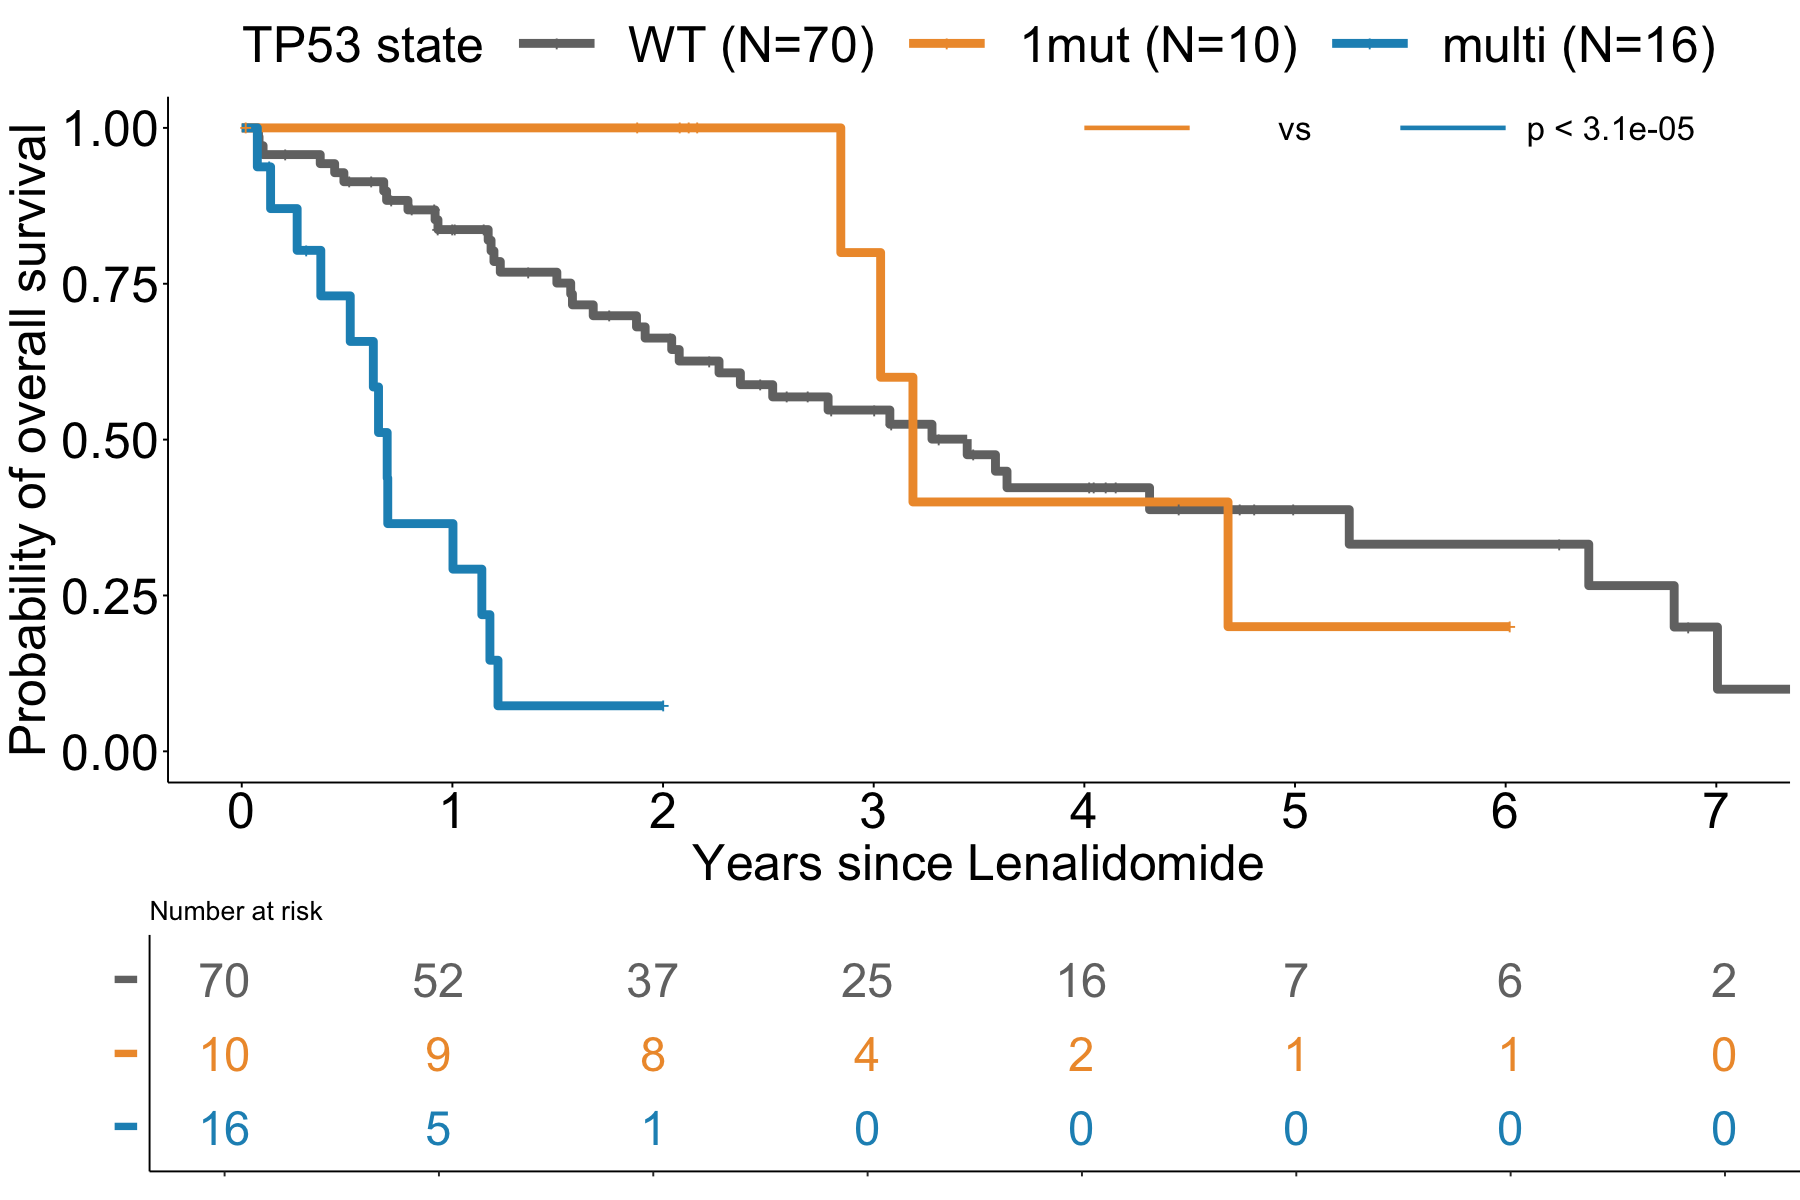

In [96]:
options(repr.plot.width=15, repr.plot.height=10)
ggLENPT.del5q = ggarrange(gg.len.OS.plot.del5q , gg.len.OS.table.del5q+theme(plot.margin = unit(c(0, 0, 0.5, 0.15), "cm")), 
          nrow=2, ncol=1,
          heights=c(3,1)
         )
ggLENPT.del5q

In [97]:
#Pairwise p-values Log-Rank test:
pt.len.os$p.value

WT           1mut        
1mut  5.209840e-01           NA
multi 5.485345e-09 3.113332e-05

In [98]:
# Hazard Ratio multi vs. 1mut after Lenalidomid on del5q patients:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=hmp[hmp$allelic_status%in%c("1mut","multi"),]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = hmp[hmp$allelic_status %in% c("1mut", 
    "multi"), ])

  n= 29, number of events= 20 

                        coef exp(coef) se(coef)      z Pr(>|z|)   
allelic_status1mut  -2.41045   0.08978  0.77200 -3.122  0.00179 **
allelic_statusmulti       NA        NA  0.00000     NA       NA   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut    0.08978      11.14   0.01977    0.4077
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.718  (se = 0.048 )
Likelihood ratio test= 15.28  on 1 df,   p=9e-05
Wald test            = 9.75  on 1 df,   p=0.002
Score (logrank) test = 14.33  on 1 df,   p=2e-04


## Fig 4d: OS after HSCT

We consider OS following HSCT per TP53 allelic state.

HSCT: hematopoietic stem cell transplantation.

In [99]:
table(dd$allelic_status, dd$transplant)

       
           0    1
  WT    2659  287
  1mut   118    7
  multi  223   30

In [100]:
options(repr.plot.width=15, repr.plot.height=8)
tmp = dd[dd$transplant==1,]
ff = as.formula(paste("Surv(os_transplant_years,os_status)~","allelic_status"))
kmfit = survfit(ff,data=tmp)
kmfit$call$formula <- ff
myleg = paste0(gsub("allelic_status=","",names(kmfit$strata))," (N=",kmfit$n,")")
gg.transplant.OS = ggsurvplot(kmfit, data=tmp,legend.title=c("TP53 state"),legend.labs=myleg,
                                conf.int=F, size=2.5, xlim=c(0,7),break.time.by=1,
                                color="allelic_status",palette=c("#737373",col.status),
                                font.x=30, font.y=30, font.tickslab=30, font.legend=30,
                                tables.col="allelic_status",   
                                risk.table=TRUE,risk.table.height=0.25,risk.table.fontsize=10,tables.y.text=FALSE
                               )
gg.transplant.OS.plot = gg.transplant.OS$plot + theme(legend.key.width = unit(2,"cm")) + ylab("Probability of overall survival") + 
xlab("Years since HSCT")
gg.transplant.OS.table = gg.transplant.OS$table + ylab("\n") + noleg + theme(axis.title.x=element_blank(),axis.text.x=element_blank()) + noleg + theme(axis.title.y = element_text(size = 30))

pt.transplant.os = pairwise_survdiff(formula=ff, data=tmp, p.adjust.method = "none")
pvva = pt.transplant.os$p.value[1,1]
pvvb = pt.transplant.os$p.value[2,2]
gg.transplant.OS.plot = gg.transplant.OS.plot  + 
annotate("segment",color=col.status[1],x=3.5,xend=4,y=1,yend=1,size=1.3) + 
annotate("text",label="vs",y=1,x=4.5,size=7) +
annotate("segment",color=col.status[2],x=5,xend=5.5,y=1,yend=1,size=1.3) +
annotate("text",label=paste("p=",signif(pvvb,2)),x=6,y=1,size=7) 

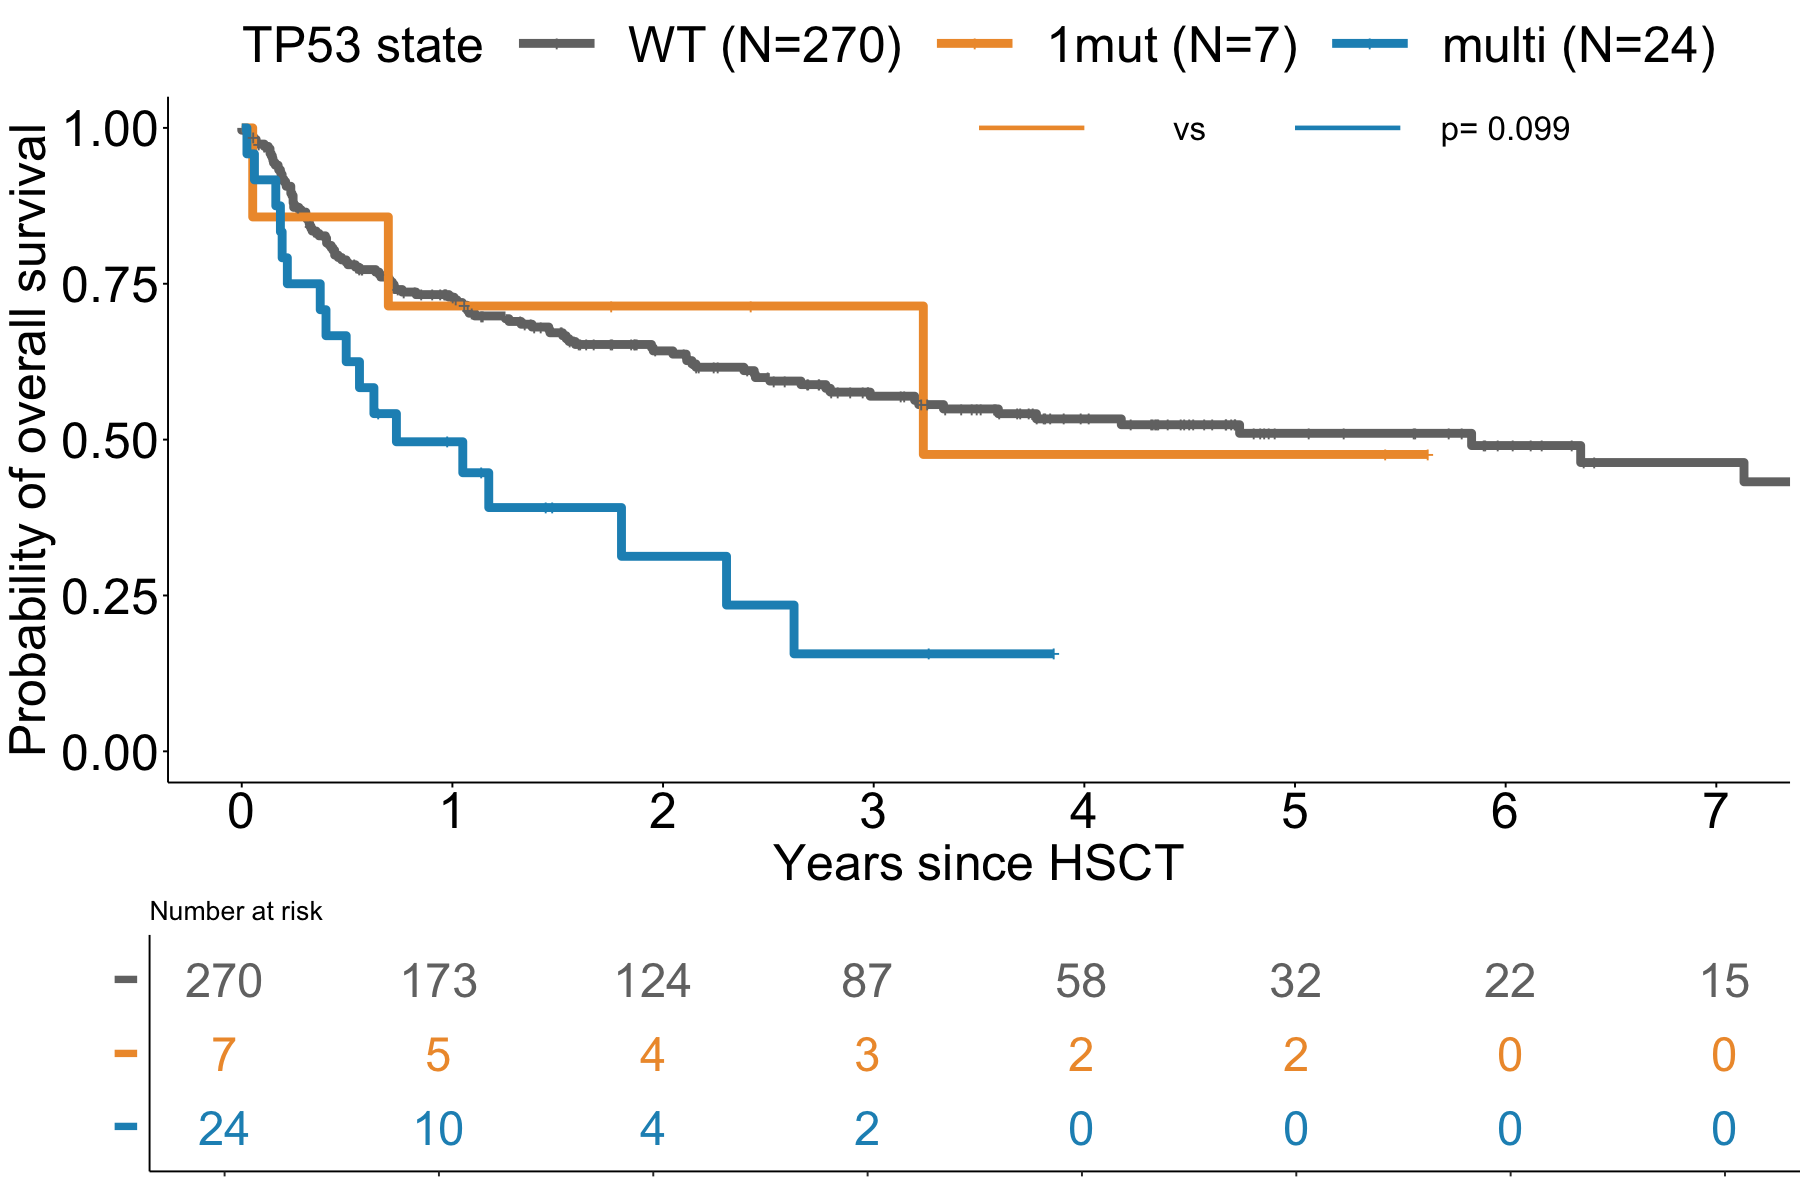

In [101]:
options(repr.plot.width=15, repr.plot.height=10)
ggTPLPT = ggarrange(gg.transplant.OS.plot , gg.transplant.OS.table+theme(plot.margin = unit(c(0, 0, 0.5, 0.15), "cm")), 
          nrow=2, ncol=1,
          heights=c(3,1)
         )
ggTPLPT

In [102]:
# Pairwise Log-Rank test p-values:
pt.transplant.os$p.value

WT           1mut      
1mut  0.9366566559         NA
multi 0.0003060681 0.09928299

In [103]:
# Hazard Ratio multi vs. 1mut following HSCT:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=tmp[tmp$allelic_status%in%c("1mut","multi"),]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = tmp[tmp$allelic_status %in% c("1mut", 
    "multi"), ])

  n= 37, number of events= 24 

                       coef exp(coef) se(coef)      z Pr(>|z|)  
allelic_status1mut  -1.2741    0.2797   0.6362 -2.003   0.0452 *
allelic_statusmulti      NA        NA   0.0000     NA       NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut     0.2797      3.576   0.08038    0.9731
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.577  (se = 0.053 )
Likelihood ratio test= 5.24  on 1 df,   p=0.02
Wald test            = 4.01  on 1 df,   p=0.05
Score (logrank) test = 4.47  on 1 df,   p=0.03


# Supp: Clinical correlates per TP53 allelic state

We look below at various clinical correlates per TP53 allelic state (1mut or multi).

We look at:
* Age
* Bone marrow blasts
* Cytopenias, i.e., Hemoglobin | Platelets | Neutrophils

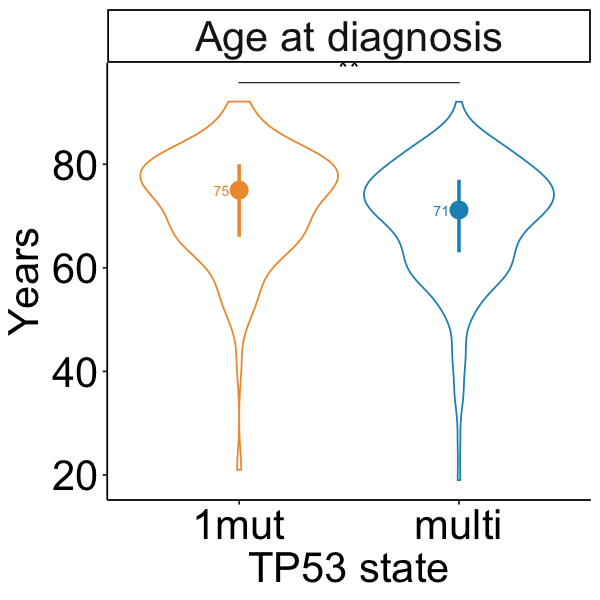

In [104]:
# Age
options(repr.plot.width=5, repr.plot.height=5)
ggAge = ggplot(aa,aes(x=allelic_status,y=AGE,color=allelic_status)) + geom_violin() + 
geom_pointrange(data=aa,mapping=aes(x=allelic_status,y=AGE,color=allelic_status),
                stat = "summary", position_dodge(width=0.4),
                size = 1,
                fun.ymin = function(z) {quantile(z,0.25)},
                fun.ymax = function(z) {quantile(z,0.75)},
                fun.y = median) +
themePP + xlab("TP53 state") + ylab("Years") + noleg +
facet_wrap(.~"Age at diagnosis") + 
stat_summary(geom="text", fun.y=median,
               aes(label=sprintf("%1.0f", ..y..), color=allelic_status),
               position=position_nudge(x=-0.08), size=3) + 
scale_color_manual(values=col.status) +
stat_compare_means(label="p.signif",comparisons=list(c(1,2)),tip.length=0,method="wilcox.test",size=6)
ggAge

Warning message:
“Removed 7 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 7 rows containing non-finite values (stat_summary).”Warning message:
“Removed 7 rows containing non-finite values (stat_summary).”Warning message:
“Removed 7 rows containing non-finite values (stat_signif).”

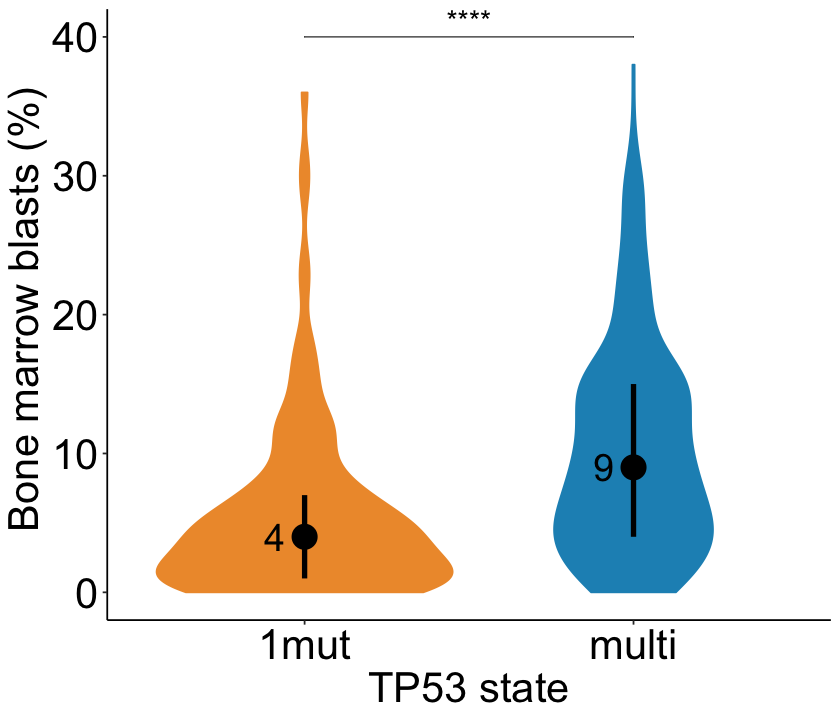

In [105]:
# BM BLASTS
options(repr.plot.width=7, repr.plot.height=6)
ggBM = ggplot(aa,aes(x=allelic_status,y=BM_BLAST,fill=allelic_status,color=allelic_status)) + geom_violin() + 
geom_pointrange(data=aa,mapping=aes(x=allelic_status,y=BM_BLAST),color="black",
                stat = "summary", position_dodge(width=0.4),
                size = 1.5,
                fun.ymin = function(z) {quantile(z,0.25)},
                fun.ymax = function(z) {quantile(z,0.75)},
                fun.y = median) +
themePP + xlab("TP53 state") + ylab(" Bone marrow blasts (%)") + noleg +
stat_summary(geom="text", fun.y=median,
               aes(label=sprintf("%1.0f", ..y..)),color="black",
               position=position_nudge(x=-0.09), size=8) + 
scale_color_manual(values=col.status) + scale_fill_manual(values=col.status)  +
scale_y_continuous(limits=c(0,40)) +
stat_compare_means(label="p.signif",comparisons=list(c(1,2)),label.y=40,tip.length=0,method="wilcox.test",size=6)
ggBM

Warning message:
“Removed 4 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”Warning message:
“Removed 4 rows containing non-finite values (stat_signif).”Warning message:
“Removed 6 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 6 rows containing non-finite values (stat_summary).”Warning message:
“Removed 6 rows containing non-finite values (stat_summary).”Warning message:
“Removed 6 rows containing non-finite values (stat_signif).”Warning message:
“Removed 16 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 16 rows containing non-finite values (stat_summary).”Warning message:
“Removed 16 rows containing non-finite values (stat_summary).”Warning message:
“Removed 16 rows containing non-finite values (stat_signif).”

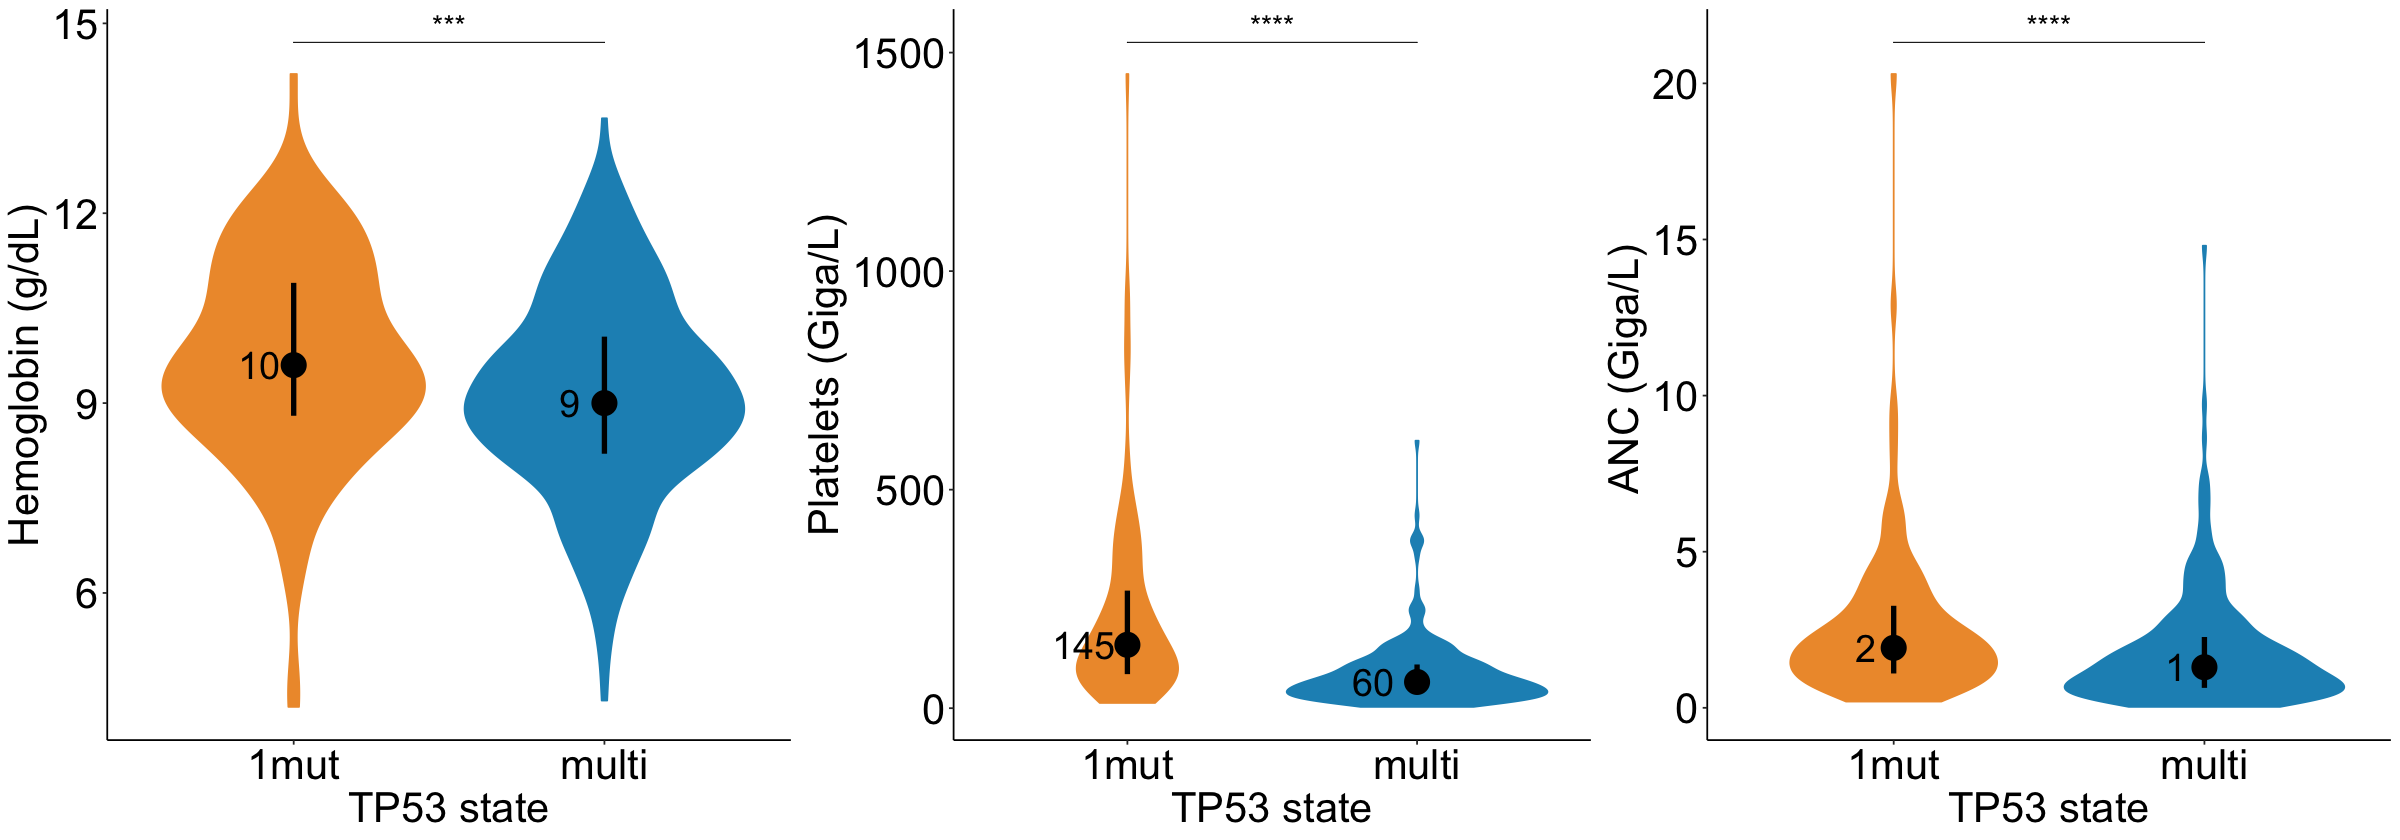

In [106]:
# Cytopenias
options(warns = 1)
options(repr.plot.width=20, repr.plot.height=7)
ggHB = ggplot(aa,aes(x=allelic_status,y=HB,fill=allelic_status,color=allelic_status)) + geom_violin() + 
geom_pointrange(data=aa,mapping=aes(x=allelic_status,y=HB),color="black",
                stat = "summary", position_dodge(width=0.4),
                size = 1.5,
                fun.ymin = function(z) {quantile(z,0.25)},
                fun.ymax = function(z) {quantile(z,0.75)},
                fun.y = median) +
themePP + xlab("TP53 state") + ylab("Hemoglobin (g/dL)") + noleg +
stat_summary(geom="text", fun.y=median,
               aes(label=sprintf("%1.0f", ..y..)),color="black",
               position=position_nudge(x=-0.11), size=8) + 
scale_fill_manual(values=col.status) +
scale_color_manual(values=col.status) +
#facet_wrap(.~"Hemoglobin") + 
stat_compare_means(label="p.signif",comparisons=list(c(1,2)),tip.length=0,method="wilcox.test",size=6)
ggPLT = ggplot(aa,aes(x=allelic_status,y=PLT,fill=allelic_status,color=allelic_status)) + geom_violin() + 
geom_pointrange(data=aa,mapping=aes(x=allelic_status,y=PLT),color="black",
                stat = "summary", position_dodge(width=0.4),
                size = 1.5,
                fun.ymin = function(z) {quantile(z,0.25)},
                fun.ymax = function(z) {quantile(z,0.75)},
                fun.y = median) +
themePP + xlab("TP53 state") + ylab("Platelets (Giga/L)") + noleg +
stat_summary(geom="text", fun.y=median,
               aes(label=sprintf("%1.0f", ..y..)),color="black",
               position=position_nudge(x=-0.15), size=8) + 
scale_fill_manual(values=col.status) +
scale_color_manual(values=col.status) +
#facet_wrap(.~"Platelets") + 
stat_compare_means(label="p.signif",comparisons=list(c(1,2)),tip.length=0,method="wilcox.test",size=6)
ggANC = ggplot(aa,aes(x=allelic_status,y=ANC,fill=allelic_status,color=allelic_status)) + geom_violin() + 
geom_pointrange(data=aa,mapping=aes(x=allelic_status,y=ANC),color="black",
                stat = "summary", position_dodge(width=0.4),
                size = 1.5,
                fun.ymin = function(z) {quantile(z,0.25)},
                fun.ymax = function(z) {quantile(z,0.75)},
                fun.y = median) +
#themePP + xlab("TP53 state") + ylab(" Absolute Neutrophil Count (Giga/L)") + noleg +
themePP + xlab("TP53 state") + ylab(" ANC (Giga/L)") + noleg +
stat_summary(geom="text", fun.y=median,
               aes(label=sprintf("%1.0f", ..y..)),color="black",
               position=position_nudge(x=-0.09), size=8) + 
scale_fill_manual(values=col.status) +
scale_color_manual(values=col.status) +
#facet_wrap(.~"Absolute Neutrophil Count") + 
stat_compare_means(label="p.signif",comparisons=list(c(1,2)),tip.length=0,method="wilcox.test",size=6)
ggCytopenias= grid.arrange(ggHB, ggPLT, ggANC, ncol=3)

# Supp: OS across all TP53 subgroups

We look at the OS across all TP53 subgroups, and
show that all the multi-hit categories have a very poor survival.

In [107]:
# Outcome
# OS
ff = as.formula(paste("Surv(os_sample_years,os_status)~","detail_status"))
kmfit = survfit(ff,data=dd)
kmfit$call$formula <- ff
myleg = paste0(gsub("detail_status=","",names(kmfit$strata))," (N=",kmfit$n,")")
ggs = ggsurvplot(kmfit, data=dd, legend.title="",legend.labs=myleg,
                 conf.int=F, size=1.5, xlim=c(0,15),break.time.by=5,
                 font.x=18, font.y=18, font.tickslab=18, font.legend=18
                )$plot +
guides(colour = guide_legend(nrow = 2)) + theme(legend.key.width = unit(1.1,"cm")) + 
scale_color_manual(values=c("#737373",col.subtypes)) + xlab("Years")
ptos = pairwise_survdiff(formula=ff, data=dd, p.adjust.method = "none")
ggOS = ggs +
ylab("Probability of overall survival") + nolegtitle +
annotate("segment",color=col.subtypes[2],x=8,xend=9,y=1,yend=1,size=1.3) +
annotate("text",label=paste("p","<",signif(ptos$p.value[2,2],2),"                            "),x=12.2,y=1,size=5) + 
#
annotate("segment",color=col.status[1],x=6,xend=7,y=0.9,yend=0.9,size=1.3) + 
annotate("text",label="vs",y=0.9,x=7.5,size=5) +
annotate("segment",color=col.subtypes[3],x=8,xend=9,y=0.9,yend=0.9,size=1.3) +
annotate("text",label=paste("p","<",signif(ptos$p.value[3,2],2)," by Log-Rank test"),x=12.3,y=0.9,size=5) + 
#
annotate("segment",color=col.subtypes[4],x=8,xend=9,y=0.8,yend=0.8,size=1.3) +
annotate("text",label=paste("p","<",signif(ptos$p.value[4,2],2),"                            "),x=12.2,y=0.8,size=5)

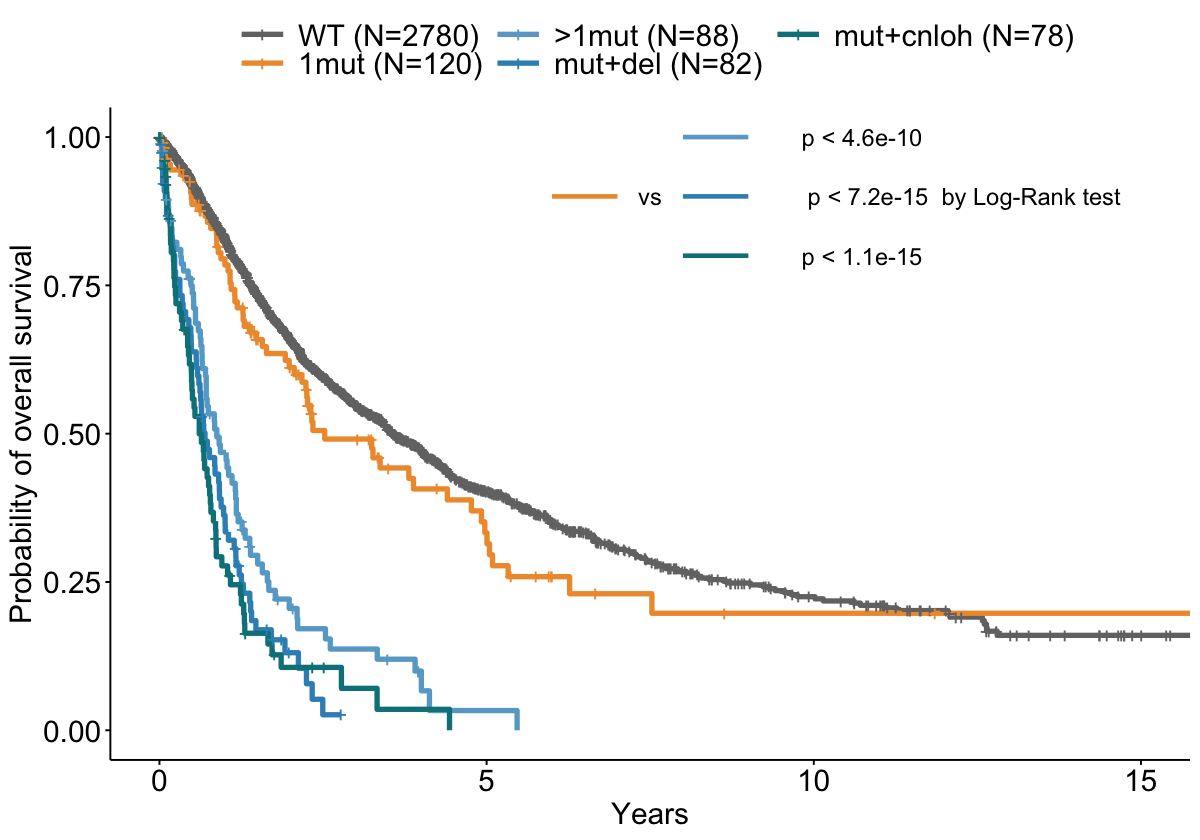

In [108]:
options(repr.plot.width=10, repr.plot.height=7)
ggOS

In [109]:
# Pairwise Log-Rank test p-values:
ptos$p.value

WT           1mut         >1mut      mut+del  
1mut      1.645970e-01           NA         NA        NA
>1mut     2.170058e-32 4.617282e-10         NA        NA
mut+del   3.937558e-50 7.244185e-15 0.06684358        NA
mut+cnloh 1.464461e-53 1.074335e-15 0.03302721 0.7446638

# Supp : WHO distribution and OS per TP53 allelic state

We look at the representation of WHO subgroups per TP53 allelic state and the OS across the WHO subgroups.

In [110]:
golevels = c("t-MDS","MDS-del5q","MDS-SLD/MLD","MDS-RS-SLD/MLD","MDS/MPN-RS-T","MDS-EB1/2","AML/AML-MRC","CMML","aCML","MDS/MPN-U","MDS-U","other")
dd$WHO_2016_SIMPLIFY = factor(dd$WHO_2016_SIMPLIFY, levels=golevels)

In [111]:
table(dd$allelic_status, dd$WHO_2016_SIMPLIFY,exclude=F)

       
        t-MDS MDS-del5q MDS-SLD/MLD MDS-RS-SLD/MLD MDS/MPN-RS-T MDS-EB1/2
  WT      167       109         812            409           39       649
  1mut     10        18          22             14            2        39
  multi    52         4          27             13            0       117
       
        AML/AML-MRC CMML aCML MDS/MPN-U MDS-U other <NA>
  WT            118  380   40        45    86     5   87
  1mut            6    7    1         4     1     0    1
  multi          24   10    2         1     3     0    0

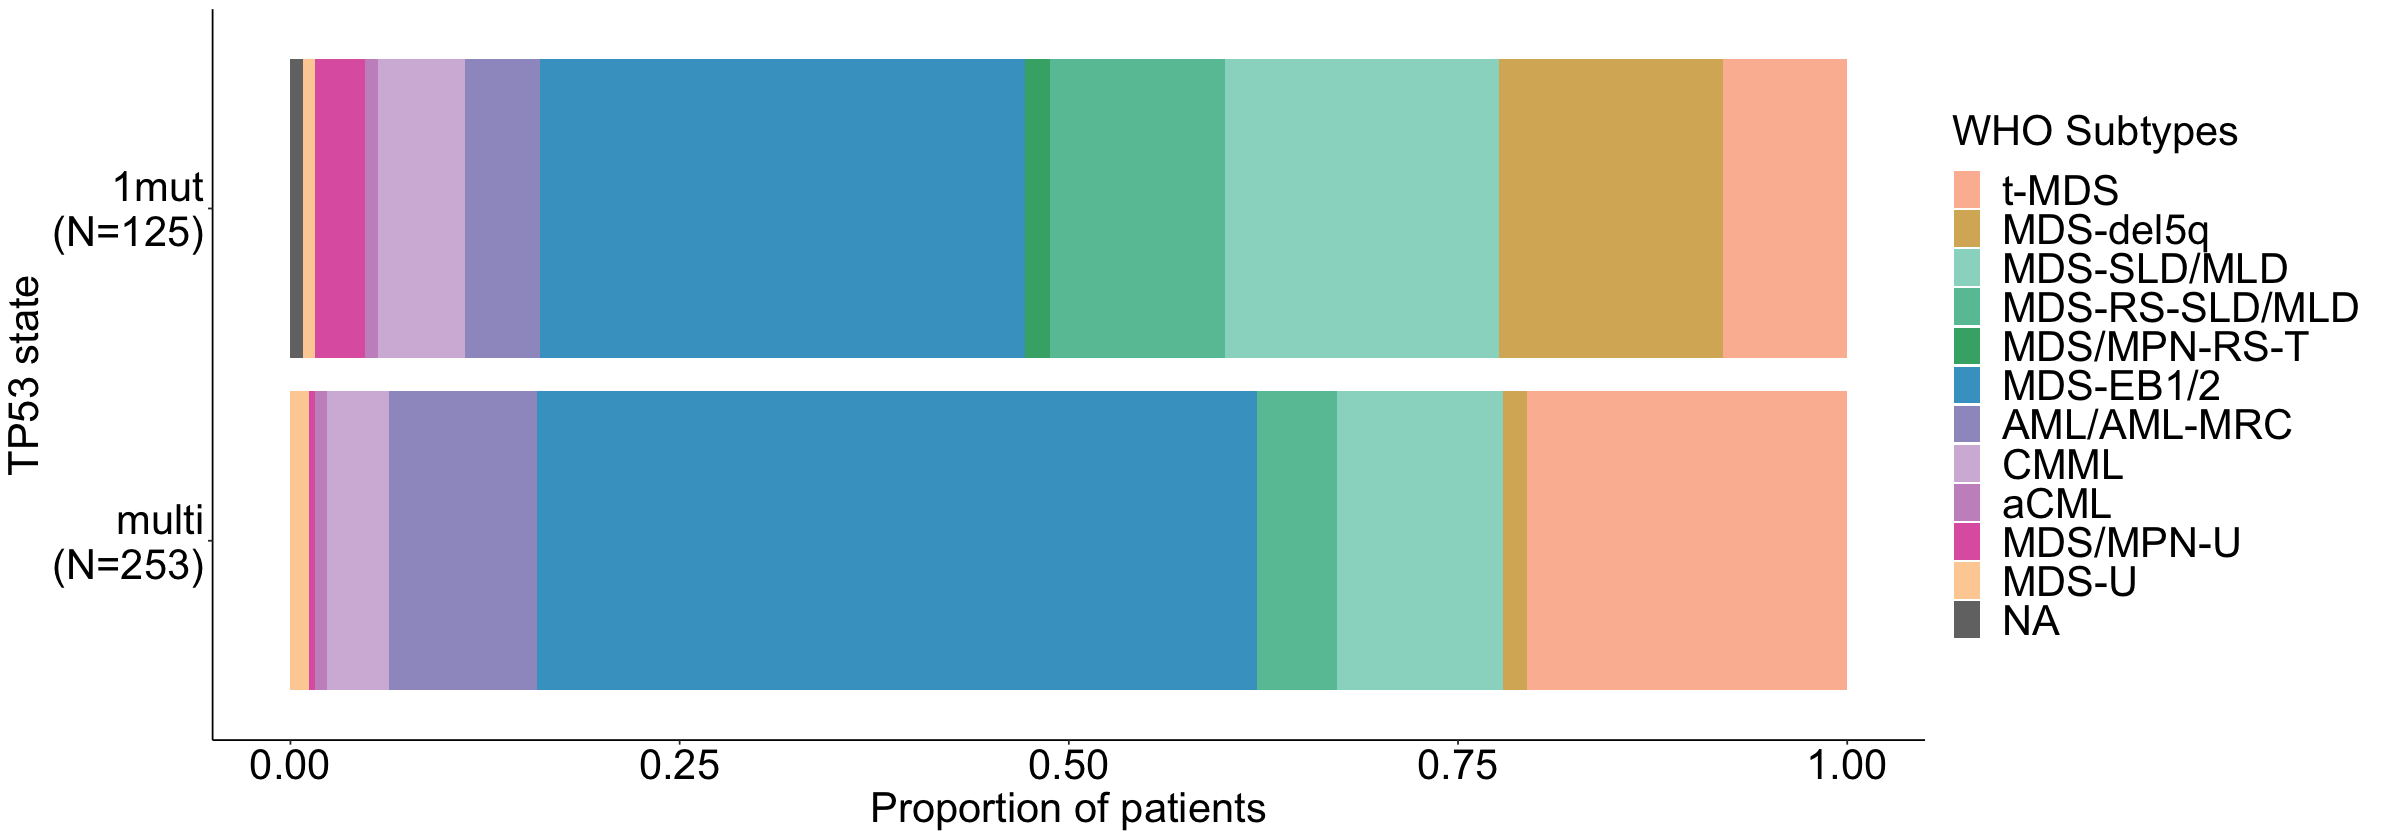

In [112]:
options(repr.plot.width=20, repr.plot.height=7)
tmp = dd[dd$allelic_status!="WT",]
tmp$label = paste0(tmp$allelic_status,"\n","(N=",table(tmp$allelic_status)[tmp$allelic_status],")")
tmp$label = factor(tmp$label, levels=unique(tmp$label))
ggWHO = ggplot(tmp) + geom_bar(aes(x=label,fill=WHO_2016_SIMPLIFY),position="fill") + themePP + 
xlab("TP53 state") + 
scale_fill_manual(values=col.who,na.value="#737373") + ylab("Proportion of patients") + coord_flip() + labs(fill="WHO Subtypes")
ggWHO

In [113]:
# KEEP CASES WHERE WE HAVE MORE THAN 5 CASES IN AT LEAST OF TP53 mono or bi
# WE WILL DO t-MDS SEPARATELY
tmp = dd
tmp$my_who = tmp$WHO_2016_SIMPLIFY
tmp = tmp[!tmp$my_who %in% c("t-MDS","aCML","MDS-U","MDS/MPN-RS-T","MDS/MPN-U","other") ,]
tmp$my_who = factor(tmp$my_who, levels=levels(tmp$my_who)[levels(tmp$my_who) %in% unique(tmp$my_who)])

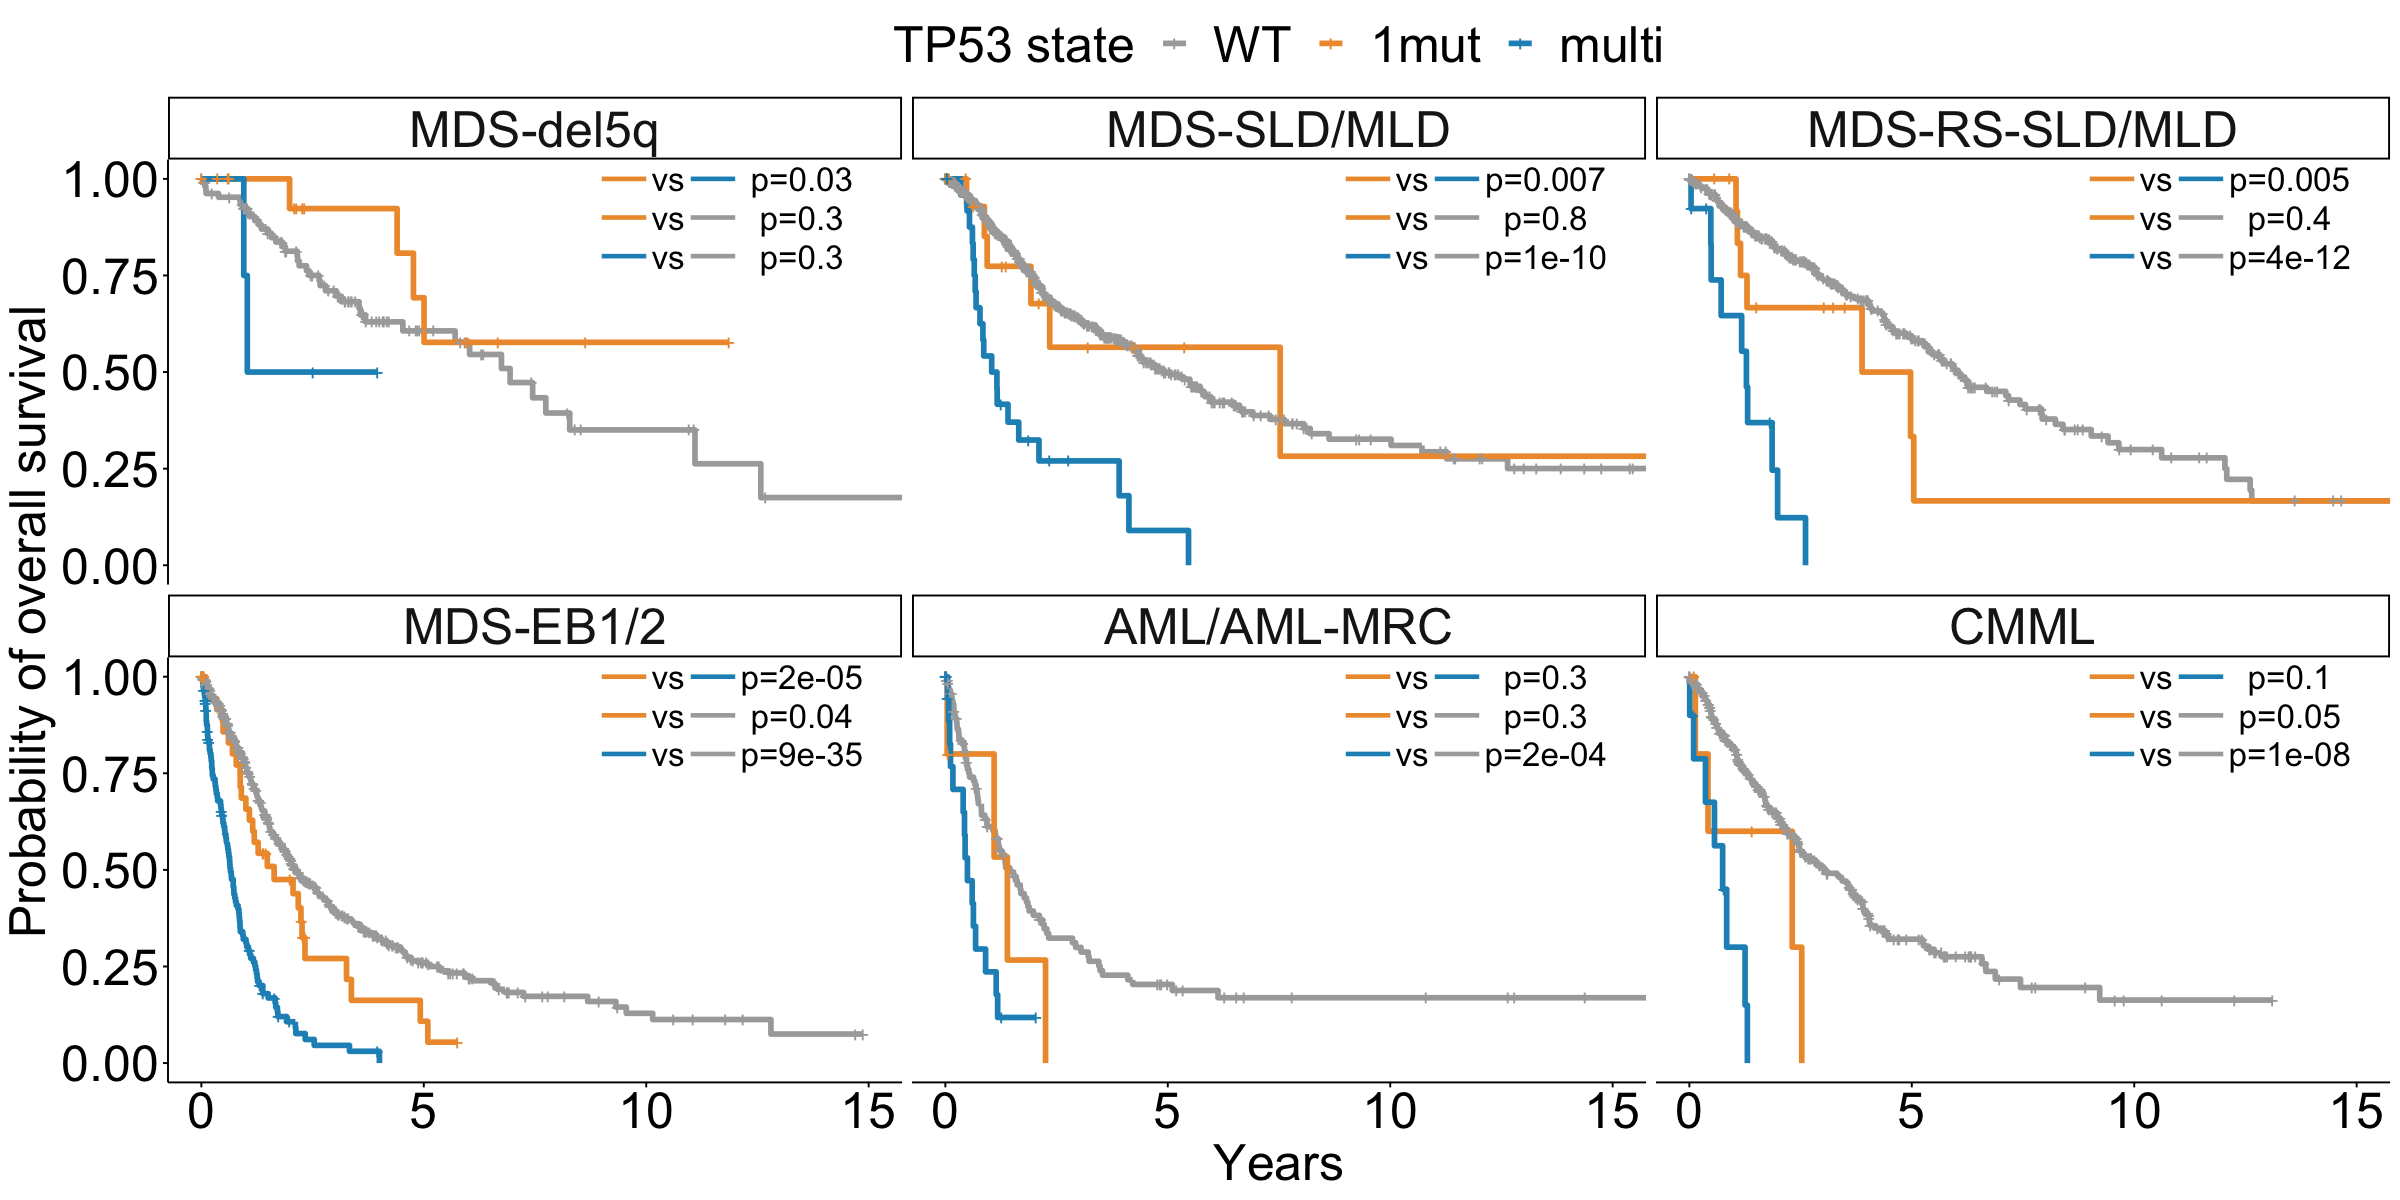

In [114]:
options(repr.plot.width=20, repr.plot.height=10)
ff = as.formula(paste("Surv(os_sample_years,os_status)~","my_who + allelic_status"))
kmfit = survfit(ff,data=tmp)
kmfit$call$formula <- ff
ggwhoOS = ggsurvplot(kmfit, data=tmp, legend.title="", conf.int=F, size=1.6, xlim=c(0,15),color="allelic_status",
                     font.x=30, font.y=30, font.tickslab=30, font.legend=30,break.time.by=5,
                    )$plot +
scale_color_manual(values=c("darkgrey",col.status),name="TP53 state") + facet_wrap(~my_who,ncol=3) + 
theme(strip.text.x = element_text(size=30)) +
ylab("Probability of overall survival") + xlab("Years")

posgo1 = c()
posgo2 = c()
posgo3= c()
for (mmw in levels(tmp$my_who)) {
    pvos = pairwise_survdiff(formula=ff, data=tmp[tmp$allelic_status%in%c("1mut","multi")&tmp$my_who%in%mmw,], p.adjust.method = "none")
    pvos2 = pairwise_survdiff(formula=ff, data=tmp[tmp$allelic_status%in%c("1mut","WT")&tmp$my_who%in%mmw,], p.adjust.method = "none")
    pvos3 = pairwise_survdiff(formula=ff, data=tmp[tmp$allelic_status%in%c("multi","WT")&tmp$my_who%in%mmw,], p.adjust.method = "none")
    posgo1 = c(posgo1,signif(pvos$p.value[1,1],1))
    posgo2 = c(posgo2,signif(pvos2$p.value[1,1],1))
    posgo3 = c(posgo3,signif(pvos3$p.value[1,1],1))
}

ann_text = data.frame(my_who=levels(tmp$my_who),x=13.5,y=1,label=paste0("p=",posgo1))
ann_text2 = data.frame(my_who=levels(tmp$my_who),x=13.5,y=0.9,label=paste0("p=",posgo2)) 
ann_text3 = data.frame(my_who=levels(tmp$my_who),x=13.5,y=0.8,label=paste0("p=",posgo3))
ggwhoOS = ggwhoOS + 
# MONO | BI
annotate("segment",color=col.status[1],x=9,xend=10,y=1,yend=1,size=1.3) + 
annotate("text",label="vs",y=1,x=10.5,size=7) +
annotate("segment",color=col.status[2],x=11,xend=12,y=1,yend=1,size=1.3) +
geom_text(data=ann_text, aes(x=x,y=y,label=label),size=7) + 
#annotate("text",label=paste0("p=",posgo1),x=13.5,y=1,size=7) +
# MONO | WT
annotate("segment",color=col.status[1],x=9,xend=10,y=0.9,yend=0.9,size=1.3) + 
annotate("text",label="vs",y=0.9,x=10.5,size=7) +
annotate("segment",color="darkgrey",x=11,xend=12,y=0.9,yend=0.9,size=1.3) +
geom_text(data=ann_text2, aes(x=x,y=y,label=label),size=7) + 
#annotate("text",label=paste0("p=",posgo2),x=13.5,y=0.9,size=7)
# BI | WT
annotate("segment",color=col.status[2],x=9,xend=10,y=0.8,yend=0.8,size=1.3) + 
annotate("text",label="vs",y=0.8,x=10.5,size=7) +
annotate("segment",color="darkgrey",x=11,xend=12,y=0.8,yend=0.8,size=1.3) +
geom_text(data=ann_text3, aes(x=x,y=y,label=label),size=7)

ggwhoOS

# Supp: IPSS-R distribution and OS per TP53 allelic state

We look at the representation of IPSS-R risk scores per TP53 allelic state and the OS across the IPSS-R strata.

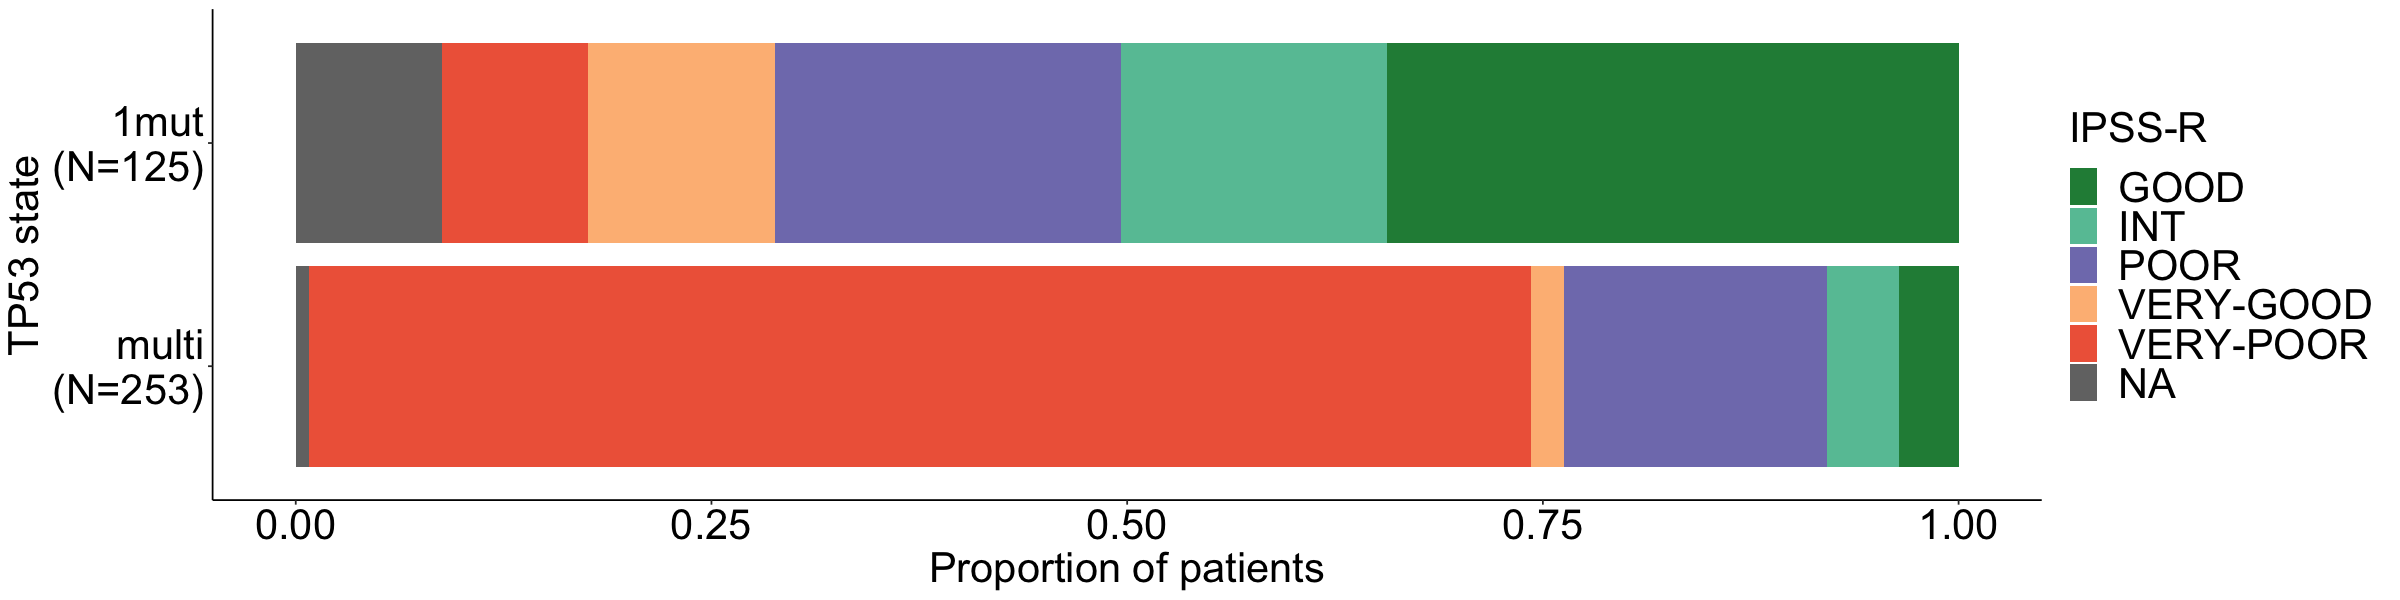

In [116]:
# IPSSR
options(repr.plot.width=20, repr.plot.height=5)
tmp = dd[dd$allelic_status!="WT",]
tmp$label = paste0(tmp$allelic_status,"\n","(N=",table(tmp$allelic_status)[tmp$allelic_status],")")
tmp$label = factor(tmp$label, levels=unique(tmp$label))
aa$label = paste0(aa$allelic_status,"\n","(N=",table(aa$allelic_status)[aa$allelic_status],")")
ggIPSSR = ggplot(tmp) + geom_bar(aes(x=label,fill=IPSSR_CALCULATED),position="fill") + themePP + 
xlab("TP53 state") + 
scale_fill_manual(values=col.ipssr,na.value="#737373") + ylab("Proportion of patients") + coord_flip() + labs(fill="IPSS-R")
ggIPSSR

In [117]:
dd$my_ipssr = as.vector(dd$IPSSR_CALCULATED)
dd$my_ipssr[dd$IPSSR_CALCULATED%in%c("VERY-GOOD","GOOD")] = "(VERY)-GOOD"
dd$my_ipssr[dd$IPSSR_CALCULATED%in%c("VERY-POOR","POOR")] = "(VERY)-POOR"
dd$my_ipssr = factor(dd$my_ipssr, levels=c("(VERY)-GOOD","INT","(VERY)-POOR"))

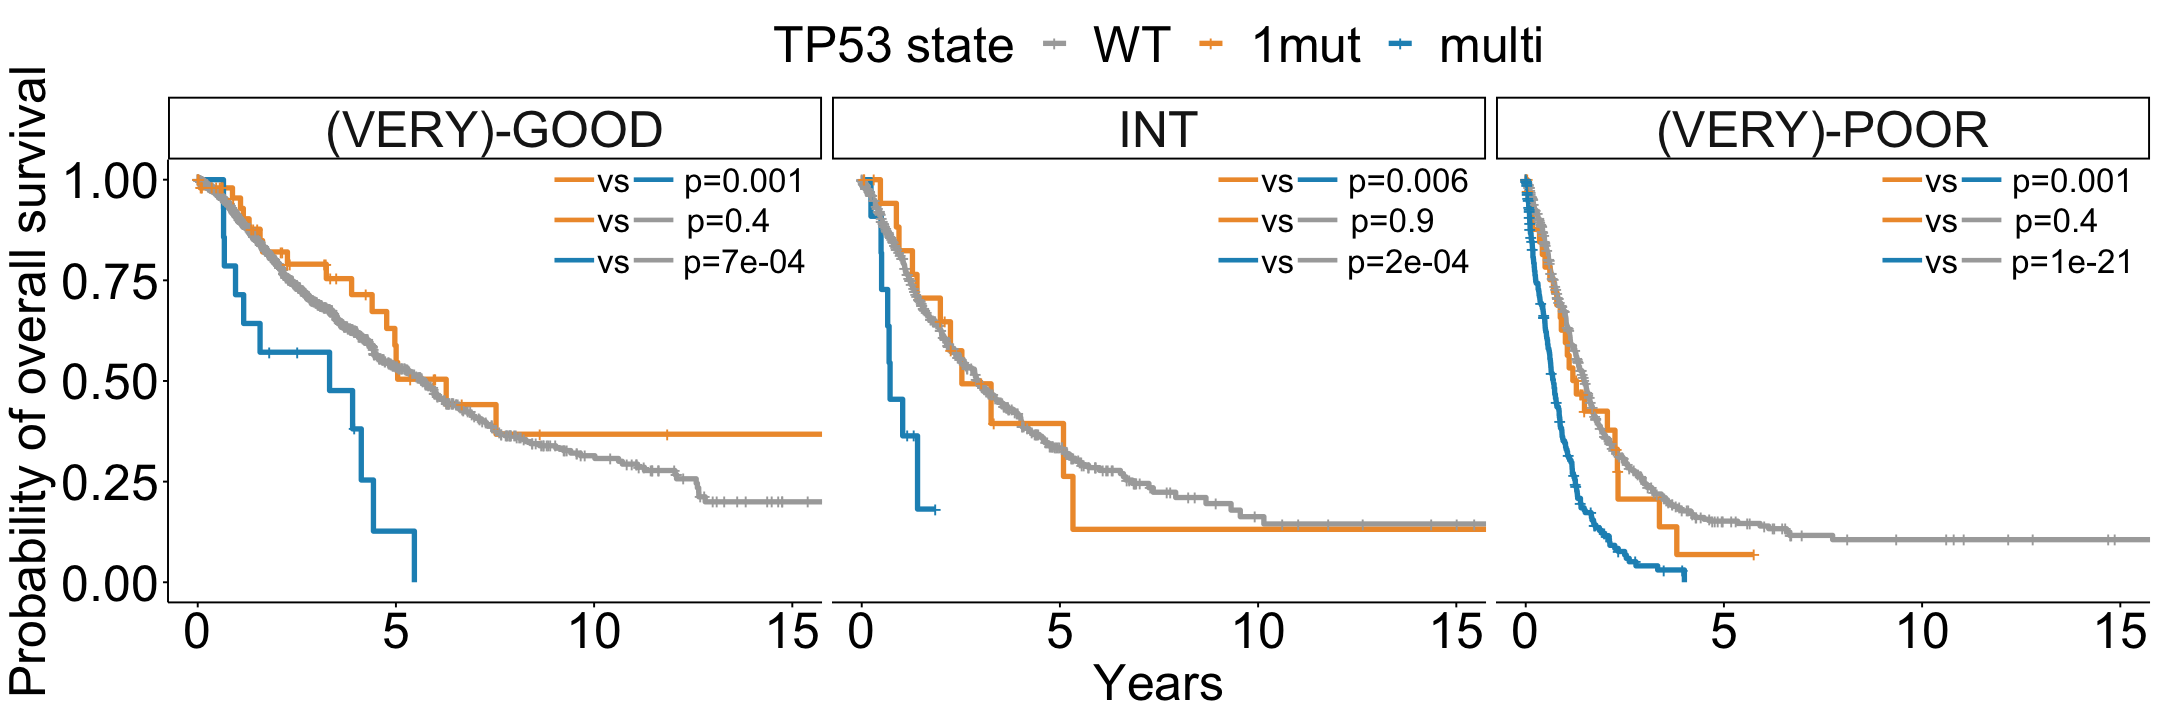

In [118]:
options(repr.plot.width=18, repr.plot.height=6)
ff = as.formula(paste("Surv(os_sample_years,os_status)~","my_ipssr + allelic_status"))
kmfit = survfit(ff,data=dd)
kmfit$call$formula <- ff
ggipssrOS = ggsurvplot(kmfit, data=dd, legend.title="", conf.int=F, size=1.5, xlim=c(0,15),color="allelic_status",breaks=5,
                       font.x=30, font.y=30, font.tickslab=30, font.legend=30
                      )$plot +
theme(strip.text.x = element_text(size=30)) +
scale_color_manual(values=c("darkgrey",col.status),name="TP53 state") + facet_wrap(~my_ipssr,ncol=3) +
ylab("Probability of overall survival") + xlab("Years")

posgo1 = c()
posgo2 = c()
posgo3 = c()
for (mmw in levels(dd$my_ipssr)) {
    pvos = pairwise_survdiff(formula=ff, data=dd[dd$allelic_status%in%c("1mut","multi")& dd$my_ipssr%in%mmw,], p.adjust.method = "none")
    pvos2 = pairwise_survdiff(formula=ff, data=dd[dd$allelic_status%in%c("1mut","WT")& dd$my_ipssr%in%mmw,], p.adjust.method = "none")
    pvos3 = pairwise_survdiff(formula=ff, data=dd[dd$allelic_status%in%c("multi","WT")& dd$my_ipssr%in%mmw,], p.adjust.method = "none")
    posgo1 = c(posgo1,signif(pvos$p.value[1,1],1))
    posgo2 = c(posgo2,signif(pvos2$p.value[1,1],1))
    posgo3 = c(posgo3,signif(pvos3$p.value[1,1],1))
}

ann_text = data.frame(my_ipssr=levels(dd$my_ipssr),x=13.8,y=1,label=paste0("p=",posgo1))
ann_text2 = data.frame(my_ipssr=levels(dd$my_ipssr),x=13.4,y=0.9,label=paste0("p=",posgo2)) 
ann_text3 = data.frame(my_ipssr=levels(dd$my_ipssr),x=13.8,y=0.8,label=paste0("p=",posgo3)) 
ggipssrOS = ggipssrOS + 
# MONO | BI
annotate("segment",color=col.status[1],x=9,xend=10,y=1,yend=1,size=1.3) + 
annotate("text",label="vs",y=1,x=10.5,size=7) +
annotate("segment",color=col.status[2],x=11,xend=12,y=1,yend=1,size=1.3) +
geom_text(data = ann_text, aes(x=x,y=y,label=label),size=7) +
#annotate("text",label=paste0("p=",posgo1),x=13.6,y=1,size=7) #+
# MONO | WT
annotate("segment",color=col.status[1],x=9,xend=10,y=0.9,yend=0.9,size=1.3) + 
annotate("text",label="vs",y=0.9,x=10.5,size=7) +
annotate("segment",color="darkgrey",x=11,xend=12,y=0.9,yend=0.9,size=1.3) +
#annotate("text",label=paste0("p=",posgo2),x=13.6,y=0.9,size=7)
geom_text(data = ann_text2, aes(x=x,y=y,label=label),size=7) +
# BI | WT
annotate("segment",color=col.status[2],x=9,xend=10,y=0.8,yend=0.8,size=1.3) + 
annotate("text",label="vs",y=0.8,x=10.5,size=7) +
annotate("segment",color="darkgrey",x=11,xend=12,y=0.8,yend=0.8,size=1.3) +
#annotate("text",label=paste0("p=",posgo2),x=13.6,y=0.9,size=7)
geom_text(data = ann_text3, aes(x=x,y=y,label=label),size=7)

ggipssrOS

# Supp: Interaction with complex karyotype

We investigate the interaction between compplex karyotype (CK) and TP53 allelic state.

CK is defined as 3 independent chromosomal alterations (excluding cnloh).

In [119]:
table(dd$tp53,dd$complex)

     
      complex non-complex
  MUT     247         131
  WT       82        2864

Below the interaction in OS between CK and TP53 mutated or WT.

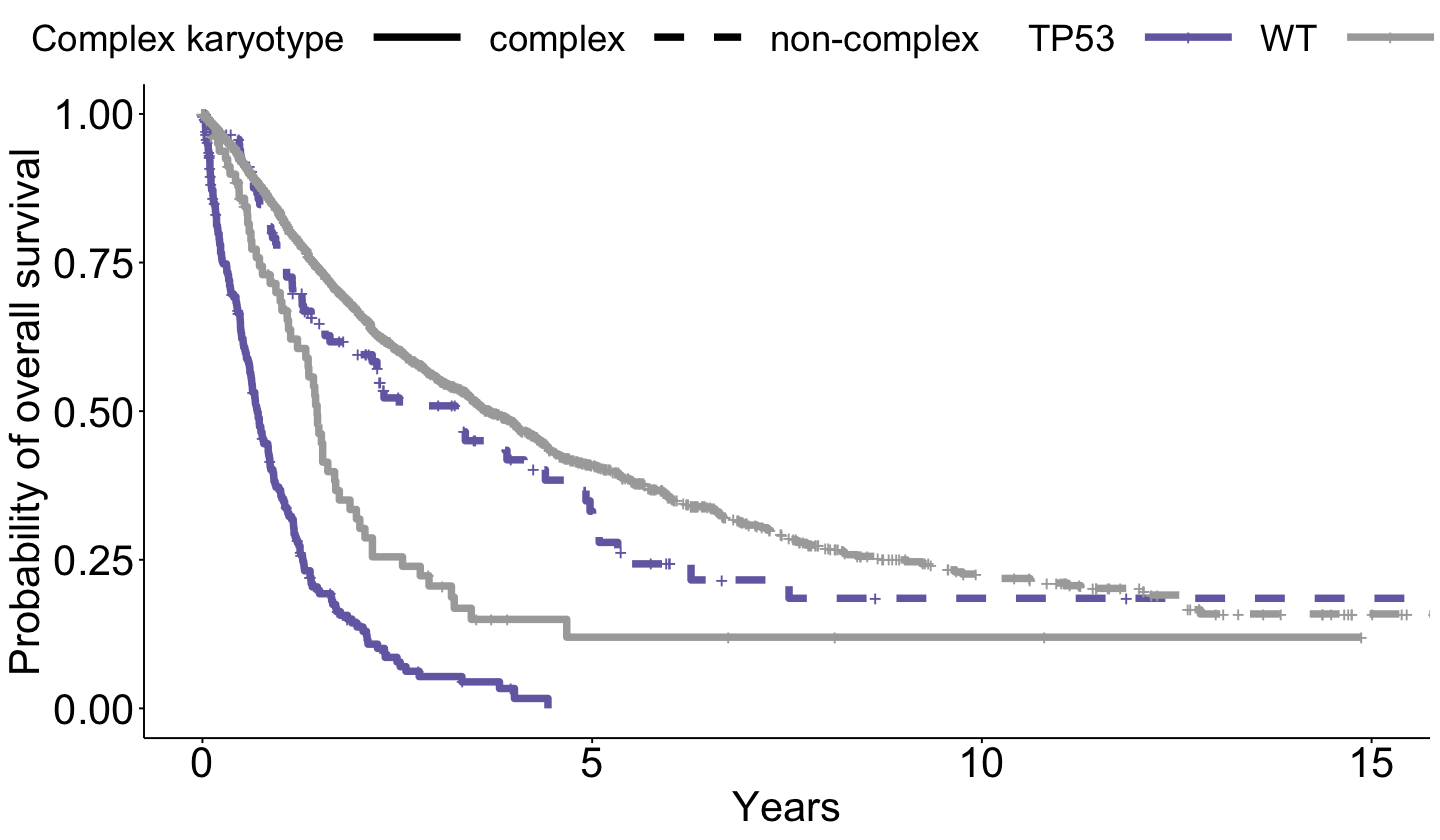

In [120]:
options(repr.plot.width=12, repr.plot.height=7)
ff = as.formula(paste("Surv(os_sample_years,os_status)~","complex + tp53"))
kmfit = survfit(ff,data=dd)
kmfit$call$formula <- ff
#myleg = paste0(gsub("allelic_status=","",names(kmfit$strata))," (N=",kmfit$n,")")
ggckeasy = ggsurvplot(kmfit, data=dd, legend.title="",conf.int=F, size=2.1, xlim=c(0,15),linetype="complex",color="tp53",breaks=5,
                      font.x=25, font.y=25, font.tickslab=25, font.legend=22,
                     )$plot +
scale_color_manual(values=rev(pal.wt.mut),name="TP53",labels=c("WT","MUT"))  + 
scale_linetype_manual(values=c("solid","dashed"),name="Complex karyotype") + theme(legend.key.width = unit(2.3,"cm")) +
xlab("Years") + ylab("Probability of overall survival")
ggckeasy
pt.ck.wt.mut = pairwise_survdiff(ff,data=dd,p.adjust.method = NULL)$p.value

In [121]:
# Pairwise Log-Rank test p-values:
pt.ck.wt.mut

complex=complex, tp53=MUT
complex=complex, tp53=WT       1.796802e-06            
complex=non-complex, tp53=MUT  1.858600e-20            
complex=non-complex, tp53=WT  7.347668e-119            
                              complex=complex, tp53=WT 
complex=complex, tp53=WT                NA             
complex=non-complex, tp53=MUT 1.392767e-03             
complex=non-complex, tp53=WT  2.815284e-09             
                              complex=non-complex, tp53=MUT
complex=complex, tp53=WT              NA                   
complex=non-complex, tp53=MUT         NA                   
complex=non-complex, tp53=WT  0.09293486

Same below but only from the CK cases, TP53 mutated or wild-type:

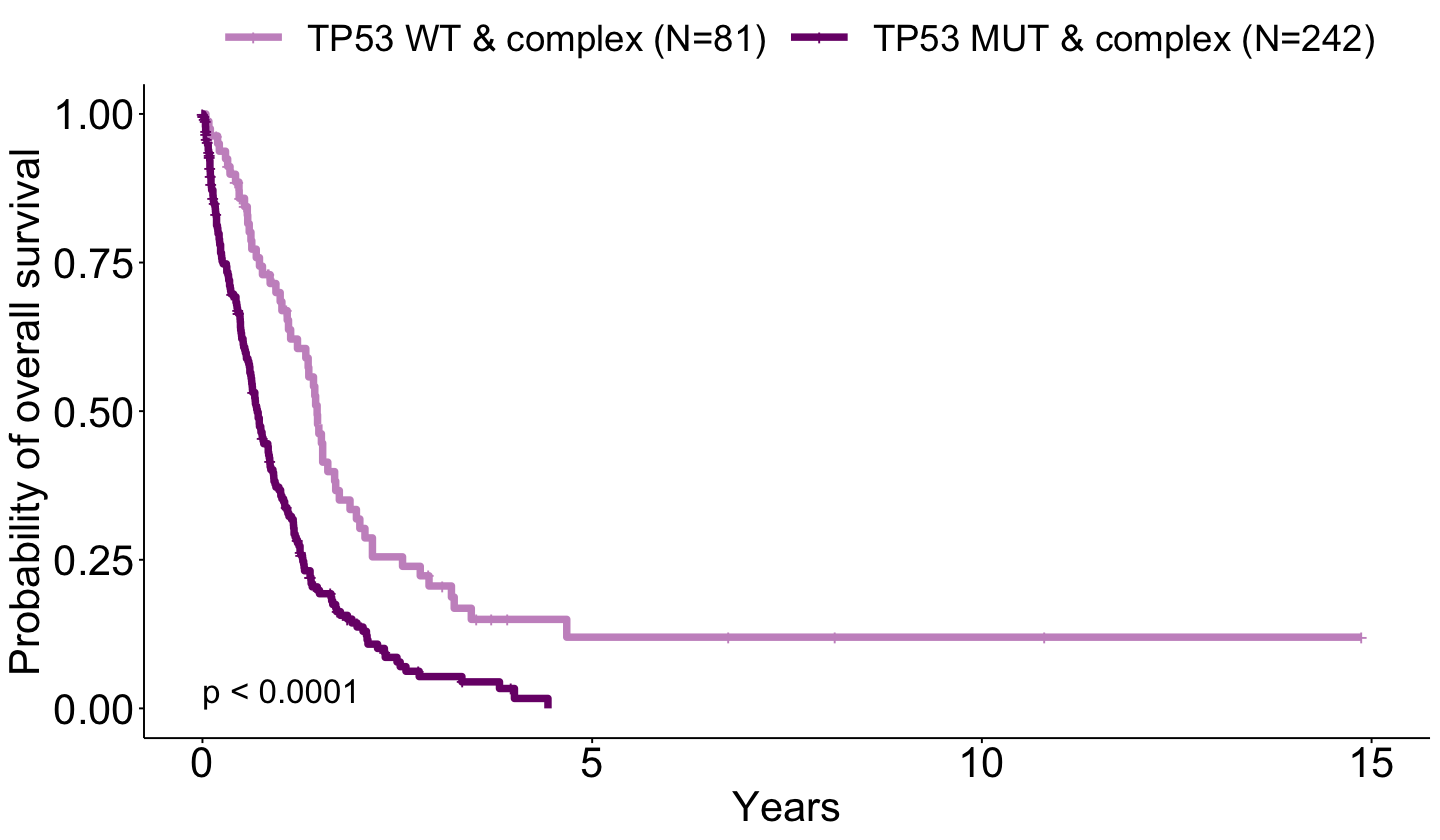

In [122]:
options(repr.plot.width=12, repr.plot.height=7)
tmp = dd[dd$complex=="complex",]
tmp$var= "TP53 WT & complex"
tmp$var[tmp$tp53=="MUT"] = "TP53 MUT & complex"
tmp$var = factor(tmp$var, levels=c("TP53 WT & complex","TP53 MUT & complex"))
ff = as.formula(paste("Surv(os_sample_years,os_status)~","var"))
kmfit = survfit(ff,data=tmp)
kmfit$call$formula <- ff

myleg = paste0(gsub("var=","",names(kmfit$strata))," (N=",kmfit$n,")")
ggckeasy2 = ggsurvplot(kmfit, data=tmp, legend.title="",conf.int=F, size=2.1, xlim=c(0,15),color="var",breaks=5,
                      font.x=25, font.y=25, font.tickslab=25, font.legend=22,
                      legend.labs=myleg,pval.coord = c(0, 0.03),pval.size=7,
                       pval=T,
                     )$plot +
scale_color_manual(values=c("#c994c7","#7a0177"),name="")  + 
theme(legend.key.width = unit(1.5,"cm")) +
xlab("Years") + ylab("Probability of overall survival")
ggckeasy2

We now look at the interaction between CK and TP53 allelic state.

First below the number/proportions of cases with or without CK per TP53 allelic state.

In [123]:
table(dd$allelic_status, dd$complex)

       
        complex non-complex
  WT         82        2864
  1mut       16         109
  multi     231          22

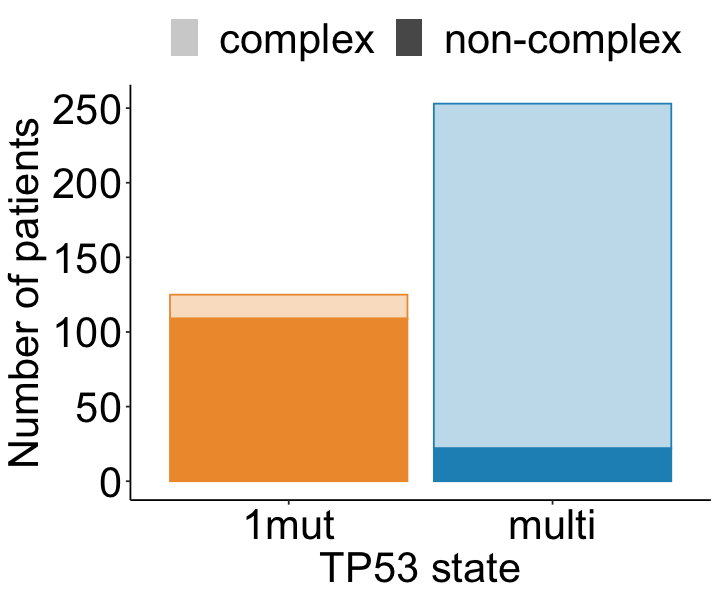

In [124]:
options(repr.plot.width=6, repr.plot.height=5)
ggckstate = ggplot(dd[dd$allelic_status!="WT",]) + geom_bar(aes(x=allelic_status, alpha=complex, fill=allelic_status, color=allelic_status)) + 
themePP + 
topleg  +
xlab("TP53 state") + ylab("Number of patients") + nolegtitle + 
scale_fill_manual(values=col.status,guide=FALSE) + scale_color_manual(values=col.status,guide=FALSE) + scale_alpha_manual(values=c("0.3","1"))
ggckstate

Kaplan Meier probability estimates of OS across cases with ot without CK and per TP53 allelic states.

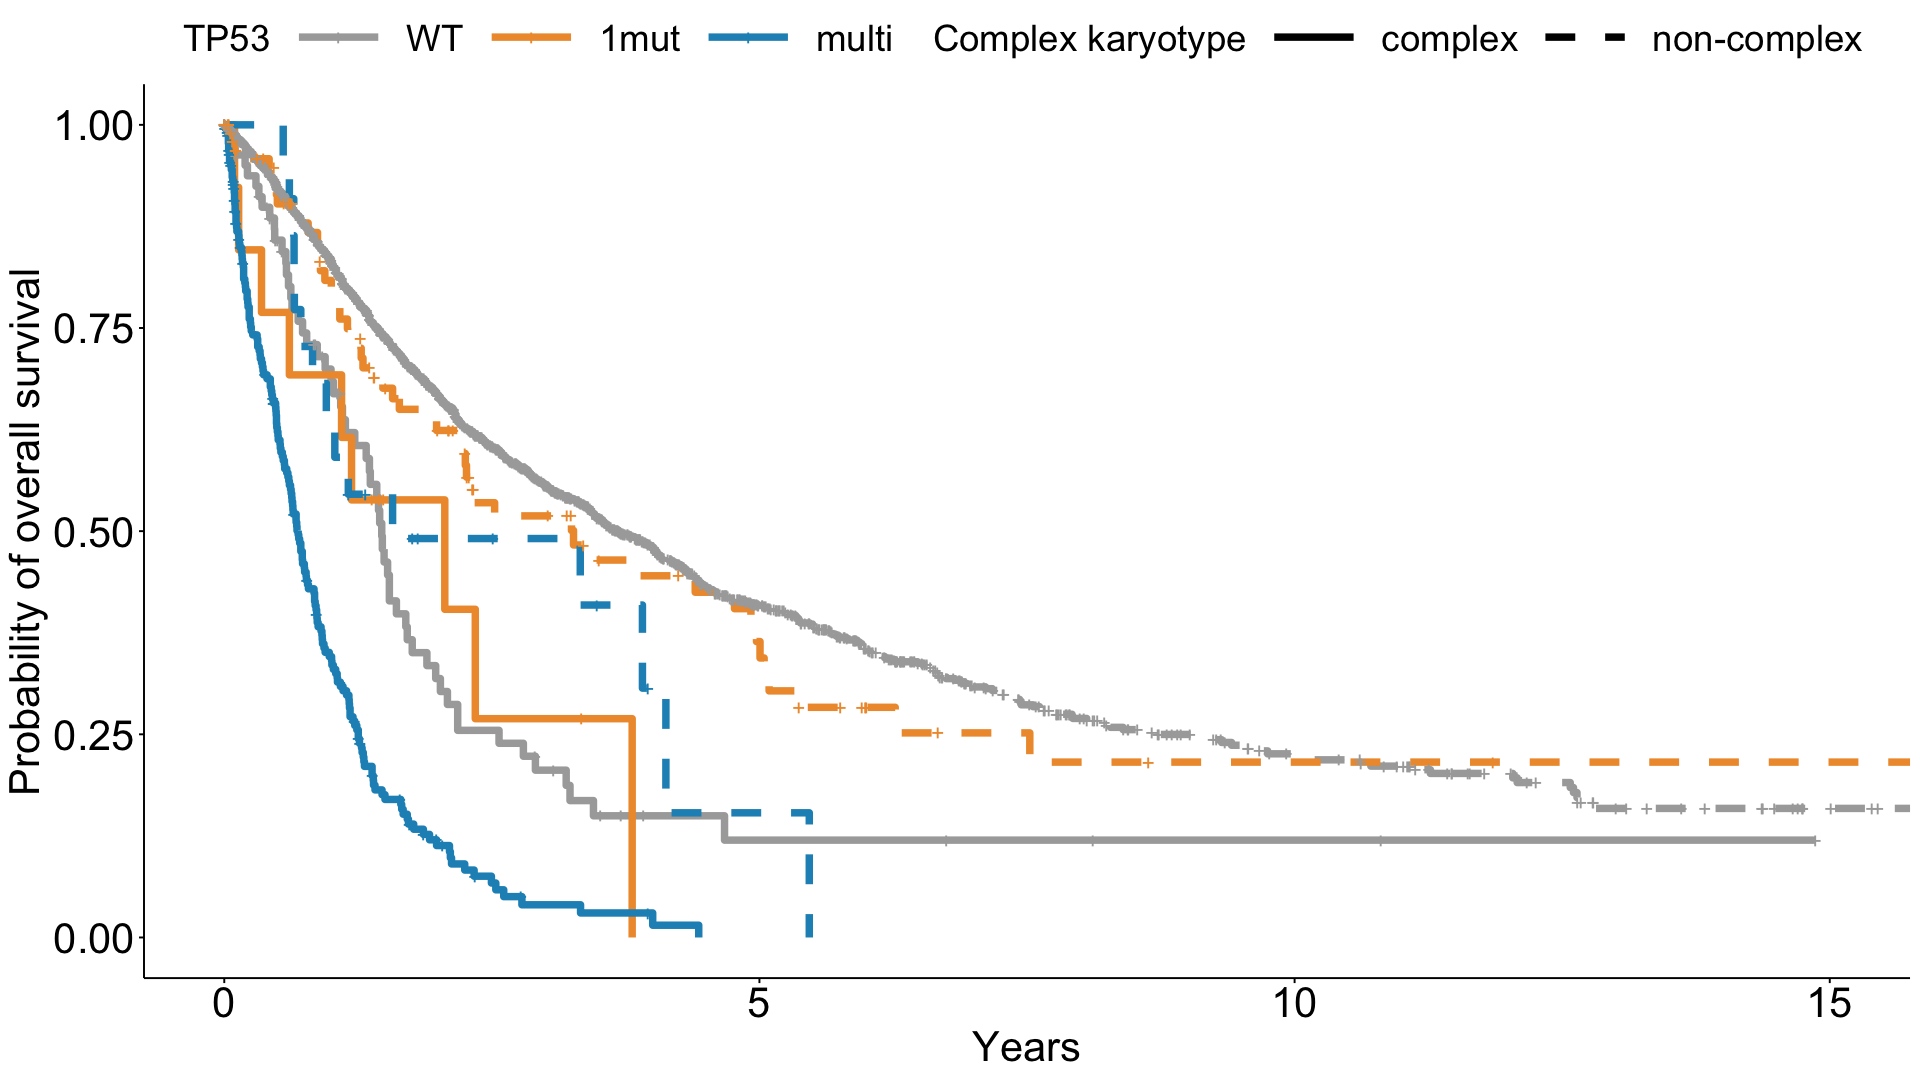

In [125]:
options(repr.plot.width=16, repr.plot.height=9)
ff = as.formula(paste("Surv(os_sample_years,os_status)~","complex + allelic_status"))
kmfit = survfit(ff,data=dd)
kmfit$call$formula <- ff
ggckstateos = ggsurvplot(kmfit, data=dd, legend.title="",conf.int=F, size=2.1, xlim=c(0,15),linetype="complex",color="allelic_status",breaks=5,
                      font.x=25, font.y=25, font.tickslab=25, font.legend=22,
                     )$plot +
scale_color_manual(values=c("darkgrey",col.status),name="TP53")  + 
scale_linetype_manual(values=c("solid","dashed"),name="Complex karyotype") + theme(legend.key.width = unit(2.1,"cm")) +
xlab("Years") + ylab("Probability of overall survival")
ptckstate = pairwise_survdiff(ff, data=dd, p.adjust.method = "none")$p.value
ggckstateos

In [126]:
# Pairwise Log-Rank test p-values:
pairwise_survdiff(ff, data=dd, p.adjust.method = "none")$p.value

complex=complex, allelic_status=WT   
complex=complex, allelic_status=1mut      8.962080e-01                         
complex=complex, allelic_status=multi     6.491470e-08                         
complex=non-complex, allelic_status=WT    7.038210e-10                         
complex=non-complex, allelic_status=1mut  3.075130e-04                         
complex=non-complex, allelic_status=multi 3.460207e-01                         
                                          complex=complex, allelic_status=1mut 
complex=complex, allelic_status=1mut              NA                           
complex=complex, allelic_status=multi     0.01460601                           
complex=non-complex, allelic_status=WT    0.00669659                           
complex=non-complex, allelic_status=1mut  0.05211708                           
complex=non-complex, allelic_status=multi 0.36755561                           
                                          complex=complex, allelic_status=multi
complex=complex, allelic_status=1mut                 NA                        
complex=complex, allelic_status=multi                NA                        
complex=non-complex, allelic_status=WT    3.665639e-125                        
complex=non-complex, allelic_status=1mut   5.155703e-21                        
complex=non-complex, allelic_status=multi  4.571781e-05                        
                                          complex=non-complex, allelic_status=WT   
complex=complex, allelic_status=1mut              NA                               
complex=complex, allelic_status=multi             NA                               
complex=non-complex, allelic_status=WT            NA                               
complex=non-complex, allelic_status=1mut  0.41349552                               
complex=non-complex, allelic_status=multi 0.01158698                               
                                          complex=non-complex, allelic_status=1mut 
complex=complex, allelic_status=1mut              NA                               
complex=complex, allelic_status=multi             NA                               
complex=non-complex, allelic_status=WT            NA                               
complex=non-complex, allelic_status=1mut          NA                               
complex=non-complex, allelic_status=multi 0.09852355

In [127]:
# Hazard Ratio multi vs. 1mut on cases with CK:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=dd[dd$allelic_status%in%c("1mut","multi") & dd$complex=="complex",]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = dd[dd$allelic_status %in% c("1mut", 
    "multi") & dd$complex == "complex", ])

  n= 242, number of events= 194 
   (5 observations deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)  
allelic_status1mut  -0.8165    0.4420   0.3437 -2.375   0.0175 *
allelic_statusmulti      NA        NA   0.0000     NA       NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut      0.442      2.262    0.2253    0.8669
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.521  (se = 0.012 )
Likelihood ratio test= 7.23  on 1 df,   p=0.007
Wald test            = 5.64  on 1 df,   p=0.02
Score (logrank) test = 5.96  on 1 df,   p=0.01


In [128]:
# Hazard Ratio multi vs. 1mut on cases without CK:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status")),data=dd[dd$allelic_status%in%c("1mut","multi") & dd$complex=="non-complex",]) )

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status")), data = dd[dd$allelic_status %in% c("1mut", 
    "multi") & dd$complex == "non-complex", ])

  n= 126, number of events= 69 
   (5 observations deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)
allelic_status1mut  -0.4866    0.6147   0.2973 -1.637    0.102
allelic_statusmulti      NA        NA   0.0000     NA       NA

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut     0.6147      1.627    0.3433     1.101
allelic_statusmulti        NA         NA        NA        NA

Concordance= 0.536  (se = 0.028 )
Likelihood ratio test= 2.45  on 1 df,   p=0.1
Wald test            = 2.68  on 1 df,   p=0.1
Score (logrank) test = 2.73  on 1 df,   p=0.1


In [129]:
# Cox model of OS with TP53 allelic state and complex karyotype as covariates:
summary( coxph(as.formula(paste("Surv(os_sample_years,os_status)~","allelic_status + complex")),data=dd ))

Call:
coxph(formula = as.formula(paste("Surv(os_sample_years,os_status)~", 
    "allelic_status + complex")), data = dd)

  n= 3172, number of events= 1547 
   (152 observations deleted due to missingness)

                       coef exp(coef) se(coef)      z Pr(>|z|)    
allelic_status1mut   0.1024    1.1079   0.1300  0.788    0.431    
allelic_statusmulti  0.8555    2.3525   0.1224  6.991 2.72e-12 ***
complexnon-complex  -0.8632    0.4218   0.1108 -7.790 6.70e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
allelic_status1mut     1.1079     0.9026    0.8586    1.4295
allelic_statusmulti    2.3525     0.4251    1.8509    2.9901
complexnon-complex     0.4218     2.3708    0.3394    0.5241

Concordance= 0.581  (se = 0.006 )
Likelihood ratio test= 335.8  on 3 df,   p=<2e-16
Wald test            = 465.9  on 3 df,   p=<2e-16
Score (logrank) test = 564.2  on 3 df,   p=<2e-16


# R session

In [130]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: OS X El Capitan 10.11.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.3    stringr_1.4.0     cmprsk_2.2-9      survminer_0.4.6  
[5] ggpubr_0.2.3      magrittr_1.5      survival_2.44-1.1 gridExtra_2.3    
[9] ggplot2_3.2.1    

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3      zoo_1.8-6         tidyselect_0.2.5  xfun_0.10        
 [5] repr_1.0.1        purrr_0.3.3       splines_3.5.1     lattice_0.20-38  
 [9] colorspace_1.4-1  generics_0.0.2    vctrs_0.2.0       htmltools_0.4.0  
[13] base64enc_0.1-3   survMisc_0.5.5    rlang